# Multi-regression of the metabolites concentrations

### Install project packages

In [1]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


### Install required python modules

In [ ]:
%%bash
pip install -r ../requirements.txt

In [3]:
tf.__version__

'2.5.0'

### Import fucntions

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import joblib

from tfrecords import write_tfrecords_concentrations, read_tfrecords_concentrations
from models import get_simple_mutli_regressor_mlp, CheckpointCallback

# I. Import data

## I.a. Large dataset with independent metabolites (10 000 samples)

### I.1.a load the data

In [3]:
filename_spectrum_large = '../data/concentration_data/Large_sample/Spectra_Mixt1.txt'
filename_concentrations_large = '../data/concentration_data/Large_sample/Concentrations_Mix1.txt'
data_spectrum_large = np.loadtxt(filename_spectrum_large, dtype=float)
data_concentrations_large = np.loadtxt(filename_concentrations_large, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_large.shape[1]+1))

In [4]:
#Convert into dataframes
df_spectrum_large = pd.DataFrame(data_spectrum_large).T
df_concentrations_large = pd.DataFrame(data_concentrations_large).T

### I.1.b Normalize the input

#### Define minimum and maximum value of spectrum

In [9]:
min_val = -50
max_val = 20000

In [6]:
norm_df_spectrum_large = (df_spectrum_large - min_val)/(max_val - min_val)

### I.1.c. Standardise the output

In [7]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_large = (df_concentrations_large - mean_concentrations)/sd_concentrations

In [8]:
print(norm_df_spectrum_large.shape)
print(stand_df_concentrations_large.shape)

(10000, 10000)
(10000, 48)


### I.1.d.  Shuffle the data

In [9]:
norm_df_spectrum_large, stand_df_concentrations_large = shuffle(norm_df_spectrum_large, stand_df_concentrations_large)

### I.1.e.  Split data into train and validation datasets

In [10]:
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(norm_df_spectrum_large,
                                                                            stand_df_concentrations_large,
                                                                            test_size=0.2)

### I.1.f.  Convert into tf.data

In [121]:
train_dataset_large = tf.data.Dataset.from_tensor_slices((X_train_large, y_train_large))
val_dataset_large = tf.data.Dataset.from_tensor_slices((X_test_large, y_test_large))

print(train_dataset_large.element_spec)
print(val_dataset_large.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.1.g.  Write tf.Record

In [28]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Large_sample/train',
                               dataset=train_dataset_large, number=32)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Large_sample/validation',
                               dataset=val_dataset_large, number=8)

## I.2 Large dataset with correlated metabolites (10 000 samples)

### I.2.a load the data

In [11]:
filename_spectrum_large_corr = '../data/concentration_data/Large_correlated/Spectra_Mixt1.txt'
filename_concentrations_large_corr = '../data/concentration_data/Large_correlated/Concentrations_Mix1.txt'
data_spectrum_large_corr = np.loadtxt(filename_spectrum_large_corr, dtype=float)
data_concentrations_large_corr = np.loadtxt(filename_concentrations_large_corr, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_large_corr.shape[1]+1))

In [12]:
#Convert into dataframes
df_spectrum_large_corr = pd.DataFrame(data_spectrum_large_corr).T
df_concentrations_large_corr = pd.DataFrame(data_concentrations_large_corr).T

### I.2.b Normalize the input

In [13]:
norm_df_spectrum_large_corr = (df_spectrum_large_corr - min_val)/(max_val - min_val)

### I.2.c Standardise the output

In [14]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_large_corr = (df_concentrations_large_corr - mean_concentrations)/sd_concentrations

In [15]:
print(norm_df_spectrum_large_corr.shape)
print(stand_df_concentrations_large_corr.shape)

(10000, 10000)
(10000, 48)


### I.2.d Shuffle the data

In [16]:
norm_df_spectrum_large_corr, stand_df_concentrations_large_corr = shuffle(norm_df_spectrum_large_corr,
                                                                          stand_df_concentrations_large_corr)

### I.2.e Split data into train and validation datasets

In [17]:
X_train_large_corr, X_test_large_corr, y_train_large_corr, y_test_large_corr = train_test_split(norm_df_spectrum_large_corr,
                                                                                                stand_df_concentrations_large_corr,
                                                                                                test_size=0.2)

### I.2.f Convert into tf.data

In [17]:
train_dataset_large_corr = tf.data.Dataset.from_tensor_slices((X_train_large_corr, y_train_large_corr))
val_dataset_large_corr = tf.data.Dataset.from_tensor_slices((X_test_large_corr, y_test_large_corr))

print(train_dataset_large_corr.element_spec)
print(val_dataset_large_corr.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.2.g Write tf.Record

In [18]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Large_correlated/train',
                               dataset=train_dataset_large_corr, number=32)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Large_correlated/validation',
                               dataset=val_dataset_large_corr, number=8)

## I.3 Small dataset with independent metabolites (1000 samples)

### I.3.a load the data

In [195]:
filename_spectrum_small = '../data/concentration_data/Small_sample/Spectra_Mixt1.txt'
filename_concentrations_small = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
data_spectrum_small = np.loadtxt(filename_spectrum_small, dtype=float)
data_concentrations_small = np.loadtxt(filename_concentrations_small, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_small.shape[1]+1))

In [196]:
#Convert into dataframes
df_spectrum_small = pd.DataFrame(data_spectrum_small).T
df_concentrations_small = pd.DataFrame(data_concentrations_small).T

### I.3.b Normalize the input

In [197]:
norm_df_spectrum_small = (df_spectrum_small - min_val)/(max_val - min_val)

### I.3.c Standardise the output

In [198]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_small = (df_concentrations_small - mean_concentrations)/sd_concentrations

In [199]:
print(norm_df_spectrum_small.shape)
print(stand_df_concentrations_small.shape)

(1000, 10000)
(1000, 48)


### I.3.d Shuffle the data

In [200]:
norm_df_spectrum_small, stand_df_concentrations_small = shuffle(norm_df_spectrum_small, stand_df_concentrations_small)

### I.3.e Split data into train and validation datasets

In [201]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(norm_df_spectrum_small,
                                                                            stand_df_concentrations_small,
                                                                            test_size=0.2)

### I.3.f Convert into tf.data

In [202]:
train_dataset_small = tf.data.Dataset.from_tensor_slices((X_train_small, y_train_small))
val_dataset_small = tf.data.Dataset.from_tensor_slices((X_test_small, y_test_small))

print(train_dataset_small.element_spec)
print(val_dataset_small.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.3.g Write tf.Record

In [204]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Small_sample/train',
                               dataset=train_dataset_small, number=8)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Small_sample/validation',
                               dataset=val_dataset_small, number=2)

## I.4 Small dataset with correlated metabolites (1000 samples)

### I.4.a load the data

In [25]:
filename_spectrum_small_corr = '../data/concentration_data/Small_correlated/Spectra_Mixt1.txt'
filename_concentrations_small_corr = '../data/concentration_data/Small_correlated/Concentrations_Mix1.txt'
data_spectrum_small_corr = np.loadtxt(filename_spectrum_small_corr, dtype=float)
data_concentrations_small_corr = np.loadtxt(filename_concentrations_small_corr, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_small_corr.shape[1]+1))

In [26]:
#Convert into dataframes
df_spectrum_small_corr = pd.DataFrame(data_spectrum_small_corr).T
df_concentrations_small_corr = pd.DataFrame(data_concentrations_small_corr).T

### I.4.b Normalize the input

In [27]:
norm_df_spectrum_small_corr = (df_spectrum_small_corr - min_val)/(max_val - min_val)

### I.4.c Standardise the output

In [28]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_small_corr = (df_concentrations_small_corr - mean_concentrations)/sd_concentrations

In [29]:
print(norm_df_spectrum_small_corr.shape)
print(stand_df_concentrations_small_corr.shape)

(1000, 10000)
(1000, 48)


### I.4.d Shuffle the data

In [30]:
norm_df_spectrum_small_corr, stand_df_concentrations_small_corr = shuffle(norm_df_spectrum_small_corr,
                                                                          stand_df_concentrations_small_corr)

### I.4.e Split data into train and validation datasets

In [31]:
X_train_small_corr, X_test_small_corr, y_train_small_corr, y_test_small_corr = train_test_split(norm_df_spectrum_small_corr,
                                                                                                stand_df_concentrations_small_corr,
                                                                                                test_size=0.2)

### I.4.f Convert into tf.data

In [57]:
train_dataset_small_corr = tf.data.Dataset.from_tensor_slices((X_train_small_corr, y_train_small_corr))
val_dataset_small_corr = tf.data.Dataset.from_tensor_slices((X_test_small_corr, y_test_small_corr))

print(train_dataset_small_corr.element_spec)
print(val_dataset_small_corr.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.4.g Write tf.Record

In [58]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Small_correlated/train',
                               dataset=train_dataset_small_corr, number=8)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Small_correlated/validation',
                               dataset=val_dataset_small_corr, number=2)

## I.5 Extra small dataset with independent metabolites (100 samples)

### I.5.a load the data

In [32]:
filename_spectrum_xsmall = '../data/concentration_data/Extra_small_sample/Spectra_Mixt1.txt'
filename_concentrations_xsmall = '../data/concentration_data/Extra_small_sample/Concentrations_Mix1.txt'
data_spectrum_xsmall = np.loadtxt(filename_spectrum_xsmall, dtype=float)
data_concentrations_xsmall = np.loadtxt(filename_concentrations_xsmall, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_xsmall.shape[1]+1))

In [33]:
#Convert into dataframes
df_spectrum_xsmall = pd.DataFrame(data_spectrum_xsmall).T
df_concentrations_xsmall = pd.DataFrame(data_concentrations_xsmall).T

### I.5.b Normalize the input

In [34]:
norm_df_spectrum_xsmall = (df_spectrum_xsmall - min_val)/(max_val - min_val)

### I.5.c Standardise the output

In [35]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_xsmall = (df_concentrations_xsmall - mean_concentrations)/sd_concentrations

In [36]:
print(norm_df_spectrum_xsmall.shape)
print(stand_df_concentrations_xsmall.shape)

(100, 10000)
(100, 48)


### I.5.d Shuffle the data

In [37]:
norm_df_spectrum_xsmall, stand_df_concentrations_xsmall = shuffle(norm_df_spectrum_xsmall,
                                                                  stand_df_concentrations_xsmall)

### I.5.e Split data into train and validation datasets

In [38]:
X_train_xsmall, X_test_xsmall, y_train_xsmall, y_test_xsmall = train_test_split(norm_df_spectrum_xsmall,
                                                                                stand_df_concentrations_xsmall,
                                                                                test_size=0.2)

### I.5.f Convert into tf.data

In [163]:
train_dataset_xsmall = tf.data.Dataset.from_tensor_slices((X_train_xsmall, y_train_xsmall))
val_dataset_xsmall = tf.data.Dataset.from_tensor_slices((X_test_xsmall, y_test_xsmall))

print(train_dataset_xsmall.element_spec)
print(.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.5.g Write tf.Record

In [165]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Extra_small_sample/train',
                               dataset=train_dataset_xsmall, number=4)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Extra_small_sample/validation',
                               dataset=val_dataset_xsmall, number=1)

## I.6 Extra small dataset with correlated metabolites (100 samples)

### I.6.a load the data

In [39]:
filename_spectrum_xsmall_corr = '../data/concentration_data/Extra_small_correlated/Spectra_Mixt1.txt'
filename_concentrations_xsmall_corr = '../data/concentration_data/Extra_small_correlated/Concentrations_Mix1.txt'
data_spectrum_xsmall_corr = np.loadtxt(filename_spectrum_xsmall_corr, dtype=float)
data_concentrations_xsmall_corr = np.loadtxt(filename_concentrations_xsmall_corr, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_xsmall_corr.shape[1]+1))

In [40]:
#Convert into dataframes
df_spectrum_xsmall_corr = pd.DataFrame(data_spectrum_xsmall_corr).T
df_concentrations_xsmall_corr = pd.DataFrame(data_concentrations_xsmall_corr).T

### I.6.b Normalize the input

In [41]:
norm_df_spectrum_xsmall_corr = (df_spectrum_xsmall_corr - min_val)/(max_val - min_val)

### I.6.c Standardise the output

In [42]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_xsmall_corr = (df_concentrations_xsmall_corr - mean_concentrations)/sd_concentrations

In [43]:
print(norm_df_spectrum_xsmall_corr.shape)
print(stand_df_concentrations_xsmall_corr.shape)

(100, 10000)
(100, 48)


### I.6.d Shuffle the data

In [44]:
norm_df_spectrum_xsmall_corr, stand_df_concentrations_xsmall_corr = shuffle(norm_df_spectrum_xsmall_corr,
                                                                            stand_df_concentrations_xsmall_corr)

### I.6.e Split data into train and validation datasets

In [45]:
X_train_xsmall_corr, X_test_xsmall_corr, y_train_xsmall_corr, y_test_xsmall_corr = train_test_split(norm_df_spectrum_xsmall_corr,
                                                                                                    stand_df_concentrations_xsmall_corr,
                                                                                                    test_size=0.2)

### I.6.f Convert into tf.data

In [174]:
train_dataset_xsmall_corr = tf.data.Dataset.from_tensor_slices((X_train_xsmall_corr, y_train_xsmall_corr))
val_dataset_xsmall_corr = tf.data.Dataset.from_tensor_slices((X_test_xsmall_corr, y_test_xsmall_corr))

print(train_dataset_xsmall_corr.element_spec)
print(val_dataset_xsmall_corr.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))
(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.6.g Write tf.Record

In [175]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Extra_small_correlated/train',
                               dataset=train_dataset_xsmall_corr, number=4)
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Extra_small_correlated/validation',
                               dataset=val_dataset_xsmall_corr, number=1)

## I.7 Test dataset with independent metabolites (1000 samples)

### I.7.a load the data

In [10]:
filename_spectrum_test = '../data/concentration_data/Test_independent/Spectra_Mixt1.txt'
filename_concentrations_test = '../data/concentration_data/Test_independent/Concentrations_Mix1.txt'
data_spectrum_test = np.loadtxt(filename_spectrum_test, dtype=float)
data_concentrations_test = np.loadtxt(filename_concentrations_test, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_test.shape[1]+1))

In [11]:
#Convert into dataframes
df_spectrum_test = pd.DataFrame(data_spectrum_test).T
df_concentrations_test = pd.DataFrame(data_concentrations_test).T

### I.7.b Normalize the input

In [12]:
norm_df_spectrum_test = (df_spectrum_test - min_val)/(max_val - min_val)

### I.7.c Standardise the output

In [13]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_test = (df_concentrations_test - mean_concentrations)/sd_concentrations

In [14]:
print(norm_df_spectrum_test.shape)
print(stand_df_concentrations_test.shape)

(1000, 10000)
(1000, 48)


### I.7.d Shuffle the data

In [15]:
norm_df_spectrum_test, stand_df_concentrations_test = shuffle(norm_df_spectrum_test, stand_df_concentrations_test)

### I.7.e Convert into tf.data

In [197]:
test_dataset = tf.data.Dataset.from_tensor_slices((norm_df_spectrum_test, stand_df_concentrations_test))

print(test_dataset.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.7.f Write tf.Record

In [67]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Test_independent',
                               dataset=test_dataset, number=10)

## I.8 Test dataset with correlated metabolites (1000 samples)

### I.8.a load the data

In [16]:
filename_spectrum_test_corr = '../data/concentration_data/Test_correlated/Spectra_Mixt1.txt'
filename_concentrations_test_corr = '../data/concentration_data/Test_correlated/Concentrations_Mix1.txt'
data_spectrum_test_corr = np.loadtxt(filename_spectrum_test_corr, dtype=float)
data_concentrations_test_corr = np.loadtxt(filename_concentrations_test_corr, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_test_corr.shape[1]+1))

In [17]:
#Convert into dataframes
df_spectrum_test_corr = pd.DataFrame(data_spectrum_test_corr).T
df_concentrations_test_corr = pd.DataFrame(data_concentrations_test_corr).T

### I.8.b Normalize the input

In [18]:
norm_df_spectrum_test_corr = (df_spectrum_test_corr - min_val)/(max_val - min_val)

### I.8.c Standardise the output

In [19]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_test_corr = (df_concentrations_test_corr - mean_concentrations)/sd_concentrations

In [20]:
print(norm_df_spectrum_test_corr.shape)
print(stand_df_concentrations_test_corr.shape)

(1000, 10000)
(1000, 48)


### I.8.d Shuffle the data

In [21]:
norm_df_spectrum_test_corr, stand_df_concentrations_test_corr = shuffle(norm_df_spectrum_test_corr,
                                                                        stand_df_concentrations_test_corr)

### I.8.e Convert into tf.data

In [204]:
test_corr_dataset = tf.data.Dataset.from_tensor_slices((norm_df_spectrum_test_corr,
                                                        stand_df_concentrations_test_corr))

print(test_corr_dataset.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.8.f Write tf.Record

In [75]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Test_correlated',
                               dataset=test_corr_dataset, number=10)

## I.9 Test abnormal urine dataset with independent metabolites (1000 samples)

### I.9.a load the data

In [22]:
filename_spectrum_abn_test = '../data/concentration_data/Test_abnormal/Spectra_Mix2.txt'
filename_concentrations_abn_test = '../data/concentration_data/Test_abnormal/Concentrations_Mix2.txt'
data_spectrum_abn_test = np.loadtxt(filename_spectrum_abn_test, dtype=float)
data_concentrations_abn_test = np.loadtxt(filename_concentrations_abn_test, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_abn_test.shape[1]+1))

In [23]:
#Convert into dataframes
df_spectrum_abn_test = pd.DataFrame(data_spectrum_abn_test).T
df_concentrations_abn_test = pd.DataFrame(data_concentrations_abn_test).T

### I.9.b Normalize the input

In [24]:
norm_df_spectrum_abn_test = (df_spectrum_abn_test - min_val)/(max_val - min_val)

### I.9.c Standardise the output

In [25]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_abn_test = (df_concentrations_abn_test - mean_concentrations)/sd_concentrations

In [26]:
print(norm_df_spectrum_abn_test.shape)
print(stand_df_concentrations_abn_test.shape)

(1000, 10000)
(1000, 48)


### I.9.d Shuffle the data

In [27]:
norm_df_spectrum_abn_test, stand_df_concentrations_abn_test = shuffle(norm_df_spectrum_abn_test,
                                                                      stand_df_concentrations_abn_test)

### I.9.e Convert into tf.data

In [130]:
abn_test_dataset = tf.data.Dataset.from_tensor_slices((norm_df_spectrum_abn_test, stand_df_concentrations_abn_test))

print(abn_test_dataset.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.9.f Write tf.Record

In [132]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Test_abnormal',
                               dataset=abn_test_dataset, number=10)

## I.10 Test abnormal urine dataset with correlated metabolites (1000 samples)

### I.10.a load the data

In [28]:
filename_spectrum_abn_test_corr = '../data/concentration_data/Test_abnormal_corr/Spectra_Mix2.txt'
filename_concentrations_abn_test_corr = '../data/concentration_data/Test_abnormal_corr/Concentrations_Mix2.txt'
data_spectrum_abn_test_corr = np.loadtxt(filename_spectrum_abn_test_corr, dtype=float)
data_concentrations_abn_test_corr = np.loadtxt(filename_concentrations_abn_test_corr, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum_abn_test_corr.shape[1]+1))

In [29]:
#Convert into dataframes
df_spectrum_abn_test_corr = pd.DataFrame(data_spectrum_abn_test_corr).T
df_concentrations_abn_test_corr = pd.DataFrame(data_concentrations_abn_test_corr).T

### I.10.b Normalize the input

In [30]:
norm_df_spectrum_abn_test_corr = (df_spectrum_abn_test_corr - min_val)/(max_val - min_val)

### I.10.c Standardise the output

In [31]:
#Import mean concentration data and metabolites
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)

stand_df_concentrations_abn_test_corr = (df_concentrations_abn_test_corr - mean_concentrations)/sd_concentrations

In [32]:
print(norm_df_spectrum_abn_test_corr.shape)
print(stand_df_concentrations_abn_test_corr.shape)

(1000, 10000)
(1000, 48)


### I.10.d Shuffle the data

In [33]:
norm_df_spectrum_abn_test_corr, stand_df_concentrations_abn_test_corr = shuffle(norm_df_spectrum_abn_test_corr,
                                                                        stand_df_concentrations_abn_test_corr)

### I.10.e Convert into tf.data

In [139]:
abn_test_corr_dataset = tf.data.Dataset.from_tensor_slices((norm_df_spectrum_abn_test_corr,
                                                        stand_df_concentrations_abn_test_corr))

print(abn_test_corr_dataset.element_spec)

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None), TensorSpec(shape=(48,), dtype=tf.float64, name=None))


### I.10.f Write tf.Record

In [140]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data/Test_abnormal_corr',
                               dataset=abn_test_corr_dataset, number=10)

---
# II. Read the tf.Record files

## II.1 Small independent dataset (1000 spectra)

In [5]:
small_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/train/data_{}.tfrecord'.format(i)
                    for i in range(8)]
small_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/validation/data_{}.tfrecord'.format(i)
                    for i in range(2)]

small_train_dataset = read_tfrecords_concentrations(small_train_file_paths)
small_train_dataset = small_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

small_val_dataset = read_tfrecords_concentrations(small_val_file_paths)
small_val_dataset = small_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.2 Small correlated dataset (1000 spectra)

In [6]:
small_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(8)]
small_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(2)]

small_corr_train_dataset = read_tfrecords_concentrations(small_corr_train_file_paths)
small_corr_train_dataset = small_corr_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

small_corr_val_dataset = read_tfrecords_concentrations(small_corr_val_file_paths)
small_corr_val_dataset = small_corr_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.3 Large independent dataset (10000 spectra)

In [7]:
large_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/train/data_{}.tfrecord'.format(i) 
                        for i in range(32)]
large_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/validation/data_{}.tfrecord'.format(i) 
                      for i in range(8)]

large_train_dataset = read_tfrecords_concentrations(large_train_file_paths)
large_train_dataset = large_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_val_dataset = read_tfrecords_concentrations(large_val_file_paths)
large_val_dataset = large_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.4 Large correlated dataset (10000 spectra)

In [8]:
large_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(32)]
large_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(8)]

large_corr_train_dataset = read_tfrecords_concentrations(large_corr_train_file_paths)
large_corr_train_dataset = large_corr_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_corr_val_dataset = read_tfrecords_concentrations(large_corr_val_file_paths)
large_corr_val_dataset = large_corr_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.5 Extra small independent dataset (100 spectra)

In [9]:
xsmall_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/train/data_{}.tfrecord'
                           .format(i) for i in range(4)]
xsmall_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/validation/data_{}.tfrecord'
                         .format(i) for i in range(1)]

xsmall_train_dataset = read_tfrecords_concentrations(xsmall_train_file_paths)
xsmall_train_dataset = xsmall_train_dataset.batch(8).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_val_dataset = read_tfrecords_concentrations(xsmall_val_file_paths)
xsmall_val_dataset = xsmall_val_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## II.6 Extra small correlated dataset (100 spectra)

In [10]:
xsmall_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(4)]
xsmall_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(1)]

xsmall_corr_train_dataset = read_tfrecords_concentrations(xsmall_corr_train_file_paths)
xsmall_corr_train_dataset = xsmall_corr_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_corr_val_dataset = read_tfrecords_concentrations(xsmall_corr_val_file_paths)
xsmall_corr_val_dataset = xsmall_corr_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.7 Test independent dataset (1000 spectra)

In [11]:
test_file_paths = ['../data/tfrecords/Concentrations_data/Test_independent/data_{}.tfrecord'
                               .format(i) for i in range(10)]

test_dataset = read_tfrecords_concentrations(test_file_paths)
test_dataset = test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.8 Test correlated dataset (1000 spectra)

In [12]:
test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_correlated/data_{}.tfrecord'
                        .format(i) for i in range(10)]

test_corr_dataset = read_tfrecords_concentrations(test_corr_file_paths)
test_corr_dataset = test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.9 Test abnormal independent dataset (1000 spectra)

In [13]:
abn_test_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal/data_{}.tfrecord'
                               .format(i) for i in range(10)]

abn_test_dataset = read_tfrecords_concentrations(abn_test_file_paths)
abn_test_dataset = abn_test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.10 Test correlated dataset (1000 spectra)

In [14]:
abn_test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal_corr/data_{}.tfrecord'
                        .format(i) for i in range(10)]

abn_test_corr_dataset = read_tfrecords_concentrations(abn_test_corr_file_paths)
abn_test_corr_dataset = abn_test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.11 Extract each metabolite from dataset (for independent quantification)

In [15]:
def extract_metabolite(x, y, metab_index):
    return(x, y[..., metab_index])

xsmall_train_datasets_single = [xsmall_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_val_datasets_single = [xsmall_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_corr_train_datasets_single = [xsmall_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
xsmall_corr_val_datasets_single = [xsmall_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
small_train_datasets_single = [small_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_val_datasets_single = [small_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_corr_train_datasets_single = [small_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
small_corr_val_datasets_single = [small_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
large_train_datasets_single = [large_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_val_datasets_single = [large_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_corr_train_datasets_single = [large_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                    for i in range(48)]
large_corr_val_datasets_single = [large_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                  for i in range(48)]
test_datasets_single = [test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
test_corr_datasets_single = [test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_datasets_single = [abn_test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_corr_datasets_single = [abn_test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                 for i in range(48)]

---
# III. Define Models

## III.1 Small independent dataset

### III.1.a Mutli output MLP

In [16]:
small_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
small_multi_mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 256)               2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.1.b Mutli output Random Forest

In [17]:
small_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.1.c Single output MLP

In [18]:
small_inde_mlps = []

for i in range(48):
    small_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

small_inde_mlps[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.1.d Single output Random Forest

In [19]:
small_inde_RFs = []

for i in range(48):
    small_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.1.e Partial least squares

#### III.1.e.i Tune Hyperparameter Cross Validation

In [20]:
# rmse_tune_small_pls = []
# time_tune_small_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)] + [i for i in range(200, 401, 100)]
# for n_components in list_n_components:
#     small_pls = PLSRegression(n_components)
#     scores = cross_validate(small_pls, X_train_small, y_train_small, scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_small_pls.append(rmse)
#     time_tune_small_pls.append(time)

#### III.1.e.ii Plot tuning curve

In [21]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_small_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_small_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [22]:
small_pls = PLSRegression(200)

## III.2 Small correlated dataset

### III.2.a Mutli output MLP

In [23]:
small_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
small_corr_multi_mlp.summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_147 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_148 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_149 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.2.b Mutli output Random Forest

In [24]:
small_corr_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.2.c Single output MLP

In [25]:
small_corr_inde_mlps = []

for i in range(48):
    small_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

small_corr_inde_mlps[0].summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_150 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_151 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.2.d Single output Random Forest

In [26]:
small_corr_inde_RFs = []

for i in range(48):
    small_corr_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.2.e Partial least squares

In [27]:
# rmse_tune_small_corr_pls = []
# time_tune_small_corr_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)] + [i for i in range(200, 401, 100)]
# for n_components in list_n_components:
#     small_corr_pls = PLSRegression(n_components)
#     scores = cross_validate(small_corr_pls, X_train_small_corr, y_train_small_corr, scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_small_corr_pls.append(rmse)
#     time_tune_small_corr_pls.append(time)

#### III.1.e.ii Plot tuning curve

In [28]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_small_corr_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_small_corr_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [29]:
small_corr_pls = PLSRegression(200)

## III.3 Large independent dataset

### III.3.a Mutli output MLP

In [30]:
large_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
large_multi_mlp.summary()
large_multi_mlp_2048 = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8192, 4096, 2048], 
                                                      num_outputs=48)
large_multi_mlp_2048.summary()

Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_294 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_295 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_296 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________
Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 10000)]           0         
______________________________

### III.3.b Mutli output Random Forest

In [31]:
large_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.3.c Single output MLP

In [32]:
large_inde_mlps = []

for i in range(48):
    large_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

large_inde_mlps[0].summary()

Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_301 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_302 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_303 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.3.d Single output Random Forest

In [33]:
large_inde_RFs = []

for i in range(48):
    large_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.3.e Partial least squares

In [34]:
large_pls = PLSRegression(200)

## III.4 Large correlated dataset

### III.4.a Mutli output MLP

In [35]:
large_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
large_corr_multi_mlp.summary()

Model: "model_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_445 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_446 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_447 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.4.b Mutli output Random Forest

In [36]:
large_corr_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.4.c Single output MLP

In [37]:
large_corr_inde_mlps = []

for i in range(48):
    large_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

large_corr_inde_mlps[0].summary()

Model: "model_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_150 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_448 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_449 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_450 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.4.d Single output Random Forest

In [38]:
large_corr_inde_RFs = []

for i in range(48):
    large_corr_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.4.e Partial least squares

In [39]:
large_corr_pls = PLSRegression(200)

## III.5 Exrtra small independent dataset

### III.5.a Mutli output MLP

In [40]:
xsmall_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
xsmall_multi_mlp.summary()

Model: "model_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_198 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_592 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_593 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_594 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.5.b Mutli output Random Forest

In [41]:
xsmall_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.5.c Single output MLP

In [42]:
xsmall_inde_mlps = []

for i in range(48):
    xsmall_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

xsmall_inde_mlps[0].summary()

Model: "model_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_595 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_596 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_597 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.5.d Single output Random Forest

In [43]:
xsmall_inde_RFs = []

for i in range(48):
    xsmall_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.5.e Partial least squares

#### III.5.e.i Tune Hyperparameter Cross Validation

In [44]:
# rmse_tune_xsmall_pls = []
# time_tune_xsmall_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)]
# for n_components in list_n_components:
#     xsmall_pls = PLSRegression(n_components)
#     scores = cross_validate(xsmall_pls, X_train_xsmall, y_train_xsmall, scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_xsmall_pls.append(rmse)
#     time_tune_xsmall_pls.append(time)

#### III.5.e.ii Plot tuning curve

In [45]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_xsmall_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_xsmall_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [46]:
xsmall_pls = PLSRegression(70)

## III.6 Extra small correlated dataset

### III.6.a Mutli output MLP

In [47]:
xsmall_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
xsmall_corr_multi_mlp.summary()

Model: "model_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_247 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_739 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_740 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_741 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.2.b Mutli output Random Forest

In [48]:
xsmall_corr_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.2.c Single output MLP

In [49]:
xsmall_corr_inde_mlps = []

for i in range(48):
    xsmall_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

xsmall_corr_inde_mlps[0].summary()

Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_248 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_742 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_743 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_744 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.2.d Single output Random Forest

In [50]:
xsmall_corr_inde_RFs = []

for i in range(48):
    xsmall_corr_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.2.e Partial least squares

In [51]:
# rmse_tune_xsmall_corr_pls = []
# time_tune_xsmall_corr_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)]
# for n_components in list_n_components:
#     xsmall_corr_pls = PLSRegression(n_components)
#     scores = cross_validate(xsmall_corr_pls, X_train_xsmall_corr, y_train_xsmall_corr,
#                             scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_xsmall_corr_pls.append(rmse)
#     time_tune_xsmall_corr_pls.append(time)

#### III.1.e.ii Plot tuning curve

In [52]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_xsmall_corr_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_xsmall_corr_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [53]:
xsmall_corr_pls = PLSRegression(70)

---
# IV. Compile models

## IV.1 Multi Output MLPs

In [54]:
xsmall_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
xsmall_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
small_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
small_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_multi_mlp_2048.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

## IV.1 Single Output MLPs

In [55]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])

---
# V. Define Callbacks

## V.1 Checkpoints

In [56]:
ckpt_xsmall_multi = CheckpointCallback("../saved_models/concentrations/extra_small_multi")
ckpt_xsmall_corr_multi = CheckpointCallback("../saved_models/concentrations/extra_small_corr_multi")
ckpt_xsmall_single = [CheckpointCallback("../saved_models/concentrations/extra_small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_xsmall_corr_single = [CheckpointCallback("../saved_models/concentrations/extra_small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_small_multi = CheckpointCallback("../saved_models/concentrations/small_multi")
ckpt_small_corr_multi = CheckpointCallback("../saved_models/concentrations/small_corr_multi")
ckpt_small_single = [CheckpointCallback("../saved_models/concentrations/small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_small_corr_single = [CheckpointCallback("../saved_models/concentrations/small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_large_multi = CheckpointCallback("../saved_models/concentrations/large_multi")
ckpt_large_multi_2048 = CheckpointCallback("../saved_models/concentrations/large_multi_2048")
ckpt_large_corr_multi = CheckpointCallback("../saved_models/concentrations/large_corr_multi")
ckpt_large_single = [CheckpointCallback("../saved_models/concentrations/large_single/metabolite_{}"
                                      .format(i)) for i in range(48)]
ckpt_large_corr_single = [CheckpointCallback("../saved_models/concentrations/large_corr_single/metabolite_{}"
                                      .format(i)) for i in range(48)]

## V.2 Earlystopping

In [57]:
earlystopping_100 = tf.keras.callbacks.EarlyStopping(patience=100) #for small dataset
earlystopping_50 = tf.keras.callbacks.EarlyStopping(patience=50) #for large dataset

## V.3 Training logs

In [58]:
logs_xsmall_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_multi.csv")
logs_xsmall_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_multi.csv")
logs_xsmall_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_xsmall_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_small_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_multi.csv")
logs_small_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_multi.csv")
logs_small_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_small_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_large_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_multi.csv")
logs_large_multi_2048 = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_multi_2048.csv")
logs_large_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_multi.csv")
logs_large_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]
logs_large_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]

---
# VI. Fit models

## VI.1 Multi Output MLPs

In [26]:
# xsmall_multi_mlp.fit(xsmall_train_dataset, epochs=1000,
#                                           validation_data=xsmall_val_dataset,
#                                           callbacks=[ckpt_xsmall_multi, logs_xsmall_multi,
#                                                      earlystopping_100])
# xsmall_corr_multi_mlp.fit(xsmall_corr_train_dataset, epochs=1000,
#                                                     validation_data=xsmall_corr_val_dataset,
#                                                     callbacks=[ckpt_xsmall_corr_multi, logs_xsmall_corr_multi,
#                                                                earlystopping_100])
# small_multi_mlp.fit(small_train_dataset, epochs=1000,
#                                           validation_data=small_val_dataset,
#                                           callbacks=[ckpt_small_multi, logs_small_multi,
#                                                      earlystopping_100])
# small_corr_multi_mlp.fit(small_corr_train_dataset, epochs=1000,
#                                                     validation_data=small_corr_val_dataset,
#                                                     callbacks=[ckpt_small_corr_multi, logs_small_corr_multi,
#                                                                earlystopping_100])
# large_multi_mlp.fit(large_train_dataset, epochs=1000,
#                                           validation_data=large_val_dataset,
#                                           callbacks=[ckpt_large_multi, logs_large_multi,
#                                                      earlystopping_50])
large_multi_mlp_2048.fit(large_train_dataset, epochs=1000,
                                          validation_data=large_val_dataset,
                                          callbacks=[ckpt_large_multi_2048, logs_large_multi_2048,
                                                     earlystopping_50])
# large_corr_multi_mlp.fit(large_corr_train_dataset, epochs=1000,
#                                                     validation_data=large_corr_val_dataset,
#                                                     callbacks=[ckpt_large_corr_multi, logs_large_corr_multi,
#                                                                earlystopping_50])

Epoch 1/1000
63/63 [==============================] - 14s 209ms/step - loss: 3.5625 - root_mean_squared_error: 1.8875 - val_loss: 0.8825 - val_root_mean_squared_error: 0.9394
Epoch 2/1000
63/63 [==============================] - 12s 186ms/step - loss: 0.8605 - root_mean_squared_error: 0.9276 - val_loss: 0.8519 - val_root_mean_squared_error: 0.9230
Epoch 3/1000
63/63 [==============================] - 12s 186ms/step - loss: 0.8322 - root_mean_squared_error: 0.9122 - val_loss: 0.8164 - val_root_mean_squared_error: 0.9036
Epoch 4/1000
63/63 [==============================] - 13s 193ms/step - loss: 0.7987 - root_mean_squared_error: 0.8937 - val_loss: 0.7908 - val_root_mean_squared_error: 0.8893
Epoch 5/1000
63/63 [==============================] - 12s 188ms/step - loss: 0.7498 - root_mean_squared_error: 0.8659 - val_loss: 0.7063 - val_root_mean_squared_error: 0.8404
Epoch 6/1000
63/63 [==============================] - 12s 189ms/step - loss: 0.6905 - root_mean_squared_error: 0.8310 - val_l

## VI.2 Multi Output Random Forests

In [260]:
start = time.time()
xsmall_multi_RF.fit(X_train_xsmall, y_train_xsmall)
time_xsmall = time.time() - start
joblib.dump(xsmall_multi_RF, "../saved_models/concentrations/xsmall_multi_RF")
joblib.dump(time_xsmall, "../saved_models/concentrations/time_RF/xsmall")
print("xsmall")

start = time.time()
xsmall_corr_multi_RF.fit(X_train_xsmall_corr, y_train_xsmall_corr)
time_xsmall_corr = time.time() - start
joblib.dump(xsmall_corr_multi_RF, "../saved_models/concentrations/xsmall_corr_multi_RF")
joblib.dump(time_xsmall_corr, "../saved_models/concentrations/time_RF/xsmall_corr")
print("xsmall corr")

start = time.time()
small_multi_RF.fit(X_train_small, y_train_small)
time_small = time.time() - start
joblib.dump(small_multi_RF, "../saved_models/concentrations/small_multi_RF")
joblib.dump(time_small, "../saved_models/concentrations/time_RF/small")
print("small")

start = time.time()
small_corr_multi_RF.fit(X_train_small_corr, y_train_small_corr)
time_small_corr = time.time() - start
joblib.dump(small_corr_multi_RF, "../saved_models/concentrations/small_corr_multi_RF")
joblib.dump(time_small_corr, "../saved_models/concentrations/time_RF/small_corr")
print("small corr")

start = time.time()
large_multi_RF.fit(X_train_large, y_train_large)
time_large = time.time() - start
joblib.dump(large_multi_RF, "../saved_models/concentrations/large_multi_RF")
joblib.dump(time_large, "../saved_models/concentrations/time_RF/large")
print("large")

start = time.time()
large_corr_multi_RF.fit(X_train_large_corr, y_train_large_corr)
time_large_corr = time.time() - start
joblib.dump(large_corr_multi_RF, "../saved_models/concentrations/large_corr_multi_RF")
joblib.dump(time_large_corr, "../saved_models/concentrations/time_RF/large_corr")
print("large corr")

small


/home/ar1220/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


## VI.3 Single Output MLPs

In [261]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.fit(xsmall_train_datasets_single[i], epochs=1000,
                        validation_data=xsmall_val_datasets_single[i],
                        callbacks=[ckpt_xsmall_single[i], logs_xsmall_single[i], earlystopping_100])
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.fit(xsmall_corr_train_datasets_single[i], epochs=1000,
                             validation_data=xsmall_corr_val_datasets_single[i],
                             callbacks=[ckpt_xsmall_corr_single[i], logs_xsmall_corr_single[i], earlystopping_100])
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.fit(small_train_datasets_single[i], epochs=1000,
                       validation_data=small_val_datasets_single[i],
                       callbacks=[ckpt_small_single[i], logs_small_single[i],
                                                                    earlystopping_100])
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.fit(small_corr_train_datasets_single[i], epochs=1000,
                                                         validation_data=small_corr_val_datasets_single[i],
                                                         callbacks=[ckpt_small_corr_single[i],
                                                                    logs_small_corr_single[i], earlystopping_100])
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.fit(large_train_datasets_single[i], epochs=1000,
                                                         validation_data=large_val_datasets_single[i],
                                                         callbacks=[ckpt_large_single[i], logs_large_single[i],
                                                                    earlystopping_50])
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.fit(large_corr_train_datasets_single[i], epochs=1000,
                                                         validation_data=large_corr_val_datasets_single[i],
                                                         callbacks=[ckpt_large_corr_single[i],
                                                                    logs_large_corr_single[i], earlystopping_50])
    print('\n', '\n', '####', '\n', '\n', 'Model number {} is trained !'.format(i), '\n', '\n', '####', '\n', '\n')
    


Epoch 1/1000
50/50 [==============================] - 1s 25ms/step - loss: 0.1828 - root_mean_squared_error: 0.4275 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 2/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 3/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 8.2460e-04 - val_root_mean_squared_error: 0.0287
Epoch 4/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.9655e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 5/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 7.2531e-04 - val_root_mean_squared_error: 0.0269
Epoch 6/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_lo

Epoch 93/1000
50/50 [==============================] - 0s 8ms/step - loss: 2.6659e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.2282e-04 - val_root_mean_squared_error: 0.0180
Epoch 94/1000
50/50 [==============================] - 0s 7ms/step - loss: 4.3017e-04 - root_mean_squared_error: 0.0207 - val_loss: 2.0110e-04 - val_root_mean_squared_error: 0.0142
Epoch 95/1000
50/50 [==============================] - 0s 10ms/step - loss: 2.1725e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 96/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 4.9401e-04 - val_root_mean_squared_error: 0.0222
Epoch 97/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 9.2736e-04 - val_root_mean_squared_error: 0.0305
Epoch 98/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_erro

Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 6.3613e-04 - val_root_mean_squared_error: 0.0252
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.7754e-04 - root_mean_squared_error: 0.0313 - val_loss: 2.9079e-04 - val_root_mean_squared_error: 0.0171
Epoch 26/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 3.3679e-04 - val_root_mean_squared_error: 0.0184
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 2.8130e-04 - val_root_mean_squared_error: 0.0168
Epoch 28/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 3.2213e-04 - val_root_mean_squared_error: 0.0179
Epoch 29/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.

Epoch 116/1000
50/50 [==============================] - 0s 9ms/step - loss: 4.9218e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.3226e-04 - val_root_mean_squared_error: 0.0208
Epoch 117/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.9329e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 118/1000
50/50 [==============================] - 1s 12ms/step - loss: 9.0627e-04 - root_mean_squared_error: 0.0301 - val_loss: 2.1128e-04 - val_root_mean_squared_error: 0.0145
Epoch 119/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.0543e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 120/1000
50/50 [==============================] - 0s 9ms/step - loss: 9.5553e-04 - root_mean_squared_error: 0.0309 - val_loss: 5.2121e-04 - val_root_mean_squared_error: 0.0228
Epoch 121/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0061 - root_mean_s

50/50 [==============================] - 0s 9ms/step - loss: 3.0023e-04 - root_mean_squared_error: 0.0173 - val_loss: 2.5067e-04 - val_root_mean_squared_error: 0.0158
Epoch 207/1000
50/50 [==============================] - 0s 9ms/step - loss: 4.1617e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.5814e-04 - val_root_mean_squared_error: 0.0189
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 5.0765e-04 - val_root_mean_squared_error: 0.0225
Epoch 209/1000
50/50 [==============================] - 0s 8ms/step - loss: 3.1691e-04 - root_mean_squared_error: 0.0178 - val_loss: 2.4020e-04 - val_root_mean_squared_error: 0.0155
Epoch 210/1000
50/50 [==============================] - 0s 10ms/step - loss: 6.7378e-04 - root_mean_squared_error: 0.0260 - val_loss: 2.9935e-04 - val_root_mean_squared_error: 0.0173
Epoch 211/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0030 - root_mean_squared_erro

Epoch 19/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 20/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 21/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 22/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0044

50/50 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 67/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 8.1762e-04 - val_root_mean_squared_error: 0.0286
Epoch 68/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 8.0962e-04 - val_root_mean_squared_error: 0.0285
Epoch 69/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 70/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 71/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0019 - val_

Epoch 113/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 4.7740e-04 - val_root_mean_squared_error: 0.0218
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 5.4215e-04 - val_root_mean_squared_error: 0.0233
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.0041e-04 - root_mean_squared_error: 0.0265 - val_loss: 7.0484e-04 - val_root_mean_squared_error: 0.0265
Epoch 116/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 4.5641e-04 - val_root_mean_squared_error: 0.0214
Epoch 117/1000
50/50 [==============================] - 0s 10ms/step - loss: 7.0316e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 118/1000
50/50 [==============================] - 1s 10ms/step - loss: 8.6038e-04 - root_mean_squa

50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 7.2201e-04 - val_root_mean_squared_error: 0.0269
Epoch 207/1000
50/50 [==============================] - 0s 8ms/step - loss: 6.9791e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 208/1000
50/50 [==============================] - 0s 8ms/step - loss: 6.2047e-04 - root_mean_squared_error: 0.0249 - val_loss: 6.2334e-04 - val_root_mean_squared_error: 0.0250
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 6.4578e-04 - val_root_mean_squared_error: 0.0254
Epoch 210/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_l

50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 64/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 65/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0060 - root_mean_squared_error: 0.0771 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 66/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 67/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 68/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0088 - val_root_mea

50/50 [==============================] - 0s 8ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 158/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 159/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 160/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 161/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 162/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0065 - val_roo

50/50 [==============================] - 0s 5ms/step - loss: 9.5871e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 252/1000
50/50 [==============================] - 0s 7ms/step - loss: 9.6283e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 253/1000
50/50 [==============================] - 0s 6ms/step - loss: 9.9622e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 254/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 255/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 256/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.

50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 299/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 300/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 301/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1287
Epoch 302/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 303/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0030 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 393/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 394/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 395/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 396/1000
50/50 [==============================] - 0s 10ms/step - loss: 8.7109e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 397/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0014 - v

Epoch 439/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 440/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 441/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 442/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 443/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 444/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0

Epoch 486/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 487/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 488/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 489/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 490/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 491/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0

Epoch 85/1000
50/50 [==============================] - 0s 8ms/step - loss: 5.1606e-04 - root_mean_squared_error: 0.0227 - val_loss: 1.2464e-04 - val_root_mean_squared_error: 0.0112
Epoch 86/1000
50/50 [==============================] - 0s 9ms/step - loss: 5.6122e-04 - root_mean_squared_error: 0.0237 - val_loss: 5.0156e-04 - val_root_mean_squared_error: 0.0224
Epoch 87/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 5.1530e-04 - val_root_mean_squared_error: 0.0227
Epoch 88/1000
50/50 [==============================] - 0s 7ms/step - loss: 6.5743e-04 - root_mean_squared_error: 0.0256 - val_loss: 1.7041e-04 - val_root_mean_squared_error: 0.0131
Epoch 89/1000
50/50 [==============================] - 0s 7ms/step - loss: 3.4007e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.9802e-05 - val_root_mean_squared_error: 0.0063
Epoch 90/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.3020e-04 - root_mean_s

50/50 [==============================] - 0s 8ms/step - loss: 1.7293e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.0711e-04 - val_root_mean_squared_error: 0.0103
Epoch 176/1000
50/50 [==============================] - 0s 7ms/step - loss: 2.5578e-04 - root_mean_squared_error: 0.0160 - val_loss: 1.0373e-04 - val_root_mean_squared_error: 0.0102
Epoch 177/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3101e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 178/1000
50/50 [==============================] - 0s 9ms/step - loss: 5.6433e-04 - root_mean_squared_error: 0.0238 - val_loss: 5.6867e-05 - val_root_mean_squared_error: 0.0075
Epoch 179/1000
50/50 [==============================] - 1s 10ms/step - loss: 7.4643e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 180/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0

50/50 [==============================] - 0s 8ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 58/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0101 - root_mean_squared_error: 0.1007 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 59/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 60/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 61/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 62/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0046 - val_root_me

50/50 [==============================] - 0s 10ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 152/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 153/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 154/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 155/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 156/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0059 - val_ro

50/50 [==============================] - 0s 10ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193 - val_loss: 0.2276 - val_root_mean_squared_error: 0.4771
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0484 - root_mean_squared_error: 0.2199 - val_loss: 0.1168 - val_root_mean_squared_error: 0.3417
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 44/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2745
Epoch 45/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2281
Epoch 46/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0408 - val_root_

50/50 [==============================] - 0s 9ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 136/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2827
Epoch 137/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 138/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 139/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 140/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0626 - root_mean_squared_error: 0.2503 - val_loss: 0.0322 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 230/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1649
Epoch 231/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1437
Epoch 232/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 233/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 234/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0271 - val_ro

50/50 [==============================] - 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1731
Epoch 325/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 326/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1525 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2133
Epoch 327/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 328/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0221 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 419/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 421/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 422/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0321 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 48/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 49/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 50/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 51/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0093 - val_root_mea

50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 141/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 142/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 143/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 144/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 145/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0033 - val_roo

Epoch 26/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 29/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444
Epoch 30/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0919 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 31/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0087

50/50 [==============================] - 0s 8ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 121/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 122/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 123/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 124/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 125/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0075 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 215/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 216/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 217/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0505 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 218/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 219/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0045 - val_roo

Epoch 19/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2763 - root_mean_squared_error: 0.5257 - val_loss: 0.3764 - val_root_mean_squared_error: 0.6135
Epoch 20/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.1642 - root_mean_squared_error: 0.4052 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4067
Epoch 21/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0542 - root_mean_squared_error: 0.2328 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 22/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0846 - root_mean_squared_error: 0.2909 - val_loss: 0.0691 - val_root_mean_squared_error: 0.2629
Epoch 23/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 24/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.0

50/50 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1351
Epoch 116/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1465
Epoch 117/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 118/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788 - val_loss: 0.0093 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 210/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 211/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0060 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 302/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 303/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 304/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 305/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1461
Epoch 306/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0044 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 396/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 397/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768
Epoch 398/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 399/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1450
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0065 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0986 - root_mean_squared_error: 0.3140 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2255
Epoch 37/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2509
Epoch 38/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.0945 - val_root_mean_squared_error: 0.3074
Epoch 39/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2384
Epoch 41/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.1164 - val_root_

50/50 [==============================] - 0s 9ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 131/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0281 - root_mean_squared_error: 0.1677 - val_loss: 0.0741 - val_root_mean_squared_error: 0.2721
Epoch 133/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 135/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 0.0499 - val_roo

50/50 [==============================] - 1s 10ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2631
Epoch 225/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 226/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0280 - root_mean_squared_error: 0.1673 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2289
Epoch 227/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2107
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0184 - root_mean_squared_error: 0.1358 - val_loss: 0.0303 - val_r

50/50 [==============================] - 0s 8ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 319/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459
Epoch 320/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679
Epoch 321/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 323/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.0739 - val_roo

Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0357 - root_mean_squared_error: 1.0177 - val_loss: 1.0341 - val_root_mean_squared_error: 1.0169
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.1194 - root_mean_squared_error: 1.0580 - val_loss: 1.0037 - val_root_mean_squared_error: 1.0019
Epoch 8/1000
50/50 [==============================] - 1s 11ms/step - loss: 1.0489 - root_mean_squared_error: 1.0242 - val_loss: 0.8653 - val_root_mean_squared_error: 0.9302
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136 - val_loss: 1.2690 - val_root_mean_squared_error: 1.1265
Epoch 10/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0632 - root_mean_squared_error: 1.0311 - val_loss: 0.9110 - val_root_mean_squared_error: 0.9545
Epoch 11/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0300 - root_mean_squared_error: 1.0149 - val_loss: 1.3141 - v

50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 101/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 103/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0140 - root_mean_squared_error: 0.1181 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276
Epoch 104/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0459 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 195/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 196/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0210 - root_mean_squared_error: 0.1451 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1931
Epoch 197/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 198/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 199/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0096 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 289/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1116
Epoch 290/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 291/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 292/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 293/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0104 - val_roo

Epoch 8/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 10/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 11/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 12/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 13/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0187 

50/50 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718
Epoch 106/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 107/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0057 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 197/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 198/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 199/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 200/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 201/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0036 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 291/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 292/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.6794e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 293/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 294/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 295/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0029 - va

Epoch 337/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3230e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 338/1000
50/50 [==============================] - 1s 11ms/step - loss: 8.6463e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 339/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 340/1000
50/50 [==============================] - 1s 10ms/step - loss: 9.0184e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 341/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.0937e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 342/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.

50/50 [==============================] - 0s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 55/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 56/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 57/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 58/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 59/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0050 - val_root_mea

Epoch 148/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 149/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 150/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1380
Epoch 151/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 152/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 153/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 

50/50 [==============================] - 0s 9ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1441
Epoch 196/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 197/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 198/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 199/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 200/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0054 - root_mean_squared_error: 0.0738 - val_loss: 0.0044 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 37/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 38/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.1505 - val_root_mean_squared_error: 0.3880
Epoch 39/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 40/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0210 - val_root_

50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2001
Epoch 131/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 132/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838
Epoch 133/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 134/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1981
Epoch 135/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0291 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 225/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 226/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 227/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 228/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0087 - val_roo

Epoch 13/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 14/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 15/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 16/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 17/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 18/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0148

50/50 [==============================] - 0s 8ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 108/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 8.9333e-04 - val_root_mean_squared_error: 0.0299
Epoch 109/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 110/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 111/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0063 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 7.0319e-04 - val_root_mean_squared_error: 0.0265
Epoch 155/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 156/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 157/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 9.5605e-04 - val_root_mean_squared_error: 0.0309
Epoch 158/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 159/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0028 -

Epoch 201/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 8.8200e-04 - val_root_mean_squared_error: 0.0297
Epoch 202/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 204/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 205/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 8.1547e-04 - val_root_mean_squared_error: 0.0286
Epoch 206/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val

Epoch 248/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 8.7729e-04 - val_root_mean_squared_error: 0.0296
Epoch 249/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.4099e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.7973e-04 - val_root_mean_squared_error: 0.0261
Epoch 250/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 8.9392e-04 - val_root_mean_squared_error: 0.0299
Epoch 251/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.5651e-04 - root_mean_squared_error: 0.0256 - val_loss: 8.8061e-04 - val_root_mean_squared_error: 0.0297
Epoch 252/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 253/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_err

50/50 [==============================] - 0s 9ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 71/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2604
Epoch 72/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 73/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0513 - root_mean_squared_error: 0.2266 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2654
Epoch 74/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2366
Epoch 75/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817 - val_loss: 0.0457 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0182 - root_mean_squared_error: 0.1351 - val_loss: 0.0757 - val_root_mean_squared_error: 0.2752
Epoch 165/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2687
Epoch 166/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0412 - root_mean_squared_error: 0.2029 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 167/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 168/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2196
Epoch 169/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0323 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 259/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2486
Epoch 260/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0375 - root_mean_squared_error: 0.1938 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 261/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1560
Epoch 262/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 263/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.1045 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1685
Epoch 353/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 354/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 355/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 356/1000
50/50 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.152 - 0s 7ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2270
Epoch 357/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0221 - ro

Epoch 399/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1660
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 401/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2216
Epoch 402/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1651
Epoch 403/1000
50/50 [==============================] - 0s 5ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 404/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0

50/50 [==============================] - 0s 7ms/step - loss: 0.0206 - root_mean_squared_error: 0.1437 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1813
Epoch 447/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 448/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 449/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418
Epoch 450/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 451/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0558 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 541/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 542/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 543/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 544/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1508
Epoch 545/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0619 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1390
Epoch 635/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197
Epoch 636/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 637/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 638/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306
Epoch 639/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0314 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 729/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0834 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 730/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 731/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1430
Epoch 732/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 733/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0249 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1826
Epoch 38/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2376
Epoch 40/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0393 - root_mean_squared_error: 0.1982 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1657
Epoch 41/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0618 - root_mean_squared_error: 0.2487 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 42/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.0342 - val_root_me

50/50 [==============================] - 0s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1893
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2046
Epoch 133/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 134/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2575
Epoch 136/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0350 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 226/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2380
Epoch 227/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0295 - root_mean_squared_error: 0.1716 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1255
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 229/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0487 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 320/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 321/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 322/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1429
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0162 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 414/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 415/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 416/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 417/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1263
Epoch 418/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0174 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 508/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 509/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1198
Epoch 510/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 511/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1340
Epoch 512/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0396 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9638 - root_mean_squared_error: 0.9817 - val_loss: 0.9484 - val_root_mean_squared_error: 0.9739
Epoch 12/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9739 - root_mean_squared_error: 0.9869 - val_loss: 1.0074 - val_root_mean_squared_error: 1.0037
Epoch 13/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9162 - root_mean_squared_error: 0.9572 - val_loss: 0.9916 - val_root_mean_squared_error: 0.9958
Epoch 14/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8944 - root_mean_squared_error: 0.9457 - val_loss: 0.8373 - val_root_mean_squared_error: 0.9150
Epoch 15/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7418 - root_mean_squared_error: 0.8613 - val_loss: 0.7079 - val_root_mean_squared_error: 0.8414
Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8018 - root_mean_squared_error: 0.8955 - val_loss: 0.719

50/50 [==============================] - 0s 8ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 106/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 109/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0279 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 200/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2100
Epoch 201/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 202/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 203/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1762
Epoch 204/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0110 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 294/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 295/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 296/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1337
Epoch 297/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 298/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0778 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0118 - root_mean_squared_error: 1.0059 - val_loss: 0.9473 - val_root_mean_squared_error: 0.9733
Epoch 12/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9981 - root_mean_squared_error: 0.9990 - val_loss: 0.9245 - val_root_mean_squared_error: 0.9615
Epoch 13/1000
50/50 [==============================] - 0s 10ms/step - loss: 1.0092 - root_mean_squared_error: 1.0046 - val_loss: 0.9007 - val_root_mean_squared_error: 0.9490
Epoch 14/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0416 - root_mean_squared_error: 1.0206 - val_loss: 0.9068 - val_root_mean_squared_error: 0.9523
Epoch 15/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9667 - root_mean_squared_error: 0.9832 - val_loss: 0.9117 - val_root_mean_squared_error: 0.9548
Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9758 - root_mean_squared_error: 0.9878 - val_loss: 1.0258

50/50 [==============================] - 1s 10ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 106/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0521 - val_root_mean_squared_error: 0.2283
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 109/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2081
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786 - val_loss: 0.0574 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.0304 - root_mean_squared_error: 0.1742 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2153
Epoch 200/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0326 - root_mean_squared_error: 0.1807 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698
Epoch 201/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2639
Epoch 202/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2439
Epoch 203/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0282 - root_mean_squared_error: 0.1678 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 204/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.0469 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2279
Epoch 294/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 295/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1689
Epoch 296/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426
Epoch 297/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1771
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0369 - root_mean_squared_error: 0.1922 - val_loss: 0.0411 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 1.0188 - root_mean_squared_error: 1.0094 - val_loss: 0.9974 - val_root_mean_squared_error: 0.9987
Epoch 3/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0280 - root_mean_squared_error: 1.0139 - val_loss: 1.0032 - val_root_mean_squared_error: 1.0016
Epoch 4/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0143 - root_mean_squared_error: 1.0071 - val_loss: 0.9944 - val_root_mean_squared_error: 0.9972
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0233 - root_mean_squared_error: 1.0116 - val_loss: 1.1199 - val_root_mean_squared_error: 1.0583
Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0176 - root_mean_squared_error: 1.0088 - val_loss: 0.9838 - val_root_mean_squared_error: 0.9919
Epoch 7/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0688 - root_mean_squared_error: 1.0338 - val_loss: 0.9872 - val_root_mean_squ

50/50 [==============================] - 0s 7ms/step - loss: 0.0716 - root_mean_squared_error: 0.2675 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3340
Epoch 97/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2744
Epoch 98/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434 - val_loss: 0.0866 - val_root_mean_squared_error: 0.2943
Epoch 99/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0800 - root_mean_squared_error: 0.2829 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2817
Epoch 100/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893 - val_loss: 0.1837 - val_root_mean_squared_error: 0.4286
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0777 - root_mean_squared_error: 0.2788 - val_loss: 0.1056 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 191/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2618
Epoch 192/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0905 - root_mean_squared_error: 0.3008 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733
Epoch 193/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 194/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2420
Epoch 195/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0538 - val_roo

Epoch 237/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2616
Epoch 238/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0484 - root_mean_squared_error: 0.2201 - val_loss: 0.0647 - val_root_mean_squared_error: 0.2544
Epoch 239/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2382
Epoch 240/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2484
Epoch 241/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897 - val_loss: 0.1427 - val_root_mean_squared_error: 0.3778
Epoch 242/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0330 - root_mean_squared_error: 0.1815 - val_loss: 0

50/50 [==============================] - 0s 7ms/step - loss: 0.0216 - root_mean_squared_error: 0.1468 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2622
Epoch 285/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621
Epoch 286/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2203
Epoch 287/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0314 - root_mean_squared_error: 0.1773 - val_loss: 0.0656 - val_root_mean_squared_error: 0.2562
Epoch 288/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 289/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905 - val_loss: 0.0654 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2501
Epoch 379/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2586
Epoch 380/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Epoch 381/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.1172 - val_root_mean_squared_error: 0.3424
Epoch 382/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 383/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0652 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3448
Epoch 87/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2964
Epoch 88/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3182
Epoch 89/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0871 - root_mean_squared_error: 0.2952 - val_loss: 0.1254 - val_root_mean_squared_error: 0.3541
Epoch 90/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0535 - root_mean_squared_error: 0.2313 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3115
Epoch 91/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0692 - root_mean_squared_error: 0.2630 - val_loss: 0.0608 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2951
Epoch 181/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2347
Epoch 182/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2591
Epoch 183/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.0922 - val_root_mean_squared_error: 0.3037
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 185/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0572 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2064
Epoch 275/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 276/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3268
Epoch 277/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 278/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0554 - root_mean_squared_error: 0.2354 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2745
Epoch 279/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0541 - val_roo

Epoch 17/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 18/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 19/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Epoch 20/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 21/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 22/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0105 

50/50 [==============================] - 0s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 112/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0713 - val_root_mean_squared_error: 0.2671
Epoch 113/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 115/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 116/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0017 - val_roo

Epoch 21/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0268 - root_mean_squared_error: 1.0133 - val_loss: 1.0812 - val_root_mean_squared_error: 1.0398
Epoch 22/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0212 - root_mean_squared_error: 1.0105 - val_loss: 1.0860 - val_root_mean_squared_error: 1.0421
Epoch 23/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0141 - root_mean_squared_error: 1.0070 - val_loss: 1.1011 - val_root_mean_squared_error: 1.0493
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0238 - root_mean_squared_error: 1.0118 - val_loss: 1.0777 - val_root_mean_squared_error: 1.0381
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0458 - root_mean_squared_error: 1.0227 - val_loss: 1.0797 - val_root_mean_squared_error: 1.0391
Epoch 26/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0213 - root_mean_squared_error: 1.0106 - val_loss: 1.0819 

50/50 [==============================] - 0s 7ms/step - loss: 0.9267 - root_mean_squared_error: 0.9626 - val_loss: 1.0934 - val_root_mean_squared_error: 1.0457
Epoch 116/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9613 - root_mean_squared_error: 0.9805 - val_loss: 1.0419 - val_root_mean_squared_error: 1.0208
Epoch 117/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9351 - root_mean_squared_error: 0.9670 - val_loss: 1.0262 - val_root_mean_squared_error: 1.0130
Epoch 118/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9171 - root_mean_squared_error: 0.9577 - val_loss: 1.0095 - val_root_mean_squared_error: 1.0047
Epoch 119/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8975 - root_mean_squared_error: 0.9474 - val_loss: 1.1002 - val_root_mean_squared_error: 1.0489
Epoch 120/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9277 - root_mean_squared_error: 0.9632 - val_loss: 1.0239 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.3850 - root_mean_squared_error: 0.6205 - val_loss: 0.6594 - val_root_mean_squared_error: 0.8120
Epoch 163/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.3177 - root_mean_squared_error: 0.5636 - val_loss: 0.4120 - val_root_mean_squared_error: 0.6419
Epoch 164/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3142 - root_mean_squared_error: 0.5605 - val_loss: 0.5028 - val_root_mean_squared_error: 0.7091
Epoch 165/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2889 - root_mean_squared_error: 0.5375 - val_loss: 0.6766 - val_root_mean_squared_error: 0.8226
Epoch 166/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223 - val_loss: 0.4157 - val_root_mean_squared_error: 0.6447
Epoch 167/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.3189 - root_mean_squared_error: 0.5647 - val_loss: 0.5309 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - val_loss: 0.2111 - val_root_mean_squared_error: 0.4595
Epoch 257/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.1324 - root_mean_squared_error: 0.3639 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4685
Epoch 258/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5817
Epoch 259/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1117 - root_mean_squared_error: 0.3343 - val_loss: 0.2435 - val_root_mean_squared_error: 0.4934
Epoch 260/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0930 - root_mean_squared_error: 0.3050 - val_loss: 0.3262 - val_root_mean_squared_error: 0.5711
Epoch 261/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.2220 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0637 - root_mean_squared_error: 0.2525 - val_loss: 0.2026 - val_root_mean_squared_error: 0.4501
Epoch 351/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.1128 - root_mean_squared_error: 0.3358 - val_loss: 0.2117 - val_root_mean_squared_error: 0.4601
Epoch 352/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5689
Epoch 353/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0987 - root_mean_squared_error: 0.3142 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4659
Epoch 354/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0805 - root_mean_squared_error: 0.2837 - val_loss: 0.1988 - val_root_mean_squared_error: 0.4459
Epoch 355/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.2092 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 445/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 446/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0648 - root_mean_squared_error: 0.2546 - val_loss: 0.2108 - val_root_mean_squared_error: 0.4592
Epoch 447/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.1907 - val_root_mean_squared_error: 0.4367
Epoch 448/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0742 - root_mean_squared_error: 0.2724 - val_loss: 0.2104 - val_root_mean_squared_error: 0.4587
Epoch 449/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.2848 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.2435 - val_root_mean_squared_error: 0.4935
Epoch 539/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.2289 - val_root_mean_squared_error: 0.4784
Epoch 540/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0556 - root_mean_squared_error: 0.2358 - val_loss: 0.3259 - val_root_mean_squared_error: 0.5709
Epoch 541/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_loss: 0.2201 - val_root_mean_squared_error: 0.4692
Epoch 542/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0488 - root_mean_squared_error: 0.2209 - val_loss: 0.3641 - val_root_mean_squared_error: 0.6034
Epoch 543/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0.2576 - val_roo

Epoch 26/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9291 - root_mean_squared_error: 0.9639 - val_loss: 0.9379 - val_root_mean_squared_error: 0.9685
Epoch 27/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9189 - root_mean_squared_error: 0.9586 - val_loss: 0.9260 - val_root_mean_squared_error: 0.9623
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9014 - root_mean_squared_error: 0.9494 - val_loss: 0.9646 - val_root_mean_squared_error: 0.9821
Epoch 29/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9244 - root_mean_squared_error: 0.9615 - val_loss: 0.9718 - val_root_mean_squared_error: 0.9858
Epoch 30/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9125 - root_mean_squared_error: 0.9552 - val_loss: 0.9407 - val_root_mean_squared_error: 0.9699
Epoch 31/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9069 - root_mean_squared_error: 0.9523 - val_loss: 1.013

50/50 [==============================] - 0s 7ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798 - val_loss: 0.0703 - val_root_mean_squared_error: 0.2651
Epoch 121/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1795
Epoch 122/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 123/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2083
Epoch 124/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 125/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0597 - root_mean_squared_error: 0.2444 - val_loss: 0.0387 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 215/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1897
Epoch 216/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 0.0526 - val_root_mean_squared_error: 0.2293
Epoch 217/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1809
Epoch 218/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 219/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0294 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2021
Epoch 309/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 310/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0191 - root_mean_squared_error: 0.1380 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 311/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1984
Epoch 312/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 313/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0600 - root_mean_squared_error: 0.2450 - val_loss: 0.1161 - val_r

50/50 [==============================] - 0s 7ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 403/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 404/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 405/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 406/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1625
Epoch 407/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0976 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 38/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0013 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 133/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 134/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 136/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0020 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 226/1000
50/50 [==============================] - 0s 6ms/step - loss: 8.4486e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 227/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 228/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 229/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 230/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0012 - val

Epoch 319/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 320/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 321/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0

Epoch 366/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 367/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 368/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 369/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 370/1000
50/50 [==============================] - 0s 9ms/step - loss: 7.9409e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.5871e-04 - root_mean_squared_error: 0.0293 - va

Epoch 39/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0045 - root_mean_squared_error: 1.0022 - val_loss: 1.0882 - val_root_mean_squared_error: 1.0431
Epoch 40/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0017 - root_mean_squared_error: 1.0008 - val_loss: 1.0826 - val_root_mean_squared_error: 1.0405
Epoch 41/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0031 - root_mean_squared_error: 1.0016 - val_loss: 1.0826 - val_root_mean_squared_error: 1.0405
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0067 - root_mean_squared_error: 1.0034 - val_loss: 1.1059 - val_root_mean_squared_error: 1.0516
Epoch 43/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0153 - root_mean_squared_error: 1.0076 - val_loss: 1.1474 - val_root_mean_squared_error: 1.0712
Epoch 44/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136 - val_loss: 1.1234 

50/50 [==============================] - 0s 7ms/step - loss: 0.9401 - root_mean_squared_error: 0.9696 - val_loss: 1.1305 - val_root_mean_squared_error: 1.0632
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8963 - root_mean_squared_error: 0.9467 - val_loss: 1.0243 - val_root_mean_squared_error: 1.0121
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9745 - root_mean_squared_error: 0.9872 - val_loss: 1.0390 - val_root_mean_squared_error: 1.0193
Epoch 136/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9113 - root_mean_squared_error: 0.9546 - val_loss: 1.0274 - val_root_mean_squared_error: 1.0136
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9310 - root_mean_squared_error: 0.9649 - val_loss: 1.0827 - val_root_mean_squared_error: 1.0405
Epoch 138/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.8988 - root_mean_squared_error: 0.9480 - val_loss: 1.0455 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.3481 - root_mean_squared_error: 0.5900 - val_loss: 0.4927 - val_root_mean_squared_error: 0.7019
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4076 - root_mean_squared_error: 0.6385 - val_loss: 0.5876 - val_root_mean_squared_error: 0.7666
Epoch 229/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.3205 - root_mean_squared_error: 0.5661 - val_loss: 0.4873 - val_root_mean_squared_error: 0.6981
Epoch 230/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.4268 - root_mean_squared_error: 0.6533 - val_loss: 0.4569 - val_root_mean_squared_error: 0.6760
Epoch 231/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073 - val_loss: 0.5960 - val_root_mean_squared_error: 0.7720
Epoch 232/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2691 - root_mean_squared_error: 0.5188 - val_loss: 0.3991 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.1188 - root_mean_squared_error: 0.3447 - val_loss: 0.2949 - val_root_mean_squared_error: 0.5431
Epoch 322/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.1702 - root_mean_squared_error: 0.4125 - val_loss: 0.4187 - val_root_mean_squared_error: 0.6471
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1461 - root_mean_squared_error: 0.3823 - val_loss: 0.2978 - val_root_mean_squared_error: 0.5457
Epoch 324/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1537 - root_mean_squared_error: 0.3920 - val_loss: 0.2741 - val_root_mean_squared_error: 0.5236
Epoch 325/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1280 - root_mean_squared_error: 0.3578 - val_loss: 0.3407 - val_root_mean_squared_error: 0.5837
Epoch 326/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1371 - root_mean_squared_error: 0.3702 - val_loss: 0.3599 - val_r

50/50 [==============================] - 1s 11ms/step - loss: 0.0956 - root_mean_squared_error: 0.3092 - val_loss: 0.2399 - val_root_mean_squared_error: 0.4898
Epoch 369/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0968 - root_mean_squared_error: 0.3112 - val_loss: 0.2673 - val_root_mean_squared_error: 0.5170
Epoch 370/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163 - val_loss: 0.6481 - val_root_mean_squared_error: 0.8051
Epoch 372/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1591 - root_mean_squared_error: 0.3989 - val_loss: 0.4182 - val_root_mean_squared_error: 0.6466
Epoch 373/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1766 - root_mean_squared_error: 0.4203 - val_loss: 0.3453 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.0943 - root_mean_squared_error: 0.3070 - val_loss: 0.2445 - val_root_mean_squared_error: 0.4945
Epoch 463/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0914 - root_mean_squared_error: 0.3023 - val_loss: 0.2592 - val_root_mean_squared_error: 0.5091
Epoch 464/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0991 - root_mean_squared_error: 0.3148 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315
Epoch 465/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1157 - root_mean_squared_error: 0.3402 - val_loss: 0.3424 - val_root_mean_squared_error: 0.5852
Epoch 466/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0870 - root_mean_squared_error: 0.2950 - val_loss: 0.2633 - val_root_mean_squared_error: 0.5131
Epoch 467/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1112 - root_mean_squared_error: 0.3334 - val_loss: 0.2458 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.2780 - val_root_mean_squared_error: 0.5273
Epoch 557/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5220
Epoch 558/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.2244 - val_root_mean_squared_error: 0.4737
Epoch 559/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.2876 - val_root_mean_squared_error: 0.5363
Epoch 560/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0608 - root_mean_squared_error: 0.2466 - val_loss: 0.2433 - val_root_mean_squared_error: 0.4932
Epoch 561/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0399 - root_mean_squared_error: 0.1999 - val_loss: 0.2447 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4732
Epoch 651/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.2327 - val_root_mean_squared_error: 0.4824
Epoch 652/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.2288 - val_root_mean_squared_error: 0.4784
Epoch 653/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.2178 - val_root_mean_squared_error: 0.4666
Epoch 654/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.2477 - val_root_mean_squared_error: 0.4977
Epoch 655/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255 - val_loss: 0.2395 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4825
Epoch 745/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4817
Epoch 746/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.2235 - val_root_mean_squared_error: 0.4727
Epoch 747/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660 - val_loss: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 748/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.2426 - val_root_mean_squared_error: 0.4926
Epoch 749/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.2754 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 43/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 44/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 45/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 46/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0023 - val_root_mea

50/50 [==============================] - 0s 6ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 138/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 139/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 140/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 141/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0020 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 185/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 186/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 187/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 188/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0068 - val_roo

Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 231/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 9.4403e-04 - val_root_mean_squared_error: 0.0307
Epoch 232/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 233/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 9.8051e-04 - val_root_mean_squared_error: 0.0313
Epoch 234/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 235/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 -

Epoch 277/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 278/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 279/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 281/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 282/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.3468e-04 - root_mean_squared_error: 0.0306 - val_los

Epoch 370/1000
50/50 [==============================] - 0s 7ms/step - loss: 6.3060e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 371/1000
50/50 [==============================] - 0s 8ms/step - loss: 5.4256e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 372/1000
50/50 [==============================] - 0s 7ms/step - loss: 9.1320e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 373/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 374/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 375/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 -

50/50 [==============================] - 0s 9ms/step - loss: 0.8879 - root_mean_squared_error: 0.9423 - val_loss: 1.1072 - val_root_mean_squared_error: 1.0522
Epoch 65/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8741 - root_mean_squared_error: 0.9349 - val_loss: 1.1622 - val_root_mean_squared_error: 1.0781
Epoch 66/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8629 - root_mean_squared_error: 0.9289 - val_loss: 1.1031 - val_root_mean_squared_error: 1.0503
Epoch 67/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8919 - root_mean_squared_error: 0.9444 - val_loss: 1.1262 - val_root_mean_squared_error: 1.0612
Epoch 68/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8491 - root_mean_squared_error: 0.9215 - val_loss: 1.2610 - val_root_mean_squared_error: 1.1229
Epoch 69/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.8484 - root_mean_squared_error: 0.9211 - val_loss: 1.2234 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.1191 - root_mean_squared_error: 0.3451 - val_loss: 0.3145 - val_root_mean_squared_error: 0.5608
Epoch 159/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1150 - root_mean_squared_error: 0.3392 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3975
Epoch 160/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.1354 - val_root_mean_squared_error: 0.3680
Epoch 161/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0846 - root_mean_squared_error: 0.2909 - val_loss: 0.1617 - val_root_mean_squared_error: 0.4021
Epoch 162/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1096 - root_mean_squared_error: 0.3310 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 163/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.1705 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.1317 - val_root_mean_squared_error: 0.3629
Epoch 253/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3546
Epoch 254/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.1669 - val_root_mean_squared_error: 0.4085
Epoch 255/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.1324 - val_root_mean_squared_error: 0.3639
Epoch 256/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0590 - root_mean_squared_error: 0.2429 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3601
Epoch 257/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346 - val_loss: 0.1224 - val_r

Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7675 - root_mean_squared_error: 0.8761 - val_loss: 0.8847 - val_root_mean_squared_error: 0.9406
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7437 - root_mean_squared_error: 0.8624 - val_loss: 0.8660 - val_root_mean_squared_error: 0.9306
Epoch 25/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7720 - root_mean_squared_error: 0.8786 - val_loss: 0.8159 - val_root_mean_squared_error: 0.9033
Epoch 26/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7591 - root_mean_squared_error: 0.8713 - val_loss: 0.7818 - val_root_mean_squared_error: 0.8842
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7269 - root_mean_squared_error: 0.8526 - val_loss: 0.7864 - val_root_mean_squared_error: 0.8868
Epoch 28/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7288 - root_mean_squared_error: 0.8537 - val_loss: 0.740

50/50 [==============================] - 0s 6ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2246
Epoch 118/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0835 - root_mean_squared_error: 0.2890 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4030
Epoch 119/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 120/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2287
Epoch 121/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0532 - val_root_mean_squared_error: 0.2307
Epoch 122/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059 - val_loss: 0.0677 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2608
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0275 - root_mean_squared_error: 0.1658 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 213/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2720
Epoch 214/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2131
Epoch 215/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0408 - root_mean_squared_error: 0.2021 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2673
Epoch 216/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.0419 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2345
Epoch 306/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2367
Epoch 307/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 308/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2530
Epoch 309/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 310/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.0993 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1991
Epoch 401/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.0991 - val_root_mean_squared_error: 0.3147
Epoch 402/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1999
Epoch 403/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 404/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.0693 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9359 - root_mean_squared_error: 0.9674 - val_loss: 0.7162 - val_root_mean_squared_error: 0.8463
Epoch 12/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9436 - root_mean_squared_error: 0.9714 - val_loss: 0.7108 - val_root_mean_squared_error: 0.8431
Epoch 13/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9285 - root_mean_squared_error: 0.9636 - val_loss: 0.8770 - val_root_mean_squared_error: 0.9365
Epoch 14/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9217 - root_mean_squared_error: 0.9600 - val_loss: 0.8287 - val_root_mean_squared_error: 0.9103
Epoch 15/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9125 - root_mean_squared_error: 0.9552 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9086
Epoch 16/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9323 - root_mean_squared_error: 0.9656 - val_loss: 0.8322

50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 106/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2972
Epoch 109/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0481 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 200/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0081 - root_mean_squared_error: 0.0903 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 201/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1305
Epoch 202/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0223 - root_mean_squared_error: 0.1495 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2172
Epoch 204/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1306 - val_loss: 0.0219 - val_

50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639
Epoch 294/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2431
Epoch 295/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1815
Epoch 296/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 297/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1752
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0203 - val_roo

50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 341/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 342/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 343/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 344/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 345/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0350 - va

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 435/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 436/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 437/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2190
Epoch 438/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 439/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0153 - val_roo

Epoch 528/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 529/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 530/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 531/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 532/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 533/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_l

50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1277
Epoch 576/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 577/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 578/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 579/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 580/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0132 - val_

Epoch 622/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 623/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 624/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1888
Epoch 625/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1728
Epoch 626/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 627/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss

Epoch 669/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3050
Epoch 670/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 671/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 672/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 673/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 674/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_lo

Epoch 716/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 717/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 718/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 719/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 720/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 721/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss

Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9030 - root_mean_squared_error: 0.9502 - val_loss: 0.8840 - val_root_mean_squared_error: 0.9402
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8548 - root_mean_squared_error: 0.9246 - val_loss: 0.8637 - val_root_mean_squared_error: 0.9294
Epoch 22/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9002 - root_mean_squared_error: 0.9488 - val_loss: 0.8477 - val_root_mean_squared_error: 0.9207
Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8674 - root_mean_squared_error: 0.9314 - val_loss: 0.8613 - val_root_mean_squared_error: 0.9281
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8674 - root_mean_squared_error: 0.9314 - val_loss: 0.8773 - val_root_mean_squared_error: 0.9366
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8564 - root_mean_squared_error: 0.9254 - val_loss: 0.9016

50/50 [==============================] - 0s 8ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2251
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2215
Epoch 116/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.1048 - val_root_mean_squared_error: 0.3237
Epoch 117/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0801 - root_mean_squared_error: 0.2831 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2857
Epoch 118/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2251
Epoch 119/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0799 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2375
Epoch 209/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 210/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0417 - root_mean_squared_error: 0.2043 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2244
Epoch 211/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2274
Epoch 213/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0323 - root_mean_squared_error: 0.1796 - val_loss: 0.1404 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2089
Epoch 303/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2476
Epoch 304/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0284 - root_mean_squared_error: 0.1684 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 305/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2058
Epoch 306/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 307/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0425 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 397/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2346
Epoch 398/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2007
Epoch 399/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2105
Epoch 400/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 401/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0397 - val_roo

Epoch 443/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 444/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.1318 - val_root_mean_squared_error: 0.3630
Epoch 445/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 446/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202 - val_loss: 0.1190 - val_root_mean_squared_error: 0.3449
Epoch 447/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2289
Epoch 448/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0

Epoch 1/1000
50/50 [==============================] - 1s 16ms/step - loss: 0.8997 - root_mean_squared_error: 0.9485 - val_loss: 0.9394 - val_root_mean_squared_error: 0.9692
Epoch 2/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7947 - root_mean_squared_error: 0.8915 - val_loss: 0.9621 - val_root_mean_squared_error: 0.9809
Epoch 3/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7950 - root_mean_squared_error: 0.8916 - val_loss: 0.9436 - val_root_mean_squared_error: 0.9714
Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7976 - root_mean_squared_error: 0.8931 - val_loss: 0.9581 - val_root_mean_squared_error: 0.9788
Epoch 5/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8027 - root_mean_squared_error: 0.8960 - val_loss: 0.9377 - val_root_mean_squared_error: 0.9684
Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8040 - root_mean_squared_error: 0.8967 - val_loss: 0.9955 - val

50/50 [==============================] - 0s 7ms/step - loss: 0.7469 - root_mean_squared_error: 0.8643 - val_loss: 0.9337 - val_root_mean_squared_error: 0.9663
Epoch 96/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7492 - root_mean_squared_error: 0.8655 - val_loss: 0.9496 - val_root_mean_squared_error: 0.9745
Epoch 97/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7550 - root_mean_squared_error: 0.8689 - val_loss: 0.9856 - val_root_mean_squared_error: 0.9928
Epoch 98/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7421 - root_mean_squared_error: 0.8615 - val_loss: 0.9375 - val_root_mean_squared_error: 0.9683
Epoch 99/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7197 - root_mean_squared_error: 0.8483 - val_loss: 0.9739 - val_root_mean_squared_error: 0.9869
Epoch 100/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7331 - root_mean_squared_error: 0.8562 - val_loss: 0.9357 - val_root_me

50/50 [==============================] - 1s 11ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590 - val_loss: 0.3210 - val_root_mean_squared_error: 0.5666
Epoch 190/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666 - val_loss: 0.4403 - val_root_mean_squared_error: 0.6635
Epoch 191/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5695
Epoch 192/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551 - val_loss: 0.2902 - val_root_mean_squared_error: 0.5387
Epoch 193/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 0.2853 - val_root_mean_squared_error: 0.5341
Epoch 194/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654 - val_loss: 0.3370 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.2323 - val_root_mean_squared_error: 0.4819
Epoch 237/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.2045 - val_root_mean_squared_error: 0.4522
Epoch 238/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1207 - root_mean_squared_error: 0.3474 - val_loss: 0.3759 - val_root_mean_squared_error: 0.6131
Epoch 239/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.1133 - root_mean_squared_error: 0.3367 - val_loss: 0.1844 - val_root_mean_squared_error: 0.4294
Epoch 240/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1130 - root_mean_squared_error: 0.3362 - val_loss: 0.2059 - val_root_mean_squared_error: 0.4538
Epoch 241/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1153 - root_mean_squared_error: 0.3396 - val_loss: 0.1991 - val_ro

Epoch 330/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0867 - root_mean_squared_error: 0.2944 - val_loss: 0.1916 - val_root_mean_squared_error: 0.4377
Epoch 331/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0813 - root_mean_squared_error: 0.2851 - val_loss: 0.1664 - val_root_mean_squared_error: 0.4079
Epoch 332/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0743 - root_mean_squared_error: 0.2725 - val_loss: 0.2616 - val_root_mean_squared_error: 0.5114
Epoch 333/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585 - val_loss: 0.1534 - val_root_mean_squared_error: 0.3916
Epoch 334/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0568 - root_mean_squared_error: 0.2383 - val_loss: 0.1444 - val_root_mean_squared_error: 0.3800
Epoch 335/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0

50/50 [==============================] - 0s 8ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510 - val_loss: 0.1557 - val_root_mean_squared_error: 0.3947
Epoch 378/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.1346 - val_root_mean_squared_error: 0.3669
Epoch 379/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0508 - root_mean_squared_error: 0.2255 - val_loss: 0.1519 - val_root_mean_squared_error: 0.3897
Epoch 380/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.2005 - val_root_mean_squared_error: 0.4477
Epoch 381/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559 - val_loss: 0.3266 - val_root_mean_squared_error: 0.5715
Epoch 382/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1096 - root_mean_squared_error: 0.3310 - val_loss: 0.2027 - val_roo

Epoch 471/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0660 - root_mean_squared_error: 0.2570 - val_loss: 0.2325 - val_root_mean_squared_error: 0.4822
Epoch 472/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4463
Epoch 473/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0425 - root_mean_squared_error: 0.2063 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3711
Epoch 474/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0350 - root_mean_squared_error: 0.1870 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 475/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0345 - root_mean_squared_error: 0.1859 - val_loss: 0.1558 - val_root_mean_squared_error: 0.3948
Epoch 476/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0

50/50 [==============================] - 0s 9ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.1347 - val_root_mean_squared_error: 0.3670
Epoch 519/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3732
Epoch 520/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 521/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - val_loss: 0.1190 - val_root_mean_squared_error: 0.3450
Epoch 522/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0452 - root_mean_squared_error: 0.2125 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 523/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.2139 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0526 - root_mean_squared_error: 0.2294 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3539
Epoch 613/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 614/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.1165 - val_root_mean_squared_error: 0.3413
Epoch 615/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.1494 - val_root_mean_squared_error: 0.3865
Epoch 616/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3773
Epoch 617/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.1247 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.1603 - val_root_mean_squared_error: 0.4004
Epoch 707/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.1665 - val_root_mean_squared_error: 0.4080
Epoch 708/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3465
Epoch 709/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0219 - root_mean_squared_error: 0.1482 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3360
Epoch 710/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 711/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.1494 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 46/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 48/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 49/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 50/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0078 - val_root_me

Epoch 139/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 140/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 141/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 142/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 143/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 144/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 8

Epoch 186/1000
50/50 [==============================] - 0s 10ms/step - loss: 7.4776e-04 - root_mean_squared_error: 0.0273 - val_loss: 8.3165e-04 - val_root_mean_squared_error: 0.0288
Epoch 187/1000
50/50 [==============================] - 1s 12ms/step - loss: 9.9323e-04 - root_mean_squared_error: 0.0315 - val_loss: 7.0306e-04 - val_root_mean_squared_error: 0.0265
Epoch 188/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 189/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 7.8812e-04 - val_root_mean_squared_error: 0.0281
Epoch 190/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 7.3057e-04 - val_root_mean_squared_error: 0.0270
Epoch 191/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_e

50/50 [==============================] - 0s 9ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 279/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 281/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3280e-04 - root_mean_squared_error: 0.0289 - val_loss: 8.7406e-04 - val_root_mean_squared_error: 0.0296
Epoch 282/1000
50/50 [==============================] - 1s 11ms/step - loss: 6.1460e-04 - root_mean_squared_error: 0.0248 - val_loss: 6.9434e-04 - val_root_mean_squared_error: 0.0264
Epoch 283/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0596 - val_loss:

50/50 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 9.4120e-04 - val_root_mean_squared_error: 0.0307
Epoch 371/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 372/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 373/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 374/1000
50/50 [==============================] - 0s 7ms/step - loss: 8.1803e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 375/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.6956e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.00

Epoch 35/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0556 - root_mean_squared_error: 1.0274 - val_loss: 1.0007 - val_root_mean_squared_error: 1.0003
Epoch 36/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0482 - root_mean_squared_error: 1.0238 - val_loss: 0.9318 - val_root_mean_squared_error: 0.9653
Epoch 37/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0341 - root_mean_squared_error: 1.0169 - val_loss: 0.9138 - val_root_mean_squared_error: 0.9560
Epoch 38/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0340 - root_mean_squared_error: 1.0168 - val_loss: 0.9178 - val_root_mean_squared_error: 0.9580
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0284 - root_mean_squared_error: 1.0141 - val_loss: 0.9530 - val_root_mean_squared_error: 0.9762
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0327 - root_mean_squared_error: 1.0162 - val_loss: 0.9351 

50/50 [==============================] - 0s 7ms/step - loss: 1.0190 - root_mean_squared_error: 1.0095 - val_loss: 0.9135 - val_root_mean_squared_error: 0.9558
Epoch 83/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0166 - root_mean_squared_error: 1.0083 - val_loss: 0.9196 - val_root_mean_squared_error: 0.9590
Epoch 84/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0208 - root_mean_squared_error: 1.0103 - val_loss: 0.9199 - val_root_mean_squared_error: 0.9591
Epoch 85/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0202 - root_mean_squared_error: 1.0100 - val_loss: 0.9324 - val_root_mean_squared_error: 0.9656
Epoch 86/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0190 - root_mean_squared_error: 1.0094 - val_loss: 0.9132 - val_root_mean_squared_error: 0.9556
Epoch 87/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0329 - root_mean_squared_error: 1.0163 - val_loss: 0.9168 - val_root_mea

50/50 [==============================] - 0s 8ms/step - loss: 1.0128 - root_mean_squared_error: 1.0064 - val_loss: 0.9306 - val_root_mean_squared_error: 0.9647
Epoch 177/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0138 - root_mean_squared_error: 1.0069 - val_loss: 0.9519 - val_root_mean_squared_error: 0.9756
Epoch 178/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0169 - root_mean_squared_error: 1.0084 - val_loss: 0.9194 - val_root_mean_squared_error: 0.9588
Epoch 179/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0219 - root_mean_squared_error: 1.0109 - val_loss: 0.9149 - val_root_mean_squared_error: 0.9565
Epoch 180/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0137 - root_mean_squared_error: 1.0068 - val_loss: 0.9221 - val_root_mean_squared_error: 0.9602
Epoch 181/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0146 - root_mean_squared_error: 1.0073 - val_loss: 0.9167 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.6864 - root_mean_squared_error: 0.8285 - val_loss: 0.7237 - val_root_mean_squared_error: 0.8507
Epoch 40/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.6873 - root_mean_squared_error: 0.8291 - val_loss: 0.6975 - val_root_mean_squared_error: 0.8352
Epoch 41/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6777 - root_mean_squared_error: 0.8232 - val_loss: 0.7356 - val_root_mean_squared_error: 0.8577
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6795 - root_mean_squared_error: 0.8243 - val_loss: 0.6977 - val_root_mean_squared_error: 0.8353
Epoch 43/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6738 - root_mean_squared_error: 0.8209 - val_loss: 0.7084 - val_root_mean_squared_error: 0.8417
Epoch 44/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.6793 - root_mean_squared_error: 0.8242 - val_loss: 0.7253 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 0.1194 - root_mean_squared_error: 0.3456 - val_loss: 0.2838 - val_root_mean_squared_error: 0.5327
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1347 - root_mean_squared_error: 0.3670 - val_loss: 0.3140 - val_root_mean_squared_error: 0.5604
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1193 - root_mean_squared_error: 0.3454 - val_loss: 0.3461 - val_root_mean_squared_error: 0.5883
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277
Epoch 137/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1463 - root_mean_squared_error: 0.3824 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4816
Epoch 138/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 0.2348 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0897 - root_mean_squared_error: 0.2995 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1021 - root_mean_squared_error: 0.3196 - val_loss: 0.1905 - val_root_mean_squared_error: 0.4364
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.1770 - val_root_mean_squared_error: 0.4207
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0771 - root_mean_squared_error: 0.2777 - val_loss: 0.1971 - val_root_mean_squared_error: 0.4440
Epoch 231/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1367 - root_mean_squared_error: 0.3697 - val_loss: 0.1952 - val_root_mean_squared_error: 0.4418
Epoch 232/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1023 - root_mean_squared_error: 0.3199 - val_loss: 0.2373 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.1730 - val_root_mean_squared_error: 0.4159
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4187
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0839 - root_mean_squared_error: 0.2896 - val_loss: 0.3462 - val_root_mean_squared_error: 0.5884
Epoch 324/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0880 - root_mean_squared_error: 0.2966 - val_loss: 0.1826 - val_root_mean_squared_error: 0.4273
Epoch 325/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0748 - root_mean_squared_error: 0.2734 - val_loss: 0.2447 - val_root_mean_squared_error: 0.4946
Epoch 326/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0824 - root_mean_squared_error: 0.2871 - val_loss: 0.2172 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0686 - root_mean_squared_error: 0.2620 - val_loss: 0.2041 - val_root_mean_squared_error: 0.4518
Epoch 416/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.2620 - val_root_mean_squared_error: 0.5118
Epoch 417/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0662 - root_mean_squared_error: 0.2572 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.1817 - val_root_mean_squared_error: 0.4263
Epoch 419/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.1927 - val_root_mean_squared_error: 0.4389
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0566 - root_mean_squared_error: 0.2378 - val_loss: 0.3157 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0480 - root_mean_squared_error: 0.2192 - val_loss: 0.2865 - val_root_mean_squared_error: 0.5352
Epoch 510/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.2112 - val_root_mean_squared_error: 0.4596
Epoch 511/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220 - val_loss: 0.1669 - val_root_mean_squared_error: 0.4085
Epoch 512/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.1722 - val_root_mean_squared_error: 0.4149
Epoch 513/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 514/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737 - val_loss: 0.2132 - val_roo

Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0358 - root_mean_squared_error: 1.0177 - val_loss: 0.8909 - val_root_mean_squared_error: 0.9439
Epoch 7/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0193 - root_mean_squared_error: 1.0096 - val_loss: 0.8914 - val_root_mean_squared_error: 0.9441
Epoch 8/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0497 - root_mean_squared_error: 1.0245 - val_loss: 0.8923 - val_root_mean_squared_error: 0.9446
Epoch 9/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0142 - root_mean_squared_error: 1.0071 - val_loss: 0.9034 - val_root_mean_squared_error: 0.9505
Epoch 10/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0234 - root_mean_squared_error: 1.0116 - val_loss: 1.1844 - val_root_mean_squared_error: 1.0883
Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0353 - root_mean_squared_error: 1.0175 - val_loss: 1.0357 - va

50/50 [==============================] - 0s 8ms/step - loss: 0.9733 - root_mean_squared_error: 0.9865 - val_loss: 0.9471 - val_root_mean_squared_error: 0.9732
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9766 - root_mean_squared_error: 0.9882 - val_loss: 0.9160 - val_root_mean_squared_error: 0.9571
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9801 - root_mean_squared_error: 0.9900 - val_loss: 0.9059 - val_root_mean_squared_error: 0.9518
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9715 - root_mean_squared_error: 0.9857 - val_loss: 0.9309 - val_root_mean_squared_error: 0.9648
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9569 - root_mean_squared_error: 0.9782 - val_loss: 0.9552 - val_root_mean_squared_error: 0.9774
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9650 - root_mean_squared_error: 0.9824 - val_loss: 0.9326 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.6175 - root_mean_squared_error: 0.7858 - val_loss: 0.6070 - val_root_mean_squared_error: 0.7791
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6192 - root_mean_squared_error: 0.7869 - val_loss: 0.5654 - val_root_mean_squared_error: 0.7519
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.6027 - root_mean_squared_error: 0.7763 - val_loss: 0.5568 - val_root_mean_squared_error: 0.7462
Epoch 44/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5992 - root_mean_squared_error: 0.7740 - val_loss: 0.5612 - val_root_mean_squared_error: 0.7491
Epoch 45/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.5957 - root_mean_squared_error: 0.7718 - val_loss: 0.5503 - val_root_mean_squared_error: 0.7418
Epoch 46/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.5918 - root_mean_squared_error: 0.7693 - val_loss: 0.5482 - val_root_

Epoch 135/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1415 - root_mean_squared_error: 0.3762 - val_loss: 0.2404 - val_root_mean_squared_error: 0.4904
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1378 - root_mean_squared_error: 0.3712 - val_loss: 0.2295 - val_root_mean_squared_error: 0.4791
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1890 - root_mean_squared_error: 0.4347 - val_loss: 0.2481 - val_root_mean_squared_error: 0.4981
Epoch 138/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621 - val_loss: 0.3370 - val_root_mean_squared_error: 0.5805
Epoch 139/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1428 - root_mean_squared_error: 0.3779 - val_loss: 0.2562 - val_root_mean_squared_error: 0.5062
Epoch 140/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1989 - root_mean_squared_error: 0.4459 - val_loss: 0

50/50 [==============================] - 0s 9ms/step - loss: 0.1238 - root_mean_squared_error: 0.3519 - val_loss: 0.2036 - val_root_mean_squared_error: 0.4512
Epoch 183/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1562 - root_mean_squared_error: 0.3952 - val_loss: 0.2293 - val_root_mean_squared_error: 0.4788
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1181 - root_mean_squared_error: 0.3436 - val_loss: 0.2039 - val_root_mean_squared_error: 0.4516
Epoch 185/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 186/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1150 - root_mean_squared_error: 0.3391 - val_loss: 0.2262 - val_root_mean_squared_error: 0.4756
Epoch 187/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1088 - root_mean_squared_error: 0.3298 - val_loss: 0.2117 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0709 - root_mean_squared_error: 0.2663 - val_loss: 0.3090 - val_root_mean_squared_error: 0.5559
Epoch 277/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0914 - root_mean_squared_error: 0.3023 - val_loss: 0.1935 - val_root_mean_squared_error: 0.4399
Epoch 278/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0749 - root_mean_squared_error: 0.2736 - val_loss: 0.3043 - val_root_mean_squared_error: 0.5516
Epoch 279/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821 - val_loss: 0.2221 - val_root_mean_squared_error: 0.4713
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361 - val_loss: 0.2021 - val_root_mean_squared_error: 0.4495
Epoch 281/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.1912 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0741 - root_mean_squared_error: 0.2723 - val_loss: 0.2003 - val_root_mean_squared_error: 0.4476
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0697 - root_mean_squared_error: 0.2641 - val_loss: 0.1941 - val_root_mean_squared_error: 0.4406
Epoch 372/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0723 - root_mean_squared_error: 0.2689 - val_loss: 0.1847 - val_root_mean_squared_error: 0.4297
Epoch 373/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0982 - root_mean_squared_error: 0.3134 - val_loss: 0.2043 - val_root_mean_squared_error: 0.4520
Epoch 374/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.2299 - val_root_mean_squared_error: 0.4795
Epoch 375/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0770 - root_mean_squared_error: 0.2775 - val_loss: 0.1899 - val_roo

Epoch 417/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.2532 - val_root_mean_squared_error: 0.5031
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.2356 - val_root_mean_squared_error: 0.4854
Epoch 419/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0630 - root_mean_squared_error: 0.2511 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.1906 - val_root_mean_squared_error: 0.4366
Epoch 421/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0639 - root_mean_squared_error: 0.2527 - val_loss: 0.1864 - val_root_mean_squared_error: 0.4318
Epoch 422/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0687 - root_mean_squared_error: 0.2620 - val_loss: 

50/50 [==============================] - 0s 8ms/step - loss: 0.0565 - root_mean_squared_error: 0.2376 - val_loss: 0.1961 - val_root_mean_squared_error: 0.4428
Epoch 465/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242 - val_loss: 0.1936 - val_root_mean_squared_error: 0.4400
Epoch 466/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.1852 - val_root_mean_squared_error: 0.4304
Epoch 467/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4680
Epoch 468/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.1854 - val_root_mean_squared_error: 0.4306
Epoch 469/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0634 - root_mean_squared_error: 0.2519 - val_loss: 0.2537 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 559/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0777 - root_mean_squared_error: 0.2787 - val_loss: 0.2794 - val_root_mean_squared_error: 0.5286
Epoch 560/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0572 - root_mean_squared_error: 0.2393 - val_loss: 0.3612 - val_root_mean_squared_error: 0.6010
Epoch 561/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0840 - root_mean_squared_error: 0.2898 - val_loss: 0.1963 - val_root_mean_squared_error: 0.4430
Epoch 562/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0453 - root_mean_squared_error: 0.2128 - val_loss: 0.2094 - val_root_mean_squared_error: 0.4576
Epoch 563/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.1889 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0283 - root_mean_squared_error: 0.1684 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 653/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0355 - root_mean_squared_error: 0.1883 - val_loss: 0.2157 - val_root_mean_squared_error: 0.4644
Epoch 654/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4929
Epoch 655/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.2537 - val_root_mean_squared_error: 0.5036
Epoch 656/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 0.2719 - val_root_mean_squared_error: 0.5215
Epoch 657/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.1862 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.8550 - root_mean_squared_error: 0.9246 - val_loss: 0.7279 - val_root_mean_squared_error: 0.8532
Epoch 31/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8568 - root_mean_squared_error: 0.9257 - val_loss: 0.7683 - val_root_mean_squared_error: 0.8765
Epoch 32/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8556 - root_mean_squared_error: 0.9250 - val_loss: 0.7326 - val_root_mean_squared_error: 0.8559
Epoch 33/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.8752 - root_mean_squared_error: 0.9355 - val_loss: 0.7422 - val_root_mean_squared_error: 0.8615
Epoch 34/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8541 - root_mean_squared_error: 0.9242 - val_loss: 0.7771 - val_root_mean_squared_error: 0.8816
Epoch 35/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8733 - root_mean_squared_error: 0.9345 - val_loss: 0.7635 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 1.0937 - root_mean_squared_error: 1.0458 - val_loss: 1.0959 - val_root_mean_squared_error: 1.0468
Epoch 17/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0672 - root_mean_squared_error: 1.0330 - val_loss: 1.0789 - val_root_mean_squared_error: 1.0387
Epoch 18/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0652 - root_mean_squared_error: 1.0321 - val_loss: 1.0813 - val_root_mean_squared_error: 1.0399
Epoch 19/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0675 - root_mean_squared_error: 1.0332 - val_loss: 1.0921 - val_root_mean_squared_error: 1.0450
Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0767 - root_mean_squared_error: 1.0377 - val_loss: 1.1037 - val_root_mean_squared_error: 1.0506
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0899 - root_mean_squared_error: 1.0440 - val_loss: 1.1358 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 1.0213 - root_mean_squared_error: 1.0106 - val_loss: 1.0970 - val_root_mean_squared_error: 1.0474
Epoch 111/1000
50/50 [==============================] - 0s 10ms/step - loss: 1.0369 - root_mean_squared_error: 1.0183 - val_loss: 1.0755 - val_root_mean_squared_error: 1.0371
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0151 - root_mean_squared_error: 1.0075 - val_loss: 1.0776 - val_root_mean_squared_error: 1.0381
Epoch 113/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0190 - root_mean_squared_error: 1.0095 - val_loss: 1.0807 - val_root_mean_squared_error: 1.0396
Epoch 114/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0361 - root_mean_squared_error: 1.0179 - val_loss: 1.1025 - val_root_mean_squared_error: 1.0500
Epoch 115/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0313 - root_mean_squared_error: 1.0156 - val_loss: 1.0889 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.8718 - root_mean_squared_error: 0.9337 - val_loss: 1.2192 - val_root_mean_squared_error: 1.1042
Epoch 205/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8743 - root_mean_squared_error: 0.9350 - val_loss: 1.0892 - val_root_mean_squared_error: 1.0436
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8187 - root_mean_squared_error: 0.9048 - val_loss: 1.0999 - val_root_mean_squared_error: 1.0487
Epoch 207/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8209 - root_mean_squared_error: 0.9061 - val_loss: 1.0981 - val_root_mean_squared_error: 1.0479
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8920 - root_mean_squared_error: 0.9445 - val_loss: 1.1480 - val_root_mean_squared_error: 1.0714
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9442 - root_mean_squared_error: 0.9717 - val_loss: 1.0569 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.4200 - root_mean_squared_error: 0.6481 - val_loss: 0.9284 - val_root_mean_squared_error: 0.9635
Epoch 299/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.4001 - root_mean_squared_error: 0.6325 - val_loss: 0.8602 - val_root_mean_squared_error: 0.9274
Epoch 300/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4540 - root_mean_squared_error: 0.6738 - val_loss: 1.2202 - val_root_mean_squared_error: 1.1046
Epoch 301/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5678 - root_mean_squared_error: 0.7535 - val_loss: 1.0923 - val_root_mean_squared_error: 1.0451
Epoch 302/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4803 - root_mean_squared_error: 0.6930 - val_loss: 1.4087 - val_root_mean_squared_error: 1.1869
Epoch 303/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4558 - root_mean_squared_error: 0.6752 - val_loss: 0.8755 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.2972 - root_mean_squared_error: 0.5452 - val_loss: 0.7443 - val_root_mean_squared_error: 0.8627
Epoch 393/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2923 - root_mean_squared_error: 0.5406 - val_loss: 0.7655 - val_root_mean_squared_error: 0.8750
Epoch 394/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440 - val_loss: 0.7594 - val_root_mean_squared_error: 0.8714
Epoch 395/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2797 - root_mean_squared_error: 0.5289 - val_loss: 0.7436 - val_root_mean_squared_error: 0.8623
Epoch 396/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4302 - root_mean_squared_error: 0.6559 - val_loss: 0.8173 - val_root_mean_squared_error: 0.9041
Epoch 397/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.3064 - root_mean_squared_error: 0.5536 - val_loss: 0.7477 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529 - val_loss: 0.7048 - val_root_mean_squared_error: 0.8395
Epoch 487/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 0.7632 - val_root_mean_squared_error: 0.8736
Epoch 488/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2207 - root_mean_squared_error: 0.4697 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8768
Epoch 489/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2456 - root_mean_squared_error: 0.4955 - val_loss: 0.8181 - val_root_mean_squared_error: 0.9045
Epoch 490/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675 - val_loss: 0.7018 - val_root_mean_squared_error: 0.8378
Epoch 491/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430 - val_loss: 0.9576 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.1552 - root_mean_squared_error: 0.3940 - val_loss: 0.7145 - val_root_mean_squared_error: 0.8453
Epoch 581/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881 - val_loss: 0.8282 - val_root_mean_squared_error: 0.9100
Epoch 582/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542 - val_loss: 0.8299 - val_root_mean_squared_error: 0.9110
Epoch 583/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1606 - root_mean_squared_error: 0.4007 - val_loss: 0.7629 - val_root_mean_squared_error: 0.8734
Epoch 584/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1827 - root_mean_squared_error: 0.4275 - val_loss: 0.6950 - val_root_mean_squared_error: 0.8336
Epoch 585/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1870 - root_mean_squared_error: 0.4325 - val_loss: 0.8597 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526 - val_loss: 0.7278 - val_root_mean_squared_error: 0.8531
Epoch 675/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1301 - root_mean_squared_error: 0.3606 - val_loss: 0.6942 - val_root_mean_squared_error: 0.8332
Epoch 676/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1351 - root_mean_squared_error: 0.3675 - val_loss: 0.7422 - val_root_mean_squared_error: 0.8615
Epoch 677/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1743 - root_mean_squared_error: 0.4175 - val_loss: 0.6712 - val_root_mean_squared_error: 0.8193
Epoch 678/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.1454 - root_mean_squared_error: 0.3813 - val_loss: 0.6612 - val_root_mean_squared_error: 0.8132
Epoch 679/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 1.0875 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.1205 - root_mean_squared_error: 0.3472 - val_loss: 0.7094 - val_root_mean_squared_error: 0.8423
Epoch 769/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9163
Epoch 770/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.6837 - val_root_mean_squared_error: 0.8268
Epoch 771/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1106 - root_mean_squared_error: 0.3326 - val_loss: 0.6956 - val_root_mean_squared_error: 0.8340
Epoch 772/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895 - val_loss: 0.7698 - val_root_mean_squared_error: 0.8774
Epoch 773/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1789 - root_mean_squared_error: 0.4230 - val_loss: 0.8004 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271 - val_loss: 0.6725 - val_root_mean_squared_error: 0.8200
Epoch 863/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1151 - root_mean_squared_error: 0.3392 - val_loss: 0.6750 - val_root_mean_squared_error: 0.8216
Epoch 864/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1696 - root_mean_squared_error: 0.4118 - val_loss: 0.6839 - val_root_mean_squared_error: 0.8270
Epoch 865/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 0.8026 - val_root_mean_squared_error: 0.8959
Epoch 866/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1055 - root_mean_squared_error: 0.3247 - val_loss: 0.7516 - val_root_mean_squared_error: 0.8669
Epoch 867/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1199 - root_mean_squared_error: 0.3463 - val_loss: 0.6748 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776 - val_loss: 0.7000 - val_root_mean_squared_error: 0.8367
Epoch 957/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2976 - val_loss: 0.7079 - val_root_mean_squared_error: 0.8414
Epoch 958/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0843 - root_mean_squared_error: 0.2904 - val_loss: 0.6640 - val_root_mean_squared_error: 0.8149
Epoch 959/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.6645 - val_root_mean_squared_error: 0.8152
Epoch 960/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0887 - root_mean_squared_error: 0.2977 - val_loss: 0.6757 - val_root_mean_squared_error: 0.8220
Epoch 961/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1250 - root_mean_squared_error: 0.3536 - val_loss: 0.7591 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 1.0029 - root_mean_squared_error: 1.0014 - val_loss: 1.1931 - val_root_mean_squared_error: 1.0923
Epoch 26/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9999 - root_mean_squared_error: 1.0000 - val_loss: 1.1825 - val_root_mean_squared_error: 1.0874
Epoch 27/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.0005 - root_mean_squared_error: 1.0002 - val_loss: 1.1843 - val_root_mean_squared_error: 1.0883
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9969 - root_mean_squared_error: 0.9985 - val_loss: 1.1871 - val_root_mean_squared_error: 1.0895
Epoch 29/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.9836 - root_mean_squared_error: 0.9918 - val_loss: 1.1693 - val_root_mean_squared_error: 1.0814
Epoch 30/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9900 - root_mean_squared_error: 0.9950 - val_loss: 1.1727 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.9474 - root_mean_squared_error: 0.9733 - val_loss: 1.1889 - val_root_mean_squared_error: 1.0903
Epoch 120/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9745 - root_mean_squared_error: 0.9872 - val_loss: 1.1896 - val_root_mean_squared_error: 1.0907
Epoch 121/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9573 - root_mean_squared_error: 0.9784 - val_loss: 1.1923 - val_root_mean_squared_error: 1.0919
Epoch 122/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9433 - root_mean_squared_error: 0.9712 - val_loss: 1.1849 - val_root_mean_squared_error: 1.0885
Epoch 123/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9433 - root_mean_squared_error: 0.9712 - val_loss: 1.1881 - val_root_mean_squared_error: 1.0900
Epoch 124/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9423 - root_mean_squared_error: 0.9707 - val_loss: 1.2044 - val_roo

Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9639 - root_mean_squared_error: 0.9818 - val_loss: 0.8381 - val_root_mean_squared_error: 0.9155
Epoch 17/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9532 - root_mean_squared_error: 0.9763 - val_loss: 0.8385 - val_root_mean_squared_error: 0.9157
Epoch 18/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9478 - root_mean_squared_error: 0.9735 - val_loss: 0.8421 - val_root_mean_squared_error: 0.9177
Epoch 19/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9527 - root_mean_squared_error: 0.9761 - val_loss: 0.8338 - val_root_mean_squared_error: 0.9131
Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9729 - root_mean_squared_error: 0.9864 - val_loss: 0.8391 - val_root_mean_squared_error: 0.9160
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9485 - root_mean_squared_error: 0.9739 - val_loss: 0.8847 

50/50 [==============================] - 0s 8ms/step - loss: 0.9410 - root_mean_squared_error: 0.9701 - val_loss: 0.8403 - val_root_mean_squared_error: 0.9167
Epoch 111/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9297 - root_mean_squared_error: 0.9642 - val_loss: 0.8588 - val_root_mean_squared_error: 0.9267
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9456 - root_mean_squared_error: 0.9724 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9118
Epoch 113/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9485 - root_mean_squared_error: 0.9739 - val_loss: 0.8315 - val_root_mean_squared_error: 0.9119
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9416 - root_mean_squared_error: 0.9704 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9118
Epoch 115/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9372 - root_mean_squared_error: 0.9681 - val_loss: 0.8485 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.9224 - root_mean_squared_error: 0.9604 - val_loss: 0.8420 - val_root_mean_squared_error: 0.9176
Epoch 205/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8956 - root_mean_squared_error: 0.9464 - val_loss: 0.9036 - val_root_mean_squared_error: 0.9506
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8991 - root_mean_squared_error: 0.9482 - val_loss: 0.8614 - val_root_mean_squared_error: 0.9281
Epoch 207/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9047 - root_mean_squared_error: 0.9512 - val_loss: 0.8450 - val_root_mean_squared_error: 0.9192
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8874 - root_mean_squared_error: 0.9420 - val_loss: 0.8739 - val_root_mean_squared_error: 0.9348
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8900 - root_mean_squared_error: 0.9434 - val_loss: 0.8676 - val_roo

Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8798 - root_mean_squared_error: 0.9380 - val_loss: 0.9942 - val_root_mean_squared_error: 0.9971
Epoch 5/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8788 - root_mean_squared_error: 0.9374 - val_loss: 1.0255 - val_root_mean_squared_error: 1.0127
Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8940 - root_mean_squared_error: 0.9455 - val_loss: 0.9678 - val_root_mean_squared_error: 0.9837
Epoch 7/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8900 - root_mean_squared_error: 0.9434 - val_loss: 0.9889 - val_root_mean_squared_error: 0.9945
Epoch 8/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8882 - root_mean_squared_error: 0.9424 - val_loss: 0.9798 - val_root_mean_squared_error: 0.9899
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8730 - root_mean_squared_error: 0.9343 - val_loss: 0.9610 - va

50/50 [==============================] - 0s 9ms/step - loss: 0.8508 - root_mean_squared_error: 0.9224 - val_loss: 0.9765 - val_root_mean_squared_error: 0.9882
Epoch 99/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8669 - root_mean_squared_error: 0.9311 - val_loss: 0.9665 - val_root_mean_squared_error: 0.9831
Epoch 100/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8526 - root_mean_squared_error: 0.9234 - val_loss: 0.9624 - val_root_mean_squared_error: 0.9810
Epoch 101/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8547 - root_mean_squared_error: 0.9245 - val_loss: 1.0073 - val_root_mean_squared_error: 1.0036
Epoch 102/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8575 - root_mean_squared_error: 0.9260 - val_loss: 0.9547 - val_root_mean_squared_error: 0.9771
Epoch 103/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8556 - root_mean_squared_error: 0.9250 - val_loss: 0.9858 - val_root

Epoch 5/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0175 - root_mean_squared_error: 1.0087 - val_loss: 1.0037 - val_root_mean_squared_error: 1.0018
Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0525 - root_mean_squared_error: 1.0259 - val_loss: 1.0017 - val_root_mean_squared_error: 1.0008
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0407 - root_mean_squared_error: 1.0201 - val_loss: 0.9891 - val_root_mean_squared_error: 0.9946
Epoch 8/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0031 - root_mean_squared_error: 1.0015 - val_loss: 0.9954 - val_root_mean_squared_error: 0.9977
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0026 - root_mean_squared_error: 1.0013 - val_loss: 0.9995 - val_root_mean_squared_error: 0.9997
Epoch 10/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0391 - root_mean_squared_error: 1.0194 - val_loss: 0.9922 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.9798 - root_mean_squared_error: 0.9899 - val_loss: 1.0185 - val_root_mean_squared_error: 1.0092
Epoch 100/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9799 - root_mean_squared_error: 0.9899 - val_loss: 0.9924 - val_root_mean_squared_error: 0.9962
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9759 - root_mean_squared_error: 0.9879 - val_loss: 1.1631 - val_root_mean_squared_error: 1.0785
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0055 - root_mean_squared_error: 1.0027 - val_loss: 0.9969 - val_root_mean_squared_error: 0.9985
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9921 - root_mean_squared_error: 0.9961 - val_loss: 0.9939 - val_root_mean_squared_error: 0.9969
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9783 - root_mean_squared_error: 0.9891 - val_loss: 1.0144 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.6114 - root_mean_squared_error: 0.7819 - val_loss: 0.6929 - val_root_mean_squared_error: 0.8324
Epoch 48/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6077 - root_mean_squared_error: 0.7795 - val_loss: 0.6930 - val_root_mean_squared_error: 0.8325
Epoch 49/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6071 - root_mean_squared_error: 0.7791 - val_loss: 0.6750 - val_root_mean_squared_error: 0.8216
Epoch 50/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6101 - root_mean_squared_error: 0.7811 - val_loss: 0.7175 - val_root_mean_squared_error: 0.8470
Epoch 51/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6102 - root_mean_squared_error: 0.7812 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 52/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6138 - root_mean_squared_error: 0.7835 - val_loss: 0.6960 - val_root_me

50/50 [==============================] - 1s 11ms/step - loss: 0.9095 - root_mean_squared_error: 0.9537 - val_loss: 0.9983 - val_root_mean_squared_error: 0.9991
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9070 - root_mean_squared_error: 0.9523 - val_loss: 1.0027 - val_root_mean_squared_error: 1.0014
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9154 - root_mean_squared_error: 0.9568 - val_loss: 0.9983 - val_root_mean_squared_error: 0.9992
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9092 - root_mean_squared_error: 0.9535 - val_loss: 0.9990 - val_root_mean_squared_error: 0.9995
Epoch 44/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9202 - root_mean_squared_error: 0.9593 - val_loss: 0.9987 - val_root_mean_squared_error: 0.9994
Epoch 45/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9098 - root_mean_squared_error: 0.9539 - val_loss: 1.0033 - val_root_m

50/50 [==============================] - 0s 9ms/step - loss: 0.9115 - root_mean_squared_error: 0.9547 - val_loss: 1.0320 - val_root_mean_squared_error: 1.0159
Epoch 135/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8894 - root_mean_squared_error: 0.9431 - val_loss: 0.9886 - val_root_mean_squared_error: 0.9943
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8965 - root_mean_squared_error: 0.9469 - val_loss: 1.0193 - val_root_mean_squared_error: 1.0096
Epoch 137/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8937 - root_mean_squared_error: 0.9454 - val_loss: 0.9985 - val_root_mean_squared_error: 0.9992
Epoch 138/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8946 - root_mean_squared_error: 0.9458 - val_loss: 0.9916 - val_root_mean_squared_error: 0.9958
Epoch 139/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8838 - root_mean_squared_error: 0.9401 - val_loss: 0.9989 - val_roo

50/50 [==============================] - 1s 12ms/step - loss: 0.8516 - root_mean_squared_error: 0.9228 - val_loss: 1.0303 - val_root_mean_squared_error: 1.0150
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8308 - root_mean_squared_error: 0.9115 - val_loss: 0.9791 - val_root_mean_squared_error: 0.9895
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8589 - root_mean_squared_error: 0.9268 - val_loss: 0.9748 - val_root_mean_squared_error: 0.9873
Epoch 231/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8472 - root_mean_squared_error: 0.9204 - val_loss: 0.9732 - val_root_mean_squared_error: 0.9865
Epoch 232/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.8424 - root_mean_squared_error: 0.9178 - val_loss: 0.9716 - val_root_mean_squared_error: 0.9857
Epoch 233/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.8438 - root_mean_squared_error: 0.9186 - val_loss: 0.9787 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.7248 - root_mean_squared_error: 0.8513 - val_loss: 1.0098 - val_root_mean_squared_error: 1.0049
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7003 - root_mean_squared_error: 0.8369 - val_loss: 1.2289 - val_root_mean_squared_error: 1.1085
Epoch 324/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7104 - root_mean_squared_error: 0.8429 - val_loss: 0.9827 - val_root_mean_squared_error: 0.9913
Epoch 325/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7562 - root_mean_squared_error: 0.8696 - val_loss: 1.0337 - val_root_mean_squared_error: 1.0167
Epoch 326/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8019 - root_mean_squared_error: 0.8955 - val_loss: 0.9834 - val_root_mean_squared_error: 0.9917
Epoch 327/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7766 - root_mean_squared_error: 0.8812 - val_loss: 1.1610 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.9946 - root_mean_squared_error: 0.9973 - val_loss: 1.0870 - val_root_mean_squared_error: 1.0426
Epoch 46/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9984 - root_mean_squared_error: 0.9992 - val_loss: 1.1307 - val_root_mean_squared_error: 1.0633
Epoch 47/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.0057 - root_mean_squared_error: 1.0029 - val_loss: 1.0846 - val_root_mean_squared_error: 1.0415
Epoch 48/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9993 - root_mean_squared_error: 0.9997 - val_loss: 1.0952 - val_root_mean_squared_error: 1.0465
Epoch 49/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9928 - root_mean_squared_error: 0.9964 - val_loss: 1.0869 - val_root_mean_squared_error: 1.0425
Epoch 50/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0035 - root_mean_squared_error: 1.0018 - val_loss: 1.0916 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 0.9697 - root_mean_squared_error: 0.9847 - val_loss: 1.1187 - val_root_mean_squared_error: 1.0577
Epoch 140/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9469 - root_mean_squared_error: 0.9731 - val_loss: 1.1024 - val_root_mean_squared_error: 1.0500
Epoch 141/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9594 - root_mean_squared_error: 0.9795 - val_loss: 1.1145 - val_root_mean_squared_error: 1.0557
Epoch 142/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9736 - root_mean_squared_error: 0.9867 - val_loss: 1.1103 - val_root_mean_squared_error: 1.0537
Epoch 143/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9483 - root_mean_squared_error: 0.9738 - val_loss: 1.1044 - val_root_mean_squared_error: 1.0509
Epoch 144/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9568 - root_mean_squared_error: 0.9782 - val_loss: 1.0957 - val_roo

Epoch 11/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9062 - root_mean_squared_error: 0.9519 - val_loss: 0.9622 - val_root_mean_squared_error: 0.9809
Epoch 12/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9113 - root_mean_squared_error: 0.9546 - val_loss: 0.9811 - val_root_mean_squared_error: 0.9905
Epoch 13/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9213 - root_mean_squared_error: 0.9598 - val_loss: 0.9486 - val_root_mean_squared_error: 0.9740
Epoch 14/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9345 - root_mean_squared_error: 0.9667 - val_loss: 0.9640 - val_root_mean_squared_error: 0.9818
Epoch 15/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8937 - root_mean_squared_error: 0.9453 - val_loss: 0.9430 - val_root_mean_squared_error: 0.9711
Epoch 16/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9124 - root_mean_squared_error: 0.9552 - val_loss: 0.95

50/50 [==============================] - 0s 8ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2464
Epoch 106/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 107/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0356 - root_mean_squared_error: 0.1887 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2205
Epoch 108/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 109/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 110/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0243 - root_mean_squared_error: 0.1560 - val_loss: 0.0335 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 200/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 201/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2007
Epoch 202/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0246 - root_mean_squared_error: 0.1570 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2137
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Epoch 204/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0672 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2449
Epoch 294/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 295/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1979
Epoch 296/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 297/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1745
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0498 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 388/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 389/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 390/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Epoch 391/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 392/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0317 - val_ro

## VI.4 Single Output Random Forests

In [ ]:
for i in range(48):
    xsmall_inde_RFs[i].fit(X_xsmall_train, y_xsmall_train[i])
    joblib.dump(xsmall_inde_RFs[i], "../saved_models/concentrations/xsmall_single_RF/metabolite_{}".format(i))
    xsmall_corr_inde_RFs[i].fit(X_xsmall_corr_train, y_xsmall_corr_train[i])
    joblib.dump(xsmall_corr_inde_RFs[i], "../saved_models/concentrations/xsmall_corr_single_RF/metabolite_{}".format(i))
    small_inde_RFs[i].fit(X_small_train, y_small_train[i])
    joblib.dump(small_inde_RFs[i], "../saved_models/concentrations/small_single_RF/metabolite_{}".format(i))
    small_corr_inde_RFs[i].fit(X_small_corr_train, y_small_corr_train[i])
    joblib.dump(small_corr_inde_RFs[i], "../saved_models/concentrations/small_corr_single_RF/metabolite_{}".format(i))
    large_inde_RFs[i].fit(X_large_train, y_large_train[i])
    joblib.dump(large_inde_RFs[i], "../saved_models/concentrations/large_single_RF/metabolite_{}".format(i))
    large_corr_inde_RFs[i].fit(X_large_corr_train, y_large_corr_train[i])
    joblib.dump(large_corr_inde_RFs[i], "../saved_models/concentrations/large_corr_single_RF/metabolite_{}".format(i))
    
    print('\n', '\n', '####', '\n', '\n', 'Model number {} is trained !'.format(i), '\n', '\n', '####', '\n', '\n')

## VI.5 Partial Least Squares

In [263]:
start = time.time()
xsmall_pls.fit(X_train_xsmall, y_train_xsmall)
joblib.dump(xsmall_pls, "../saved_models/concentrations/xsmall_pls")
time_xsmall = time.time() - start
joblib.dump(time_xsmall, "../saved_models/concentrations/time_PLS/xsmall")
print("xsmall")

start = time.time()
xsmall_corr_pls.fit(X_train_xsmall_corr, y_train_xsmall_corr)
joblib.dump(xsmall_corr_pls, "../saved_models/concentrations/xsmall_corr_pls")
time_xsmall_corr = time.time() - start
joblib.dump(time_xsmall_corr, "../saved_models/concentrations/time_PLS/xsmall_corr")
print("xsmall corr")

start = time.time()
small_pls.fit(X_train_small, y_train_small)
joblib.dump(small_pls, "../saved_models/concentrations/small_pls")
time_small = time.time() - start
joblib.dump(time_small, "../saved_models/concentrations/time_PLS/small")
print("small")

start = time.time()
small_corr_pls.fit(X_train_small_corr, y_train_small_corr)
joblib.dump(small_corr_pls, "../saved_models/concentrations/small_corr_pls")
time_small_corr = time.time() - start
joblib.dump(time_small_corr, "../saved_models/concentrations/time_PLS/small_corr")
print("small corr")

start = time.time()
large_pls.fit(X_train_large, y_train_large)
joblib.dump(large_pls, "../saved_models/concentrations/large_pls")
time_large = time.time() - start
joblib.dump(time_large, "../saved_models/concentrations/time_PLS/large")
print("large")

start = time.time()
large_corr_pls.fit(X_train_large_corr, y_train_large_corr)
joblib.dump(large_corr_pls, "../saved_models/concentrations/large_corr_pls")
time_large_corr = time.time() - start
joblib.dump(time_large_corr, "../saved_models/concentrations/time_PLS/large_corr")
print("large corr")

small


---
# VII. Plot the learning curves

## VII.1 Multi Output MLPs

### VII.1.a Small independent dataset

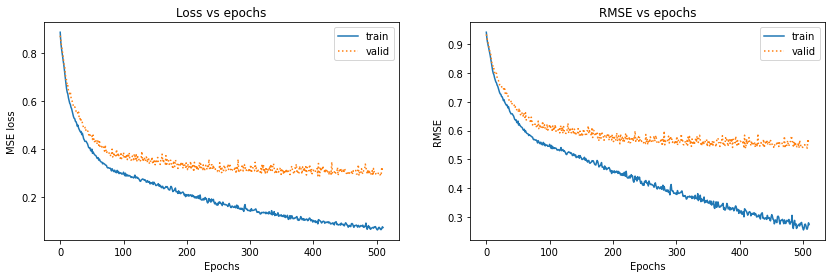

{'loss': 0.3144255578517914, 'root_mean_squared_error': 0.5607365965843201}


In [264]:
#load history from logs
small_multi_history = pd.read_csv("../saved_logs/concentrations/small_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(small_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(small_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(small_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(small_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(small_multi_mlp.evaluate(small_val_dataset, return_dict=True, verbose=0))

### VII.1.b Small correlated dataset

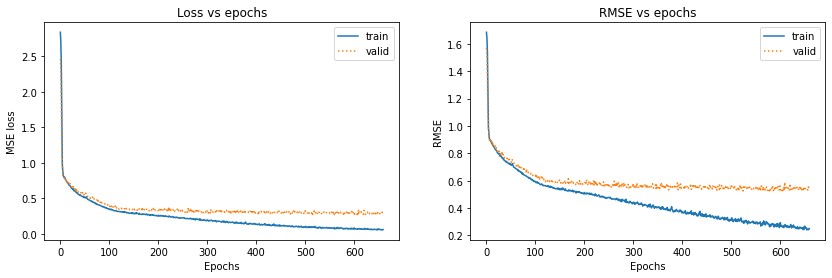

{'loss': 2.527156352996826, 'root_mean_squared_error': 1.5897032022476196}


In [265]:
#load history from logs
small_corr_multi_history = pd.read_csv("../saved_logs/concentrations/small_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(small_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(small_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(small_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(small_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(small_corr_multi_mlp.evaluate(small_corr_val_dataset, return_dict=True, verbose=0))

### VII.1.c Large independent dataset

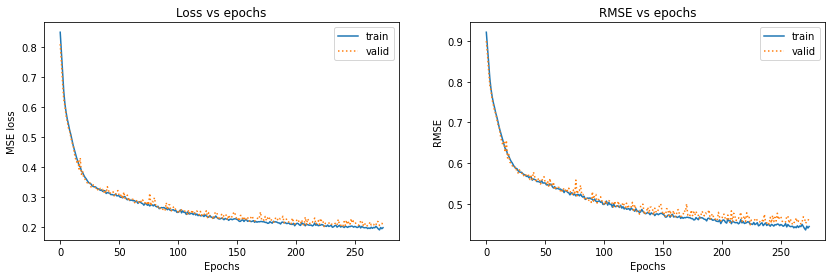

{'loss': 0.9039512872695923, 'root_mean_squared_error': 0.9507635831832886}


In [266]:
#load history from logs
large_multi_history = pd.read_csv("../saved_logs/concentrations/large_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_multi_mlp.evaluate(large_val_dataset, return_dict=True, verbose=0))

### VII.1.d Large correlated dataset

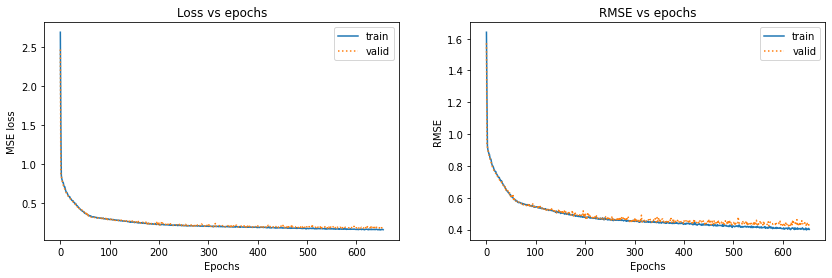

{'loss': 2.8095741271972656, 'root_mean_squared_error': 1.6761784553527832}


In [64]:
#load history from logs
large_corr_multi_history = pd.read_csv("../saved_logs/concentrations/large_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_corr_multi_mlp.evaluate(large_corr_val_dataset, return_dict=True, verbose=0))

### VII.1.e Extra small independent dataset

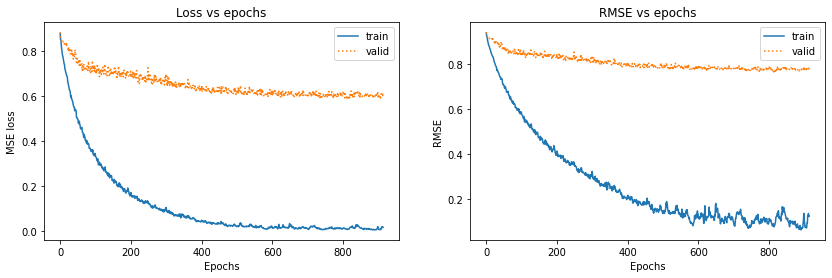

{'loss': 0.6148706674575806, 'root_mean_squared_error': 0.7841368913650513}


In [146]:
#load history from logs
xsmall_multi_history = pd.read_csv("../saved_logs/concentrations/extra_small_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_multi_mlp.evaluate(xsmall_val_dataset, return_dict=True, verbose=0))

### VII.1.f Extra small correlated dataset

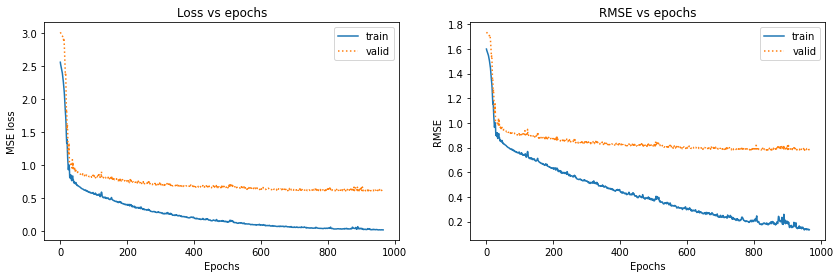

{'loss': 0.6227608919143677, 'root_mean_squared_error': 0.7891519665718079}


In [147]:
#load history from logs
xsmall_corr_multi_history = pd.read_csv("../saved_logs/concentrations/extra_small_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_corr_multi_mlp.evaluate(xsmall_corr_val_dataset, return_dict=True, verbose=0))

## VII.2 Single Output MLPs

### VII.2.a Small independent dataset

In [ ]:
#load history from logs
small_inde_histories = [pd.read_csv("../saved_logs/concentrations/small_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(small_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(small_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(small_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(small_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(small_inde_mlps[i].evaluate(small_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.b Small correlated dataset

In [ ]:
#load history from logs
small_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/small_corr_single/metabolite_{}.csv".format(i))
                             for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(small_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(small_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(small_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(small_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(small_corr_inde_mlps[i].evaluate(small_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.1.c Large independent dataset

In [ ]:
#load history from logs
large_inde_histories = [pd.read_csv("../saved_logs/concentrations/large_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(large_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(large_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(large_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(large_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(large_inde_mlps[i].evaluate(large_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.1.d Large correlated dataset

In [ ]:
#load history from logs
large_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/large_corr_single/metabolite_{}.csv".format(i))
                             for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(large_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(large_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(large_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(large_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(large_corr_inde_mlps[i].evaluate(large_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.e Extra small independent dataset

{'loss': 0.0014355189632624388, 'root_mean_squared_error': 0.03788824379444122}
{'loss': 0.0005826809210702777, 'root_mean_squared_error': 0.024138784036040306}
{'loss': 0.028286611661314964, 'root_mean_squared_error': 0.1681862473487854}
{'loss': 0.010563580319285393, 'root_mean_squared_error': 0.10277927666902542}
{'loss': 0.0004265621828380972, 'root_mean_squared_error': 0.020653381943702698}
{'loss': 0.025011906400322914, 'root_mean_squared_error': 0.1581515371799469}
{'loss': 0.3670513927936554, 'root_mean_squared_error': 0.6058476567268372}
{'loss': 0.013946162536740303, 'root_mean_squared_error': 0.11809387058019638}
{'loss': 0.05318186804652214, 'root_mean_squared_error': 0.23061193525791168}
{'loss': 1.7111485004425049, 'root_mean_squared_error': 1.3081088066101074}
{'loss': 0.24425804615020752, 'root_mean_squared_error': 0.4942246973514557}
{'loss': 0.17595522105693817, 'root_mean_squared_error': 0.4194701611995697}
{'loss': 0.008616670966148376, 'root_mean_squared_error': 0.

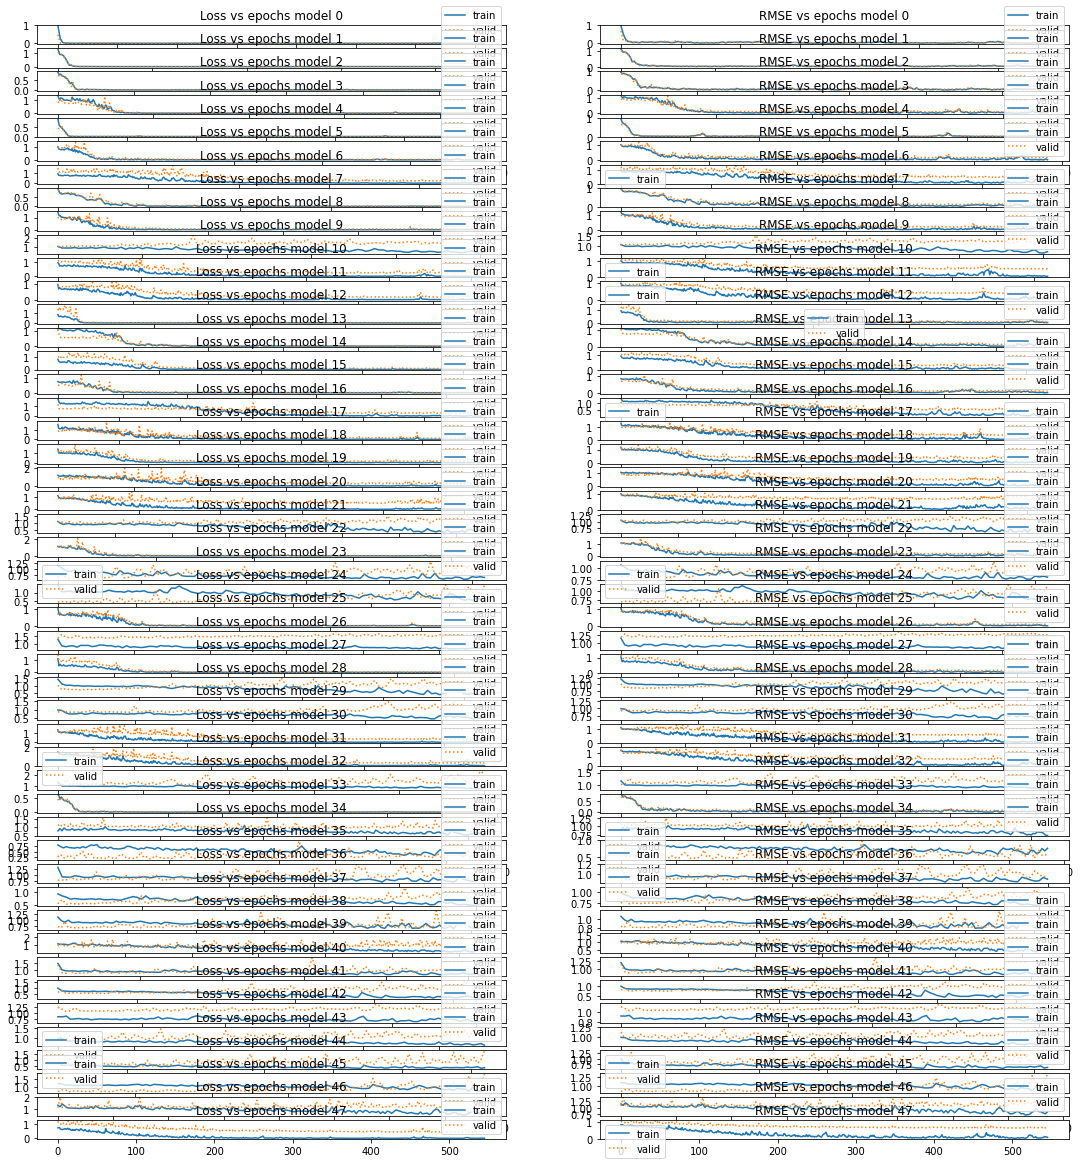

In [148]:
#load history from logs
xsmall_inde_histories = [pd.read_csv("../saved_logs/concentrations/extra_small_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(xsmall_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(xsmall_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(xsmall_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(xsmall_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(xsmall_inde_mlps[i].evaluate(xsmall_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.f Extra small correlated dataset

In [ ]:
#load history from logs
xsmall_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/extra_small_corr_single/metabolite_{}.csv"
                                          .format(i)) for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(xsmall_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(xsmall_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(xsmall_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(xsmall_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(xsmall_corr_inde_mlps[i].evaluate(xsmall_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

---
# VIII. Load saved models

## VIII.1 Multi Output MLPs

In [59]:
xsmall_multi_status = (tf.train.Checkpoint(model=xsmall_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_multi'))
                      .expect_partial())
xsmall_multi_status.assert_existing_objects_matched()
xsmall_corr_multi_status = (tf.train.Checkpoint(model=xsmall_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_corr_multi'))
                           .expect_partial())
xsmall_corr_multi_status.assert_existing_objects_matched()
small_multi_status = (tf.train.Checkpoint(model=small_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_multi'))
                      .expect_partial())
small_multi_status.assert_existing_objects_matched()
small_corr_multi_status = (tf.train.Checkpoint(model=small_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_corr_multi'))
                           .expect_partial())
small_corr_multi_status.assert_existing_objects_matched()
large_multi_status = (tf.train.Checkpoint(model=large_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_multi'))
                      .expect_partial())
large_multi_status.assert_existing_objects_matched()
large_corr_multi_status = (tf.train.Checkpoint(model=large_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_corr_multi'))
                           .expect_partial())

## VIII.2 Multi Output RFs

In [60]:
xsmall_multi_RF = joblib.load('../saved_models/concentrations/xsmall_multi_RF')
xsmall_corr_multi_RF = joblib.load('../saved_models/concentrations/xsmall_corr_multi_RF')
small_multi_RF = joblib.load('../saved_models/concentrations/small_multi_RF')
small_corr_multi_RF = joblib.load('../saved_models/concentrations/small_corr_multi_RF')
large_multi_RF = joblib.load('../saved_models/concentrations/large_multi_RF')
large_corr_multi_RF = joblib.load('../saved_models/concentrations/large_corr_multi_RF')

## VIII.3 Single Output MLPs

In [61]:
xsmall_single_status = []
xsmall_corr_single_status = []
small_single_status = []
small_corr_single_status = []
large_single_status = []
large_corr_single_status = []
for i in range(48):
    xsmall_single_status.append((tf.train.Checkpoint(model=xsmall_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/extra_small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    xsmall_single_status[i].assert_existing_objects_matched()
    xsmall_corr_single_status.append((tf.train.Checkpoint(model=xsmall_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/extra_small_corr_single/metabolite_{}'
                                         .format(i)))
                                     .expect_partial()))
    xsmall_corr_single_status[i].assert_existing_objects_matched()
    small_single_status.append((tf.train.Checkpoint(model=small_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    small_single_status[i].assert_existing_objects_matched()
    small_corr_single_status.append((tf.train.Checkpoint(model=small_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/small_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    small_corr_single_status[i].assert_existing_objects_matched()
    large_single_status.append((tf.train.Checkpoint(model=large_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/large_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    large_single_status[i].assert_existing_objects_matched()
    large_corr_single_status.append((tf.train.Checkpoint(model=large_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/large_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    large_corr_single_status[i].assert_existing_objects_matched()

## VIII.4 Single Output RFs

In [103]:
xsmall_inde_RFs = []
xsmall_corr_inde_RFs = []
small_inde_RFs = []
small_corr_inde_RFs = []
large_inde_RFs = []
large_corr_inde_RFs = []
for i in range(48):
    xsmall_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_single_RF/metabolite_{}'.format(i)))
    xsmall_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_corr_single_RF/metabolite_{}'
                                           .format(i)))
    small_inde_RFs.append(joblib.load('../saved_models/concentrations/small_single_RF/metabolite_{}'.format(i)))
    small_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/small_corr_single_RF/metabolite_{}'
                                           .format(i)))
    large_inde_RFs.append(joblib.load('../saved_models/concentrations/large_single_RF/metabolite_{}'.format(i)))
    large_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/large_corr_single_RF/metabolite_{}'
                                           .format(i)))

## VIII.5 Partial Least Squares

In [62]:
xsmall_pls = joblib.load('../saved_models/concentrations/xsmall_pls')
xsmall_corr_pls = joblib.load('../saved_models/concentrations/xsmall_corr_pls')
small_pls = joblib.load('../saved_models/concentrations/small_pls')
small_corr_pls = joblib.load('../saved_models/concentrations/small_corr_pls')
large_pls = joblib.load('../saved_models/concentrations/large_pls')
large_corr_pls = joblib.load('../saved_models/concentrations/large_corr_pls')

---
# XI. Performances:

## Plot the concentrations for a random exmple of the validation dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)

filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

metab_number = range(48)
for parsed_record in val_dataset.shuffle(1000).take(1):
    true_concentration = parsed_record[1][0].numpy()
    pred_concentration = simple_model(parsed_record[0])[0].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)

ax1.bar(metab_number,true_concentration)
ax1.set_title("True concentrations")
ax1.set_ylim(0, 14000)

ax2.bar(metab_number, pred_concentration)
ax2.set_title("Pred concentrations")
ax2.set_ylim(0, 14000)

ax3.bar(metab_number, mean_concentrations)
ax3.set_title("Mean concentrations")
ax3.set_ylim(0, 14000)

plt.show()

print(metabolites)



## XI.1. Total RMSE on independent dataset

In [199]:
inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()


inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=small_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=large_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()    


inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [200]:
models = ['MLP multi-output',
          'RF multi-output',
          'MLP single-output',
          'PLS']

training_datasets = ['Extra small independent', 'Extra small correlated',
                     'Small independent', 'Small correlated',
                     'Large independent', 'Large correlated']

total_rmse_inde = [[inde_rmse_xsmall_multi_mlp, inde_rmse_xsmall_corr_multi_mlp, inde_rmse_small_multi_mlp,
                   inde_rmse_small_corr_multi_mlp, inde_rmse_large_multi_mlp, inde_rmse_large_corr_multi_mlp],
                  [inde_rmse_xsmall_multi_rf, inde_rmse_xsmall_corr_multi_rf, inde_rmse_small_multi_rf,
                   inde_rmse_small_corr_multi_rf, inde_rmse_large_multi_rf, inde_rmse_large_corr_multi_rf],
                  [inde_rmse_xsmall_single_mlp, inde_rmse_xsmall_corr_single_mlp, inde_rmse_small_single_mlp,
                   inde_rmse_small_corr_single_mlp, inde_rmse_large_single_mlp, inde_rmse_large_corr_single_mlp],
                  [inde_rmse_xsmall_pls, inde_rmse_xsmall_corr_pls, inde_rmse_small_pls,
                   inde_rmse_small_corr_pls, inde_rmse_large_pls, inde_rmse_large_corr_pls]]

In [201]:
table_total_rmse_inde = pd.DataFrame(total_rmse_inde,
                                     index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_inde.style.set_caption("Total RMSE evaluated on simulated normal urine with independent metbaolites")

## XI.2. Total RMSE on correlated dataset

In [202]:
corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()


corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()    


corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()

corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [203]:
total_rmse_corr = [[corr_rmse_xsmall_multi_mlp, corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_multi_mlp,
                   corr_rmse_small_corr_multi_mlp, corr_rmse_large_multi_mlp, corr_rmse_large_corr_multi_mlp],
                  [corr_rmse_xsmall_multi_rf, corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_multi_rf,
                   corr_rmse_small_corr_multi_rf, corr_rmse_large_multi_rf, corr_rmse_large_corr_multi_rf],
                  [corr_rmse_xsmall_single_mlp, corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_single_mlp,
                   corr_rmse_small_corr_single_mlp, corr_rmse_large_single_mlp, corr_rmse_large_corr_single_mlp],
                  [corr_rmse_xsmall_pls, corr_rmse_xsmall_corr_pls, corr_rmse_small_pls,
                   corr_rmse_small_corr_pls, corr_rmse_large_pls, corr_rmse_large_corr_pls]]

In [204]:
table_total_rmse_corr = pd.DataFrame(total_rmse_corr, index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_corr.style.set_caption("Total RMSE evaluated on simulated normal urine with correlated metbaolites")

## XI.3. Total RMSE on abnormal independent dataset

In [196]:
abn_inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()


abn_inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                   y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                   y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                             y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                     y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                             y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                     y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()   


abn_inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [205]:
total_rmse_abn_inde = [[abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_multi_mlp,
                   abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_multi_mlp, abn_inde_rmse_large_corr_multi_mlp],
                  [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_multi_rf,
                   abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_multi_rf, abn_inde_rmse_large_corr_multi_rf],
                  [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_single_mlp,
                   abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_single_mlp, abn_inde_rmse_large_corr_single_mlp],
                  [abn_inde_rmse_xsmall_pls, abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_pls,
                   abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_pls, abn_inde_rmse_large_corr_pls]]

In [206]:
table_total_rmse_abn_inde = pd.DataFrame(total_rmse_abn_inde, index=pd.Index(models, name='Models'),
                                   columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_inde.style.set_caption("Total RMSE evaluated on simulated abnormal urine with independent metbaolites")

## XI.4. Total RMSE on abnromal correlated dataset

In [193]:
abn_corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()


abn_corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()     


abn_corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [197]:
total_rmse_abn_corr = [[abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_multi_mlp,
                   abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_multi_mlp, abn_corr_rmse_large_corr_multi_mlp],
                  [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_multi_rf,
                   abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_multi_rf, abn_corr_rmse_large_corr_multi_rf],
                  [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_single_mlp,
                   abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_single_mlp, abn_corr_rmse_large_corr_single_mlp],
                  [abn_corr_rmse_xsmall_pls, abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_pls,
                   abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_pls, abn_corr_rmse_large_corr_pls]]

In [207]:
table_total_rmse_abn_corr = pd.DataFrame(total_rmse_abn_corr, index=pd.Index(models, name='Models'),
                                         columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_corr.style.set_caption("Total RMSE evaluated on simulated abnormal urine with correlated metbaolites")

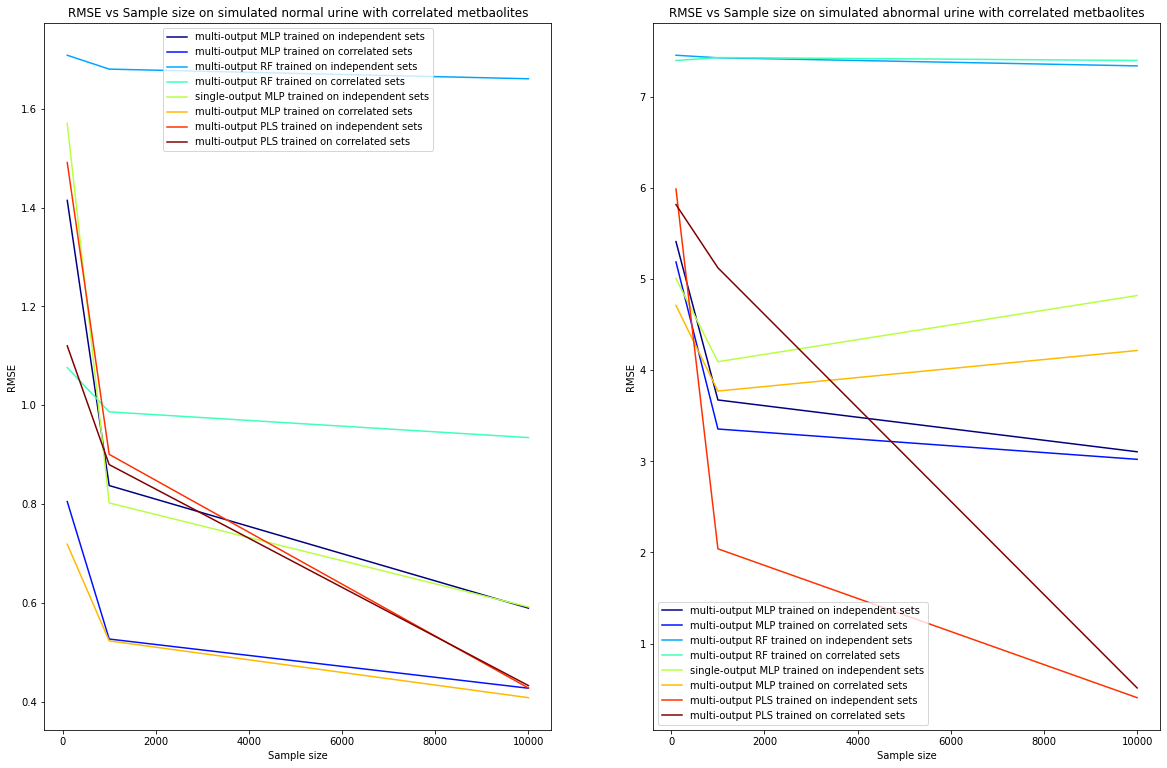

In [230]:
sample_sizes = [100, 1000, 10000]
# inde_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_small_multi_mlp, abn_inde_rmse_large_multi_mlp]
# inde_RF_multi_abn_inde = [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_small_multi_rf, abn_inde_rmse_large_multi_rf]
# inde_mlp_single_abn_inde = [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_small_single_mlp, abn_inde_rmse_large_single_mlp]
# inde_pls_multi_abn_inde = [abn_inde_rmse_xsmall_pls, abn_inde_rmse_small_pls, abn_inde_rmse_large_pls]
# corr_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_corr_multi_mlp]
# corr_RF_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_corr_multi_rf]
# corr_mlp_single_abn_inde = [abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_corr_single_mlp]
# corr_pls_multi_abn_inde = [abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_corr_pls]

inde_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_small_multi_mlp, abn_corr_rmse_large_multi_mlp]
inde_RF_multi_abn_corr = [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_small_multi_rf, abn_corr_rmse_large_multi_rf]
inde_mlp_single_abn_corr = [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_small_single_mlp, abn_corr_rmse_large_single_mlp]
inde_pls_multi_abn_corr = [abn_corr_rmse_xsmall_pls, abn_corr_rmse_small_pls, abn_corr_rmse_large_pls]
corr_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_corr_multi_mlp]
corr_RF_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_corr_multi_rf]
corr_mlp_single_abn_corr = [abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_corr_single_mlp]
corr_pls_multi_abn_corr = [abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_rf, corr_rmse_small_multi_rf, corr_rmse_large_multi_rf]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_corr_multi_rf, corr_rmse_large_corr_multi_rf]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]


colors = plt.cm.jet(np.linspace(0,1,8))

fig = plt.figure(figsize=(20, 13))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()
# fig.add_subplot(121)
# plt.plot(sample_sizes, inde_mlp_multi_abn_inde, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_multi_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
# plt.plot(sample_sizes, inde_RF_multi_abn_inde, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
# plt.plot(sample_sizes, corr_RF_multi_abn_inde, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
# plt.plot(sample_sizes, inde_mlp_single_abn_inde, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_single_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
# plt.plot(sample_sizes, inde_pls_multi_abn_inde, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
# plt.plot(sample_sizes, corr_pls_multi_abn_inde, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
# plt.title("RMSE vs Sample size on simulated abnormal urine with independent metbaolites")
# plt.xlabel("Sample size")
# plt.ylabel("RMSE")
# plt.legend()

fig.add_subplot(122)
plt.plot(sample_sizes, inde_mlp_multi_abn_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_abn_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_abn_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_abn_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_abn_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_abn_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated abnormal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

In [ ]:
sample_sizes = [100, 1000, 10000]
inde_mlp_multi_inde = [inde_rmse_xsmall_multi_mlp, inde_rmse_small_multi_mlp, inde_rmse_large_multi_mlp]
inde_RF_multi_inde = [inde_rmse_xsmall_multi_RF, inde_rmse_small_multi_RF, inde_rmse_large_multi_RF]
inde_mlp_single_inde = [inde_rmse_xsmall_single_mlp, inde_rmse_small_single_mlp, inde_rmse_large_single_mlp]
inde_pls_multi_inde = [inde_rmse_xsmall_pls, inde_rmse_small_pls, inde_rmse_large_pls]
corr_mlp_multi_inde = [inde_rmse_xsmall_inde_multi_mlp, inde_rmse_small_inde_multi_mlp, inde_rmse_large_corr_multi_mlp]
corr_RF_multi_inde = [inde_rmse_xsmall_inde_multi_RF, ande_rmse_small_inde_multi_RF, inde_rmse_large_corr_multi_RF]
corr_mlp_single_inde = [inde_rmse_xsmall_inde_single_mlp, inde_rmse_small_inde_single_mlp, inde_rmse_large_corr_single_mlp]
corr_pls_multi_inde = [inde_rmse_xsmall_inde_pls, inde_rmse_small_corr_pls, inde_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_RF, corr_rmse_small_multi_RF, corr_rmse_large_multi_RF]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_RF, corr_rmse_small_corr_multi_RF, corr_rmse_large_corr_multi_RF]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with independent metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## XI.4. Metabolite wise $R^{2}$ on independent dataset

### XI.4.a Import mean concentration data and metabolites

In [120]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.4.b Extract ground truth from validation set

In [121]:
true_val = []
for batch in test_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [122]:
inde_SS_total = tf.reduce_mean(tf.math.square(y_val), axis=0).numpy()
inde_SS_total = pd.Series(inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.4.c Multi output MLPs

In [123]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_dataset)


inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_mlp), axis=0).numpy()
inde_R_xsmall_multi_mlp = 1 - inde_SS_res_xsmall_multi_mlp/inde_SS_total
inde_R_xsmall_multi_mlp = pd.Series(inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_mlp = 1 - inde_SS_res_xsmall_corr_multi_mlp/inde_SS_total
inde_R_xsmall_corr_multi_mlp = pd.Series(inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_mlp), axis=0).numpy()
inde_R_small_multi_mlp = 1 - inde_SS_res_small_multi_mlp/inde_SS_total
inde_R_small_multi_mlp = pd.Series(inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_small_corr_multi_mlp = 1 - inde_SS_res_small_corr_multi_mlp/inde_SS_total
inde_R_small_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_mlp), axis=0).numpy()
inde_R_large_multi_mlp = 1 - inde_SS_res_large_multi_mlp/inde_SS_total
inde_R_large_multi_mlp = pd.Series(inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_large_corr_multi_mlp = 1 - inde_SS_res_large_corr_multi_mlp/inde_SS_total
inde_R_large_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.4.d Multi output RFs

In [124]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test)

inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_RF), axis=0).numpy()
inde_R_xsmall_multi_RF = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_multi_RF = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_RF = 1 - inde_SS_res_xsmall_corr_multi_RF/inde_SS_total
inde_R_xsmall_corr_multi_RF = pd.Series(inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_RF), axis=0).numpy()
inde_R_small_multi_RF = 1 - inde_SS_res_small_multi_RF/inde_SS_total
inde_R_small_multi_RF = pd.Series(inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_small_corr_multi_RF = 1 - inde_SS_res_small_corr_multi_RF/inde_SS_total
inde_R_small_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_RF), axis=0).numpy()
inde_R_large_multi_RF = 1 - inde_SS_res_large_multi_RF/inde_SS_total
inde_R_large_multi_RF = pd.Series(inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_large_corr_multi_RF = 1 - inde_SS_res_large_corr_multi_RF/inde_SS_total
inde_R_large_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.4.e Single output MLPs

In [125]:
inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_single_mlp = 1 - inde_SS_res_xsmall_single_mlp/inde_SS_total
inde_R_xsmall_single_mlp = pd.Series(inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_corr_single_mlp = 1 - inde_SS_res_xsmall_corr_single_mlp/inde_SS_total
inde_R_xsmall_corr_single_mlp = pd.Series(inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_single_mlp = 1 - inde_SS_res_small_single_mlp/inde_SS_total
inde_R_small_single_mlp = pd.Series(inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_corr_single_mlp = 1 - inde_SS_res_small_corr_single_mlp/inde_SS_total
inde_R_small_corr_single_mlp = pd.Series(inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_single_mlp = 1 - inde_SS_res_large_single_mlp/inde_SS_total
inde_R_large_single_mlp = pd.Series(inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_corr_single_mlp = 1 - inde_SS_res_large_corr_single_mlp/inde_SS_total
inde_R_large_corr_single_mlp = pd.Series(inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.4.f Single output RFs

In [ ]:
inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_xsmall_single_RF = pd.Series(inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_xsmall_corr_single_RF = pd.Series(inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=small_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_small_single_RF = pd.Series(inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_small_corr_single_RF = pd.Series(inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=large_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_large_single_RF = pd.Series(inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.4.g PLS

In [126]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test)


inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_pls), axis=0).numpy()
inde_R_xsmall_pls = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_pls = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
inde_R_xsmall_corr_pls = 1 - inde_SS_res_xsmall_corr_pls/inde_SS_total
inde_R_xsmall_corr_pls = pd.Series(inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_pls), axis=0).numpy()
inde_R_small_pls = 1 - inde_SS_res_small_pls/inde_SS_total
inde_R_small_pls = pd.Series(inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_pls),
                                                  axis=0).numpy()
inde_R_small_corr_pls = 1 - inde_SS_res_small_corr_pls/inde_SS_total
inde_R_small_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_pls), axis=0).numpy()
inde_R_large_pls = 1 - inde_SS_res_large_pls/inde_SS_total
inde_R_large_pls = pd.Series(inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_pls),
                                                  axis=0).numpy()
inde_R_large_corr_pls = 1 - inde_SS_res_large_corr_pls/inde_SS_total
inde_R_large_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.4.i Create the table

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
(summary_table_small.style
  .background_gradient(cmap=cm))

In [127]:
def color_traget(cell):
    colors = ['lightgreen' if cell[i] > 0 else 'lightcoral' for i in range(8)] + ['white']
    return ['background-color: %s' % color for color in colors]


def font_min_RMSE(cell):
    fonts = ['bold' if (1 - cell[i]) == min(1 - cell[:8]) else '' for i in range (8)] + ['']
    return ['font-weight: %s' % font for font in fonts]

In [128]:
# target = pd.Series(mean_concentrations/sd_concentrations * 0.3, index=metabolites, name='Target RMSE')

summary_table_xsmall = pd.concat([inde_R_xsmall_multi_mlp, inde_R_xsmall_single_mlp,
                                  inde_R_xsmall_multi_RF, inde_R_xsmall_pls,
                                  inde_R_xsmall_corr_multi_mlp, inde_R_xsmall_corr_single_mlp, 
                                  inde_R_xsmall_corr_multi_RF, inde_R_xsmall_corr_pls,
                                  inde_SS_total], axis=1)
summary_table_small = pd.concat([inde_R_small_multi_mlp, inde_R_small_single_mlp,
                                 inde_R_small_multi_RF, inde_R_small_pls,
                                 inde_R_small_corr_multi_mlp, inde_R_small_corr_single_mlp,
                                 inde_R_small_corr_multi_RF, inde_R_small_corr_pls,
                                 inde_SS_total], axis=1)
summary_table_large = pd.concat([inde_R_large_multi_mlp, inde_R_large_single_mlp,
                                 inde_R_large_multi_RF, inde_R_large_pls,
                                 inde_R_large_corr_multi_mlp, inde_R_large_corr_single_mlp,
                                 inde_R_large_corr_multi_RF, inde_R_large_corr_pls,
                                 inde_SS_total], axis=1)

In [129]:
summary_table_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [130]:
summary_table_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [131]:
summary_table_large.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.5. Metabolite wise RMSE on correlated dataset

### XI.5.a Import mean concentration data and metabolites

In [132]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.5.b Extract ground truth from validation set

In [133]:
true_val = []
for batch in test_corr_dataset:
    true_val.append(batch[1])
y_val_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [134]:
corr_SS_total = tf.reduce_mean(tf.math.square(y_val_corr), axis=0).numpy()
corr_SS_total = pd.Series(corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.5.c Multi output MLPs

In [135]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_corr_dataset)



corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_mlp), axis=0).numpy()
corr_R_xsmall_multi_mlp = 1 - corr_SS_res_xsmall_multi_mlp/corr_SS_total
corr_R_xsmall_multi_mlp = pd.Series(corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_mlp = 1 - corr_SS_res_xsmall_corr_multi_mlp/corr_SS_total
corr_R_xsmall_corr_multi_mlp = pd.Series(corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_mlp), axis=0).numpy()
corr_R_small_multi_mlp = 1 - corr_SS_res_small_multi_mlp/corr_SS_total
corr_R_small_multi_mlp = pd.Series(corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_small_corr_multi_mlp = 1 - corr_SS_res_small_corr_multi_mlp/corr_SS_total
corr_R_small_corr_multi_mlp = pd.Series(corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_mlp), axis=0).numpy()
corr_R_large_multi_mlp = 1 - corr_SS_res_large_multi_mlp/corr_SS_total
corr_R_large_multi_mlp = pd.Series(corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_large_corr_multi_mlp = 1 - corr_SS_res_large_corr_multi_mlp/corr_SS_total
corr_R_large_corr_multi_mlp = pd.Series(corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.5.d Multi output RFs

In [136]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_RF), axis=0).numpy()
corr_R_xsmall_multi_RF = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_multi_RF = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_RF = 1 - corr_SS_res_xsmall_corr_multi_RF/corr_SS_total
corr_R_xsmall_corr_multi_RF = pd.Series(corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_RF), axis=0).numpy()
corr_R_small_multi_RF = 1 - corr_SS_res_small_multi_RF/corr_SS_total
corr_R_small_multi_RF = pd.Series(corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_small_corr_multi_RF = 1 - corr_SS_res_small_corr_multi_RF/corr_SS_total
corr_R_small_corr_multi_RF = pd.Series(corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_RF), axis=0).numpy()
corr_R_large_multi_RF = 1 - corr_SS_res_large_multi_RF/corr_SS_total
corr_R_large_multi_RF = pd.Series(corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_large_corr_multi_RF = 1 - corr_SS_res_large_corr_multi_RF/corr_SS_total
corr_R_large_corr_multi_RF = pd.Series(corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.5.e Single output MLPs

In [137]:
corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_single_mlp = 1 - corr_SS_res_xsmall_single_mlp/corr_SS_total
corr_R_xsmall_single_mlp = pd.Series(corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_corr_single_mlp = 1 - corr_SS_res_xsmall_corr_single_mlp/corr_SS_total
corr_R_xsmall_corr_single_mlp = pd.Series(corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_single_mlp = 1 - corr_SS_res_small_single_mlp/corr_SS_total
corr_R_small_single_mlp = pd.Series(corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_corr_single_mlp = 1 - corr_SS_res_small_corr_single_mlp/corr_SS_total
corr_R_small_corr_single_mlp = pd.Series(corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_single_mlp = 1 - corr_SS_res_large_single_mlp/corr_SS_total
corr_R_large_single_mlp = pd.Series(corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_corr_single_mlp = 1 - corr_SS_res_large_corr_single_mlp/corr_SS_total
corr_R_large_corr_single_mlp = pd.Series(corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.5.f Single output RFs

In [37]:
corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_xsmall_single_RF = pd.Series(corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_xsmall_corr_single_RF = pd.Series(corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_small_single_RF = pd.Series(corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_small_corr_single_RF = pd.Series(corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_large_single_RF = pd.Series(corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.5.g PLS

In [138]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_pls), axis=0).numpy()
corr_R_xsmall_pls = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_pls = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
corr_R_xsmall_corr_pls = 1 - corr_SS_res_xsmall_corr_pls/corr_SS_total
corr_R_xsmall_corr_pls = pd.Series(corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_pls), axis=0).numpy()
corr_R_small_pls = 1 - corr_SS_res_small_pls/corr_SS_total
corr_R_small_pls = pd.Series(corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
corr_R_small_corr_pls = 1 - corr_SS_res_small_corr_pls/corr_SS_total
corr_R_small_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_pls), axis=0).numpy()
corr_R_large_pls = 1 - corr_SS_res_large_pls/corr_SS_total
corr_R_large_pls = pd.Series(corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
corr_R_large_corr_pls = 1 - corr_SS_res_large_corr_pls/corr_SS_total
corr_R_large_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.5.i Create the table

In [141]:
summary_table_xsmall_corr = pd.concat([corr_R_xsmall_multi_mlp, corr_R_xsmall_single_mlp,
                                        corr_R_xsmall_multi_RF, corr_R_xsmall_pls,
                                        corr_R_xsmall_corr_multi_mlp, corr_R_xsmall_corr_single_mlp,
                                        corr_R_xsmall_corr_multi_RF, corr_R_xsmall_corr_pls,
                                        corr_SS_total], axis=1)

summary_table_small_corr = pd.concat([corr_R_small_multi_mlp, corr_R_small_single_mlp,
                                      corr_R_small_multi_RF, corr_R_small_pls,
                                      corr_R_small_corr_multi_mlp, corr_R_small_corr_single_mlp,
                                      corr_R_small_corr_multi_RF, corr_R_small_corr_pls,
                                      corr_SS_total], axis=1)

summary_table_large_corr = pd.concat([corr_R_large_multi_mlp, corr_R_large_single_mlp,
                                      corr_R_large_multi_RF, corr_R_large_pls,
                                      corr_R_large_corr_multi_mlp, corr_R_large_corr_single_mlp,
                                      corr_R_large_corr_multi_RF, corr_R_large_corr_pls,
                                      corr_SS_total], axis=1)

In [188]:
overlapped_metabolites = [34, 47, 46, 45, 44, 43, 42, 41, 40]
well_resolved_metabolites = [i for i in range(10)]

In [189]:
summary_table_xsmall_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [190]:
summary_table_xsmall_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [187]:
summary_table_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [191]:
summary_table_large_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [231]:
summary_table_large_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.6. Metabolite wise RMSE on abnormal independent dataset

### XI.6.a Import mean concentration data and metabolites

In [145]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.6.b Extract ground truth from validation set

In [146]:
true_val = []
for batch in abn_test_dataset:
    true_val.append(batch[1])
y_val_abn = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [147]:
abn_inde_SS_total = tf.reduce_mean(tf.math.square(y_val_abn), axis=0).numpy()
abn_inde_SS_total = pd.Series(abn_inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.6.c Multi output MLPs

In [148]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_dataset)


abn_inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_mlp), axis=0).numpy()
abn_inde_R_xsmall_multi_mlp = 1 - abn_inde_SS_res_xsmall_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_multi_mlp = pd.Series(abn_inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_mlp = 1 - abn_inde_SS_res_xsmall_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_mlp = pd.Series(abn_inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_mlp), axis=0).numpy()
abn_inde_R_small_multi_mlp = 1 - abn_inde_SS_res_small_multi_mlp/abn_inde_SS_total
abn_inde_R_small_multi_mlp = pd.Series(abn_inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_mlp = 1 - abn_inde_SS_res_small_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_small_corr_multi_mlp = pd.Series(abn_inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_mlp), axis=0).numpy()
abn_inde_R_large_multi_mlp = 1 - abn_inde_SS_res_large_multi_mlp/abn_inde_SS_total
abn_inde_R_large_multi_mlp = pd.Series(abn_inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_mlp = 1 - abn_inde_SS_res_large_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_large_corr_multi_mlp = pd.Series(abn_inde_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.6.d Multi output RFs

In [149]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test)

abn_inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_RF), axis=0).numpy()
abn_inde_R_xsmall_multi_RF = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_multi_RF = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_RF = 1 - abn_inde_SS_res_xsmall_corr_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_RF = pd.Series(abn_inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_RF), axis=0).numpy()
abn_inde_R_small_multi_RF = 1 - abn_inde_SS_res_small_multi_RF/abn_inde_SS_total
abn_inde_R_small_multi_RF = pd.Series(abn_inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_RF = 1 - abn_inde_SS_res_small_corr_multi_RF/abn_inde_SS_total
abn_inde_R_small_corr_multi_RF = pd.Series(abn_inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_RF), axis=0).numpy()
abn_inde_R_large_multi_RF = 1 - abn_inde_SS_res_large_multi_RF/abn_inde_SS_total
abn_inde_R_large_multi_RF = pd.Series(abn_inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_RF = 1 - abn_inde_SS_res_large_corr_multi_RF/abn_inde_SS_total
abn_inde_R_large_corr_multi_RF = pd.Series(abn_inde_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.6.e Single output MLPs

In [150]:
abn_inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_single_mlp = 1 - abn_inde_SS_res_xsmall_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_single_mlp = pd.Series(abn_inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_corr_single_mlp = 1 - abn_inde_SS_res_xsmall_corr_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_single_mlp = pd.Series(abn_inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_single_mlp = 1 - abn_inde_SS_res_small_single_mlp/abn_inde_SS_total
abn_inde_R_small_single_mlp = pd.Series(abn_inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_corr_single_mlp = 1 - abn_inde_SS_res_small_corr_single_mlp/abn_inde_SS_total
abn_inde_R_small_corr_single_mlp = pd.Series(abn_inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_single_mlp = 1 - abn_inde_SS_res_large_single_mlp/abn_inde_SS_total
abn_inde_R_large_single_mlp = pd.Series(abn_inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_corr_single_mlp = 1 - abn_inde_SS_res_large_corr_single_mlp/abn_inde_SS_total
abn_inde_R_large_corr_single_mlp = pd.Series(abn_inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.6.f Single output RFs

In [37]:
abn_inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_xsmall_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_small_single_RF = pd.Series(abn_inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_small_corr_single_RF = pd.Series(abn_inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_large_single_RF = pd.Series(abn_inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_large_corr_single_RF = pd.Series(abn_inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.6.g PLS

In [151]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test)


abn_inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_pls), axis=0).numpy()
abn_inde_R_xsmall_pls = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_pls = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_pls = 1 - abn_inde_SS_res_xsmall_corr_pls/abn_inde_SS_total
abn_inde_R_xsmall_corr_pls = pd.Series(abn_inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_pls), axis=0).numpy()
abn_inde_R_small_pls = 1 - abn_inde_SS_res_small_pls/abn_inde_SS_total
abn_inde_R_small_pls = pd.Series(abn_inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_small_corr_pls = 1 - abn_inde_SS_res_small_corr_pls/abn_inde_SS_total
abn_inde_R_small_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_pls), axis=0).numpy()
abn_inde_R_large_pls = 1 - abn_inde_SS_res_large_pls/abn_inde_SS_total
abn_inde_R_large_pls = pd.Series(abn_inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_large_corr_pls = 1 - abn_inde_SS_res_large_corr_pls/abn_inde_SS_total
abn_inde_R_large_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.6.i Create the table

In [152]:
summary_table_abn_xsmall = pd.concat([abn_inde_R_xsmall_multi_mlp, abn_inde_R_xsmall_single_mlp, 
                                      abn_inde_R_xsmall_multi_RF, abn_inde_R_xsmall_pls,
                                      abn_inde_R_xsmall_corr_multi_mlp, abn_inde_R_xsmall_corr_single_mlp, 
                                      abn_inde_R_xsmall_corr_multi_RF, abn_inde_R_xsmall_corr_pls,
                                      abn_inde_SS_total], axis=1)
summary_table_abn_small = pd.concat([abn_inde_R_small_multi_mlp, abn_inde_R_small_single_mlp,
                                     abn_inde_R_small_multi_RF, abn_inde_R_small_pls,
                                     abn_inde_R_small_corr_multi_mlp, abn_inde_R_small_corr_single_mlp,
                                     abn_inde_R_small_corr_multi_RF, abn_inde_R_small_corr_pls, 
                                     abn_inde_SS_total], axis=1)
summary_table_abn_large = pd.concat([abn_inde_R_large_multi_mlp, abn_inde_R_large_single_mlp,
                                     abn_inde_R_large_multi_RF, abn_inde_R_large_pls,
                                     abn_inde_R_large_corr_multi_mlp, abn_inde_R_large_corr_single_mlp,
                                     abn_inde_R_large_corr_multi_RF, abn_inde_R_large_corr_pls,
                                     abn_inde_SS_total], axis=1)

In [153]:
summary_table_abn_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [154]:
summary_table_abn_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [192]:
summary_table_abn_large.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.7. Metabolite wise RMSE on abnormal correlated dataset

### XI.7.a Import mean concentration data and metabolites

In [156]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.7.b Extract ground truth from validation set

In [157]:
true_val = []
for batch in abn_test_corr_dataset:
    true_val.append(batch[1])
y_val_abn_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [158]:
abn_corr_SS_total = tf.reduce_mean(tf.math.square(y_val_abn_corr), axis=0).numpy()
abn_corr_SS_total = pd.Series(abn_corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.7.c Multi output MLPs

In [159]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_corr_dataset)



abn_corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_mlp),
                                                       axis=0).numpy()
abn_corr_R_xsmall_multi_mlp = 1 - abn_corr_SS_res_xsmall_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_multi_mlp = pd.Series(abn_corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_mlp = 1 - abn_corr_SS_res_xsmall_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_mlp = pd.Series(abn_corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_small_multi_mlp = 1 - abn_corr_SS_res_small_multi_mlp/abn_corr_SS_total
abn_corr_R_small_multi_mlp = pd.Series(abn_corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_mlp = 1 - abn_corr_SS_res_small_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_small_corr_multi_mlp = pd.Series(abn_corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_large_multi_mlp = 1 - abn_corr_SS_res_large_multi_mlp/abn_corr_SS_total
abn_corr_R_large_multi_mlp = pd.Series(abn_corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_mlp = 1 - abn_corr_SS_res_large_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_large_corr_multi_mlp = pd.Series(abn_corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.7.d Multi output RFs

In [160]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_RF),
                                                 axis=0).numpy()
abn_corr_R_xsmall_multi_RF = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_multi_RF = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_RF = 1 - abn_corr_SS_res_xsmall_corr_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_RF = pd.Series(abn_corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_RF),
                                                axis=0).numpy()
abn_corr_R_small_multi_RF = 1 - abn_corr_SS_res_small_multi_RF/abn_corr_SS_total
abn_corr_R_small_multi_RF = pd.Series(abn_corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_RF = 1 - abn_corr_SS_res_small_corr_multi_RF/abn_corr_SS_total
abn_corr_R_small_corr_multi_RF = pd.Series(abn_corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_RF),
                                                axis=0).numpy()
abn_corr_R_large_multi_RF = 1 - abn_corr_SS_res_large_multi_RF/abn_corr_SS_total
abn_corr_R_large_multi_RF = pd.Series(abn_corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_RF = 1 - abn_corr_SS_res_large_corr_multi_RF/abn_corr_SS_total
abn_corr_R_large_corr_multi_RF = pd.Series(abn_corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.7.e Single output MLPs

In [161]:
abn_corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_single_mlp = 1 - abn_corr_SS_res_xsmall_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_single_mlp = pd.Series(abn_corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_corr_single_mlp = 1 - abn_corr_SS_res_xsmall_corr_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_single_mlp = pd.Series(abn_corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_single_mlp = 1 - abn_corr_SS_res_small_single_mlp/abn_corr_SS_total
abn_corr_R_small_single_mlp = pd.Series(abn_corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_corr_single_mlp = 1 - abn_corr_SS_res_small_corr_single_mlp/abn_corr_SS_total
abn_corr_R_small_corr_single_mlp = pd.Series(abn_corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_single_mlp = 1 - abn_corr_SS_res_large_single_mlp/abn_corr_SS_total
abn_corr_R_large_single_mlp = pd.Series(abn_corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_corr_single_mlp = 1 - abn_corr_SS_res_large_corr_single_mlp/abn_corr_SS_total
abn_corr_R_large_corr_single_mlp = pd.Series(abn_corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.7.f Single output RFs

In [37]:
abn_corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_xsmall_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_small_single_RF = pd.Series(abn_corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_small_corr_single_RF = pd.Series(abn_corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_large_single_RF = pd.Series(abn_corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_large_corr_single_RF = pd.Series(abn_corr_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.7.g PLS

In [162]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_pls), axis=0).numpy()
abn_corr_R_xsmall_pls = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_pls = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_pls = 1 - abn_corr_SS_res_xsmall_corr_pls/abn_corr_SS_total
abn_corr_R_xsmall_corr_pls = pd.Series(abn_corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_pls), axis=0).numpy()
abn_corr_R_small_pls = 1 - abn_corr_SS_res_small_pls/abn_corr_SS_total
abn_corr_R_small_pls = pd.Series(abn_corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_small_corr_pls = 1 - abn_corr_SS_res_small_corr_pls/abn_corr_SS_total
abn_corr_R_small_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_pls), axis=0).numpy()
abn_corr_R_large_pls = 1 - abn_corr_SS_res_large_pls/abn_corr_SS_total
abn_corr_R_large_pls = pd.Series(abn_corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_large_corr_pls = 1 - abn_corr_SS_res_large_corr_pls/abn_corr_SS_total
abn_corr_R_large_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.7.i Create the table

In [164]:
summary_table_abn_xsmall_corr = pd.concat([abn_corr_R_xsmall_multi_mlp, abn_corr_R_xsmall_single_mlp,
                                           abn_corr_R_xsmall_multi_RF, abn_corr_R_xsmall_pls,
                                           abn_corr_R_xsmall_corr_multi_mlp,
                                           abn_corr_R_xsmall_corr_single_mlp,
                                           abn_corr_R_xsmall_corr_multi_RF, abn_corr_R_xsmall_corr_pls,
                                           abn_corr_SS_total], axis=1)

summary_table_abn_small_corr = pd.concat([abn_corr_R_small_multi_mlp, abn_corr_R_small_single_mlp,
                                          abn_corr_R_small_multi_RF, abn_corr_R_small_pls,
                                          abn_corr_R_small_corr_multi_mlp, abn_corr_R_small_corr_single_mlp,
                                          abn_corr_R_small_corr_multi_RF, abn_corr_R_small_corr_pls,
                                          abn_corr_SS_total], axis=1)

summary_table_abn_large_corr = pd.concat([abn_corr_R_large_multi_mlp, abn_corr_R_large_single_mlp,
                                          abn_corr_R_large_multi_RF, abn_corr_R_large_pls,
                                          abn_corr_R_large_corr_multi_mlp,
                                          abn_corr_R_large_corr_single_mlp,
                                          abn_corr_R_large_corr_multi_RF, abn_corr_R_large_corr_pls,
                                          abn_corr_SS_total], axis=1)

In [165]:
summary_table_abn_xsmall_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [166]:
summary_table_abn_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [167]:
summary_table_abn_large_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [126]:
print('Small: ', sum(rule_of_thumbs_small), '\n'
      'Small Single: ', sum(rule_of_thumbs_small_single), '\n'
      'large: ', sum(rule_of_thumbs_large), '\n'
      'large Weighted: ', sum(rule_of_thumbs_large_weighted))

Small:  30 
Small Single:  32 
Big:  35 
Big Weighted:  37


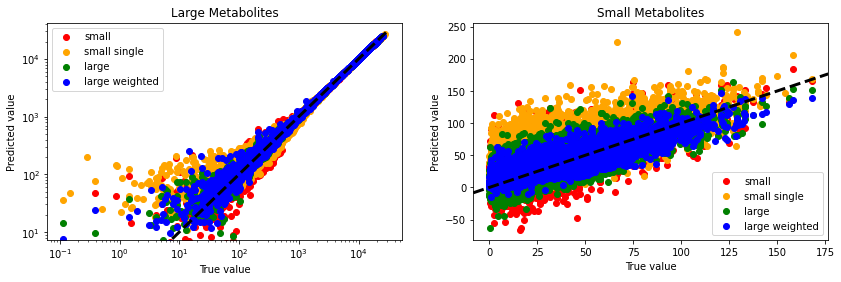

In [222]:
# Plot the scatter

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.scatter(y_val[:, :20], y_pred_small[:, :20], label='small', color='red')
plt.scatter(y_val_single[:20], y_pred_small_single[:20], label='small single', color='orange')
plt.scatter(y_val[:, :20], y_pred_big[:, :20], label='large', color='green')
plt.scatter(y_val[:, :20], y_pred_big_weigthed[:, :20], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Large Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

fig.add_subplot(122)
plt.scatter(y_val[:, 35:46], y_pred_small[:, 35:46], label='small', color='red')
plt.scatter(y_val_single[35:46], y_pred_small_single[35:46], label='small single', color='orange')
plt.scatter(y_val[:, 35:46], y_pred_big[:, 35:46], label='large', color='green')
plt.scatter(y_val[:, 35:46], y_pred_big_weigthed[:, 35:46], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.title("Small Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

plt.show()

In [189]:
y_pred_small_single

[<tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([14372.1045, 11128.471 , 11776.244 , ..., 12706.838 , 13631.113 ,
        14056.567 ], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([1515.4156, 3783.6892, 1175.2969, ..., 5105.339 , 2558.1465,
         532.5335], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([1350.7953, 1557.2172, 3807.8992, ..., 3298.5923,  786.1538,
        2558.6938], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([1920.7377, 1677.7356, 1680.204 , ...,  747.9001, 1497.315 ,
        1571.4844], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([ 489.1141, 1752.0002, 1082.9323, ..., 1407.7662, 1303.6763,
        1859.7896], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([1495.8438 , 1072.999  ,  731.1416 , ...,  495.06064,  855.86163,
         488.84534], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([

In [173]:
for dataset in big_val_datasets_single:
    for batch in dataset:
        print(batch[1])

tf.Tensor(
[14389.4  11119.6  11817.3  13577.5  15851.7   4361.94  7156.98 10117.9
 11146.3  12733.5  14963.6   9885.94 16005.   15466.7  16355.4  12744.4
 21241.6   9894.39 14982.5  10780.1  14577.8  13158.4   9082.5   8512.42
 18206.2  14113.5  11476.6  17095.2  13877.1  19502.8  15245.9  15414.8
 16140.6  15594.   19878.6  14899.   17134.   16068.7  13817.4  12172.5
  5280.15 15521.3   8295.28 15392.8  19729.4  13052.2  13675.6   9882.89
  9883.12 17093.5  12163.7   5833.39 16430.   15447.    7582.06 18337.8
 16759.4  13552.9  16266.   21239.1  13628.9  13264.3  17491.2  14711.9
 13335.9  20751.5   7433.31 18055.2   8224.91  6983.56  9122.95 13237.8
 18631.7   7199.21 12529.6  15739.   14180.2  14851.5  10085.2  14590.1
  9871.27 12051.   15607.5  16632.9   9071.82 15910.1  10928.7  11979.8
 18223.1  10934.8  12594.4  15962.8  18549.   15562.9  15008.9  11715.2
 13273.5  15868.7  21871.1  15187.5  14910.1  16327.    8474.54 14840.8
 11784.1  14467.7   5713.11 14029.2  11494.1  11276

tf.Tensor(
[1548.12  3792.31  1193.02  2766.61  1893.68  3140.08   879.856 3065.39
 3858.9   3270.48  4877.73  3006.18  2320.11  5825.73  2088.6   5626.69
 1954.46  3944.29  3728.84  1024.89  4167.26   372.887 3272.11  1221.86
  725.864 4126.77  6572.     898.947 2796.88  1007.24  2001.93  2011.87
 2562.49  4281.41  2577.69  1573.8   3703.9   2241.45  1807.27  2692.31
 2142.81  4072.71  2654.52  2607.48  2002.61  3533.14  2178.69  2541.56
 1580.14  3989.49  2917.58  3634.51  2030.61  4208.58  2110.16  1999.55
 4024.7   1416.68  2197.59  3412.05  1856.84  2114.72  3170.15  3995.8
 1798.21  3100.28  2574.61  4896.    3394.59  3633.18   815.508 2150.57
 2315.97  5128.47  1969.74   202.798 3008.74  2161.99  2942.46  4452.81
 2694.75  3790.29  2391.9   3096.26  3577.43  2216.2   2989.44   803.421
 2108.03  1082.02  3608.64  1256.05  2854.79  3823.59  3137.65  2977.19
  934.621 3092.    2338.06   630.311 1992.83  1541.13  2374.71  1733.88
 3556.1   4954.29  3515.22  2295.7   3267.27   911.06

tf.Tensor(
[1380.58  1568.99  3800.76   622.773 1351.21  3869.22  2208.84  3160.58
 1490.2    266.668 2075.44  2734.44  1631.28  2508.92  2306.88  1796.85
 1548.46  2907.29   904.68  1076.46   921.683 2093.21  2652.38  1175.7
 2022.99  1094.8   1434.72  1433.53  2686.39  4757.35  2062.42  1819.38
 1718.81  2020.71  3121.37  2393.82  2586.52   455.871 2838.23   943.724
 4086.59   553.2   1095.96  4902.24  2365.9   3895.35  1676.61   908.946
 2669.58   603.137 2866.3   2438.11  3648.    2641.19  5206.31  3052.7
 3314.58   738.299 2078.18  1194.41  1463.56  1584.23   471.801 1768.69
  941.794 1767.48  2513.53  3832.87  1698.04  3187.39  2589.77   259.212
 4060.54   716.21  1120.74  2379.81  2565.73  2002.54  3082.8   1978.68
 2986.47  1543.75  1326.02  1070.19  1279.96  1446.62  4601.1   2308.6
 1604.56  2175.44  2372.23  2182.43  2430.81   854.302 1771.61  3234.89
 2911.73  2525.12   446.766 1778.47  2735.05  2877.86  1392.82  3267.37
 1407.01   601.85   200.207 3215.85  2990.14  3016.12

tf.Tensor(
[1929.11   1588.91   1655.15   1029.55    615.106    52.0804 1174.31
 2090.64    819.366  1006.69    866.404   833.072   964.741  1298.26
 1506.01     14.5917 1475.94    920.461  1258.47   1787.73    388.135
 1203.49    105.333   628.504  1418.22   1016.94   1602.87   1524.13
  529.524  1080.9     927.86   1283.91    853.946   881.08   1016.68
  596.454   366.179  1844.37    904.107   604.919  1601.95    382.244
 1493.34    824.748  1214.17    529.875  1259.8     616.226  1289.7
  733.079  1124.42   1176.62   1544.34    807.221  1296.92   1702.69
 1575.9    1091.94    555.609   832.447  1300.19   1114.94   1412.94
 1315.      546.145   198.206   953.194   400.65   1357.65    535.372
 1155.19    881.883  1530.48   1318.69    826.329  1228.63    876.84
  646.198   811.902  1256.74    215.078   433.756   844.254   978.848
 1465.01   1216.05    586.605   769.735   932.01   1892.27   1386.24
  447.662   989.339  1261.26    967.133   388.153  1260.36    856.931
  201.966   918.843

tf.Tensor(
[ 487.977  1761.64   1089.99   1841.2    1433.2     461.559  1069.58
 1323.47   1749.01   1908.38   2642.17   1065.42   1640.94   1130.18
  779.232  3552.02   1318.02   1702.88   1159.53    324.373   514.706
 1652.79   2694.48    851.807  1075.21   1260.49    405.567  2571.74
 1379.08    589.403  1478.56   2332.72   2107.8    1751.47   1177.3
 1771.39   1517.65   2270.59   2620.19    188.003   614.184   965.133
  581.422   139.404    16.9741 1940.14    242.526   485.086  1658.44
  914.982   928.483   333.569  2020.09   2167.42   1719.85    394.018
 1253.03   1831.5     106.737  1720.18   1469.34   1683.91    704.515
 2058.22   2206.58   1376.31   1859.86   1050.64    429.205   416.005
 2297.55    907.451  1719.93    261.568   935.761  1035.9     148.631
 1976.36   2647.75   1209.01   2896.55   2094.77   1461.79   1504.47
 1897.19    536.001  1493.61    407.246   201.873  2667.54     27.633
 2037.88    573.067  1209.05   2465.19   1401.82   1026.38   1021.67
  596.501  1832.8

tf.Tensor(
[1537.56  1107.34   693.451 1121.23  1058.52   606.828 1081.52  1380.55
 1032.05   215.961 1310.74   618.585  629.856  974.882 1233.36   709.895
  788.248  669.831  812.158 1006.67   949.851 1165.79  1061.19  1456.87
  991.306 1311.25   435.085  724.363 1196.16   493.081 1095.47  1374.22
  675.71  1062.29   786.391  713.071 1438.92   990.495 1079.53   786.233
  556.261  740.883 1226.72  1457.87   828.723  310.672  575.657  800.191
  863.219  936.037  667.106  719.573 1406.75   864.171  860.141 1391.58
  918.593  791.851 1693.59   989.386 1147.99  1308.73  1498.09   834.906
 1299.51  1080.58  1168.95   575.765 1626.66   880.44  1345.95  1636.89
 1470.74   998.102  979.148  854.933  860.499  934.427 1397.68  1123.43
  805.049 1095.82  1953.54  1019.46  1311.05   699.443 1241.79  1092.95
 1374.15   965.238 1197.6   1357.55  1980.75   574.784 1145.53  1335.62
 1111.4    512.386  450.567  858.88  1023.85  1197.75   880.112  904.443
 1119.9    811.487 1149.15   237.325 1204.82  12

tf.Tensor(
[ 882.796  937.994  938.554  924.108 1052.63   911.898  998.938  923.636
  962.947  870.274 1063.01   888.036  915.202  993.72   888.828  938.464
 1005.07   907.98   839.122  896.469 1017.89  1048.     937.569  951.751
  930.727 1043.18   793.165 1073.66   931.073  965.505  816.915 1004.32
 1023.95  1052.03   865.078  865.392 1164.83   915.922  917.716  902.032
  935.073  980.255 1052.99   967.802  895.275 1099.89  1039.2    871.198
  962.289  935.807  955.348  846.319  899.894 1112.46   889.08   949.704
  733.114 1118.01   970.226  972.02   864.466  862.312  920.396 1011.93
  970.448  988.318 1034.47   788.149  901.226  897.565 1029.32  1090.56
 1037.04  1003.73   987.868  879.236  924.28   947.794  783.209  868.299
  954.593 1066.4    966.887 1048.17   917.948  874.884  967.258 1048.17
  890.091  949.197 1060.74   874.809  885.866 1030.27   912.593  836.627
  998.032  915.591 1016.87   861.195  926.394  886.591  908.94   861.777
  864.732 1041.54   955.864 1027.37   907.70

tf.Tensor(
[ 564.422  1031.65   1505.6    1041.64   1811.24   1329.15    324.091
  261.896   885.688  1341.67    535.503  1777.39   1160.24   1359.67
 1778.86   1392.36    777.029  1220.46   1000.11   1670.59   1060.71
  808.609   631.003   206.287   331.715     5.8825  248.326   310.018
 1204.4     582.161  1051.29   1288.11   1351.83    700.376   868.562
  894.316   396.887  1012.62    864.917  1433.75    932.408  1436.02
 1196.32    343.482  1646.16    890.418   966.773  1669.15   1365.11
  579.472   578.777  1398.41   1071.11   2133.74    975.162  1174.92
 1631.12     88.1721  722.378   291.093  1236.76   1099.84    769.783
  511.736  1253.38    757.457   683.656  1389.17    857.687  1627.18
  854.866   231.796   834.532   770.58    995.901  1215.61    897.354
  370.757   478.012   652.655   606.568   492.486   749.134   861.305
  137.927   779.775  1334.5    1649.33   1476.99   1229.66    755.192
 1243.31    504.598   718.155  1532.13   1492.18    680.833   330.796
  548.833   116

tf.Tensor(
[ 781.948  630.364  689.689  444.294 1011.27   512.468  562.866  866.486
  690.721  941.711  397.997 1027.45   429.332  568.483  184.791  419.427
  978.06   641.416 1050.12   581.193  655.26   812.662  504.233  653.402
  551.81   516.805  925.365  525.121  852.15   663.687  746.476  890.802
  501.051 1058.91  1032.29   963.83   992.693 1685.03  1250.44  1080.34
 1399.54   670.168  680.283  841.546 1188.74   465.349  450.043  639.528
  545.046 1040.47  1013.42   700.432  587.481  669.412 1009.76   799.322
  870.649  800.502 1096.86   689.555  920.156 1037.13   809.557 1231.2
  516.71   214.793  335.48   724.248  588.826 1068.46   947.066 1096.73
  692.973  494.54   856.309  592.058 1203.07   650.796  676.616 1041.67
  414.885  828.022  946.542  504.307  795.548  509.943  588.38   618.749
 1164.93   762.26   991.289  957.039 1209.59  1072.54  1117.62   487.17
  942.843  659.298  195.478  944.126  282.017  344.182  451.82   931.334
  609.92   677.331  644.772  211.926  732.217 

tf.Tensor(
[ 424.639    311.199    761.166    729.124    677.224    464.54
 1052.46     333.228    396.195    648.824    301.54     589.804
  530.859    344.486    582.582    408.571    400.188    341.474
 1054.9      604.868    630.401    211.955    738.115   1009.31
  553.04     407.132    590.775    411.391    553.464    682.789
   47.7864   794.372    955.996    606.724    193.443    471.405
  328.787    868.571   1073.35    1191.74     602.422    669.118
  682.484    875.691    538.205    149.277    357.657    383.154
  495.89     714.389    766.045    987.714    683.155    547.582
  211.879    459.793   1060.54    1065.65      53.8593   375.455
  710.768    742.773    774.049    752.803    968.546    136.934
  948.095    277.052    317.077    546.252    415.075    851.976
  772.067    964.173    413.522     29.3957    55.003    779.066
  355.186    452.812      8.04572  202.958    591.142    795.112
  539.602    770.108    691.196   1033.99     257.681    269.592
  183.711    436

tf.Tensor(
[322.022 462.194 462.239 557.033 664.9   588.523 627.058 456.234 329.593
 566.781 390.694 356.038 268.215 519.728 427.439 479.312 746.766 274.199
 517.399 338.901 206.501 537.206 307.592 511.572 356.135 540.71  340.597
 498.031 396.064 499.098 118.114 402.725 542.032 652.982 672.598 347.041
 421.138 912.899 747.304 543.773 625.597 694.72  628.922 458.65  313.636
 395.093 227.814 444.228 649.665 634.939 363.859 456.616 513.754 503.05
 463.809 684.163 400.007 550.707 466.923 233.573 703.974 370.459 438.239
 198.642 505.648 588.768 649.769 747.601 341.911 505.727 749.254 570.53
 757.264 364.015 210.176 641.625 411.089 876.776 512.477 470.354 352.384
 626.874 560.333 400.279 474.098 378.5   427.607 456.372 577.956 531.727
 605.189 490.289 657.556 287.663 576.388 410.071 673.864 244.68  519.258
 610.456 353.208 526.538 487.349 546.098 432.461 373.008 491.618 551.984
 594.823 515.179 542.569 469.894 292.087 326.445 597.983 238.724 210.738
 256.355 559.583 534.331 610.368 521.847 5

tf.Tensor(
[341.315 690.36  489.082 588.268 447.052 607.764 441.135 532.976 499.27
 674.967 371.247 484.517 359.323 674.255 537.507 438.854 515.454 480.31
 414.247 644.988 581.327 449.94  381.06  324.369 488.764 658.276 558.991
 405.982 359.451 452.413 436.922 470.17  591.757 434.441 512.596 509.154
 254.084 292.384 676.371 519.246 390.027 391.526 359.103 421.11  492.359
 236.24  546.904 464.05  608.171 599.304 637.462 769.797 830.698 652.067
 269.282 406.048 655.691 662.396 325.953 478.4   357.479 151.92  405.865
 502.377 510.918 275.338 195.229 318.134 454.583 338.418 344.167 447.905
 320.406 352.427 462.29  298.116 410.75  240.048 425.193 345.575 363.585
 522.059 446.647 494.71  293.718 437.338 400.154 469.601 490.516 349.351
 360.054 432.937 384.168 508.133 387.095 310.806 604.475 314.098 366.42
 273.281 403.462 395.012 541.164 267.646 461.726 543.333 597.583 363.055
 230.651 552.079 268.948 389.14  431.836 564.889 426.716 309.735 307.313
 637.807 602.42  585.919 239.486 433.7   36

tf.Tensor(
[ 464.089    62.3704  362.739   311.519   446.219   389.013   138.452
  917.535   310.6     383.185  1302.2     900.693   850.967   122.009
  238.857    23.4983  112.461   184.851   525.563  1340.6     370.489
  576.088    13.5542  187.674   259.117   765.615   627.276   441.556
  771.697  1258.54    753.902    45.8325  284.845   361.885    64.8185
  565.241   699.52   1167.69    769.413   548.995   559.236   193.047
  939.888   255.314   227.48    744.562   521.886   425.202   615.406
  798.233   677.886   345.418  1050.82    278.285   957.83    155.364
  213.044   315.295   429.423   158.094   911.508   395.196   692.267
  532.914   257.961   202.594    80.9271  915.63    856.189   256.92
   87.7109  383.68    624.083   328.909   702.688   926.185  1052.22
  596.658   640.363   323.051   155.803   365.245   286.551   881.766
  803.617    38.9638  519.968   247.089   316.088   197.672   252.872
  699.339   435.991   660.787   115.177   397.391   217.448   182.034
  144.005 

tf.Tensor(
[328.879  317.756  166.601  539.33   253.357  315.644  677.031  584.757
 131.108  371.328  222.794  224.811  417.851  223.647  361.473  595.236
 151.586  591.2    677.606  441.614  364.217  321.131  210.344  133.797
 169.38   483.799  463.616  590.982  240.569  556.436  548.072  317.71
 517.472   88.6726 155.054  661.118  445.716  489.674  231.19   504.825
 150.252  348.824  205.808  472.149  642.174  213.048  483.845  469.75
  83.6519 360.158  375.092  320.343  324.489  903.87   875.093  410.295
 164.539  531.244  411.594  585.04   336.304  424.854  189.294  367.56
 325.853  401.909  592.972  341.645  213.448  667.575  522.85   310.924
 460.568  116.351  602.984  630.89   167.684  461.255  450.54   362.34
 571.874  190.244  144.793  379.714  363.418  105.604  221.875  944.199
 470.666   69.5216 829.41   548.793  415.637  298.029  795.889  207.74
  23.9619 515.813  114.847  722.537  631.915  437.906  504.372  388.025
 679.655  601.313  309.394  432.541  658.686  251.622  309

tf.Tensor(
[215.037  310.606  374.707  741.857  493.797  407.485  271.761  646.426
 299.107  280.703  711.415  882.389  236.799  460.18   456.624   99.3315
 300.604  257.497  430.316  342.896  488.039   42.9005 434.363  560.219
  96.2012 288.866  420.063  246.823  518.981   43.693  238.462  221.693
 572.908  164.061  470.865  403.189  270.9    405.706  334.062  621.987
 165.305  292.483   73.0809 465.973   39.5809 323.714  494.848  268.751
 652.701  429.182  644.716  368.702  201.977  335.384  410.527  296.501
 210.189  546.185  488.73   343.598  370.878  356.361  606.983  321.205
 670.121  568.461  102.259  443.879  499.95    89.5885 793.661  238.904
  16.9545 192.333  341.595  294.844  325.591  626.101   68.7358 244.879
 525.722  562.409  540.226  273.886  213.876  219.207  622.128  742.651
 207.167  410.611  409.055   17.5422 385.083  505.361  520.399  229.254
 419.882  285.3     79.1417 371.816  365.369  347.032  615.085  241.508
 142.809  287.887  168.655  573.523  407.953  369.19

tf.Tensor(
[418.976   185.819   315.997   237.744   457.343   483.663   232.473
 393.569   135.597   470.199   281.974   467.615   116.45    657.56
 635.856    97.5266  468.572   388.879   361.935   927.722   171.239
 461.402   186.101   129.668   599.792   333.128   361.632   370.011
 369.654   710.342   329.17    108.629   241.541   645.264   927.767
 384.821   505.967   194.3     132.652   491.334   454.021   261.634
 678.259   226.12    459.387   102.985   265.592   254.935   350.746
 301.707   509.156   179.889   391.614   108.703   548.208   217.586
 299.066   325.727   171.658   430.859    26.9047  280.276   642.87
 150.196   432.412    56.2019  451.79    304.933   707.936   651.651
 417.928   346.417   123.585   171.657   252.189   975.705   400.65
 252.213   369.341    38.2372  415.042    36.8121  904.242   138.327
 347.529   742.537   399.314   218.17     65.086   468.696   638.479
 359.531   399.531   257.879   787.815     1.56893 473.84    164.932
 333.916   960.083   231.2

tf.Tensor(
[317.753 309.891 352.067 323.835 227.645 299.927 354.606 215.72  302.893
 352.146 276.586 379.676 411.69  336.455 345.742 285.772 383.752 323.791
 286.617 317.862 370.57  352.941 353.013 353.002 351.57  338.501 345.721
 374.463 374.42  379.01  351.243 350.853 347.667 340.949 325.703 369.005
 260.013 373.624 351.613 351.595 320.119 363.014 328.586 342.202 341.595
 363.051 333.131 324.09  295.525 366.099 296.893 344.521 366.113 309.421
 341.389 394.688 268.349 337.953 339.489 341.688 246.688 345.096 327.339
 322.512 370.978 266.199 328.21  323.92  359.965 395.049 378.524 255.47
 321.897 282.73  286.734 299.204 404.495 275.866 330.513 298.032 380.995
 329.002 404.288 318.116 383.197 264.224 287.363 358.17  310.313 335.008
 277.338 321.237 270.393 332.488 297.597 366.363 335.092 353.749 320.343
 354.873 357.651 282.194 335.575 398.962 385.754 342.159 332.536 260.871
 312.256 307.058 292.297 282.901 293.667 291.444 311.516 307.852 329.384
 311.693 292.489 307.068 331.382 351.431 

tf.Tensor(
[ 32.2644 130.34   432.419  360.301  353.436  334.775  312.232  152.298
 143.544  157.724  248.747  328.335  428.951  382.144  428.626  495.466
 230.083  330.375  415.726  123.348  460.577  164.119  325.192  417.098
 341.106  253.042  320.506  249.524  287.912  430.743  232.025  273.21
 400.376  488.534  249.92   204.43   549.555  396.461  393.402  303.936
 134.593  278.421  126.519  361.563  236.138  251.9    554.572  185.261
 114.916  416.327  220.216  144.094  522.765  537.675  379.078  586.544
 246.863  399.877  237.065  400.461  370.274  411.029  195.684  236.032
 255.989  200.346  276.342  121.415  424.53   380.524  124.163  111.935
 436.037  218.577   40.6096 355.026  410.141  173.076  225.97   394.223
 133.6    200.717  287.275   11.8426 338.894  288.807  272.478   84.5523
 364.8    389.265  273.564   17.977  335.15   248.553  110.572  578.477
 210.865  251.412  376.355  333.485  396.847  371.863  419.812  485.509
 152.93   471.322  285.085  424.26   403.95   266.523

tf.Tensor(
[382.686 236.205 303.417 265.845 469.954 522.753 362.828 359.96  397.701
 418.885 379.107 397.175 468.905 186.547 248.893 391.925 121.586 298.082
 189.432 228.691 264.099 308.519 310.181 445.957 311.19  274.442 276.556
 573.09  410.669 398.467 418.587 405.611 195.153 344.441 352.127 370.638
 251.216 378.949 319.338 402.2   259.167 224.037 310.772 149.215 274.667
 432.643 118.211 394.96  114.31  160.455 346.544 354.126 357.372 199.816
 343.185 267.601 292.255 376.894 484.324 336.631 225.087 403.834 363.101
 296.26  434.178 257.152 152.607 226.399 341.604 256.461 428.564 401.616
 278.903 371.987 395.294 339.28  143.679 451.147 276.608 412.31  168.553
 236.921 315.466 420.808 196.65  488.913 454.408 319.531 236.508 162.415
 380.067 169.153 329.504 409.245 385.912 286.991 405.108 416.87  452.176
 322.568 235.586 175.483 233.646 203.999 219.861 276.371 285.389 205.815
 360.619 268.962 375.357 392.561 360.906 190.916 370.924 303.672 391.18
 297.534 398.307 312.768 341.245 375.27  

tf.Tensor(
[289.055  240.869  213.951  281.798  289.772  212.559  338.729  390.253
 158.646  261.372  241.398  235.043  280.614  305.369  172.962  368.439
 251.33   300.04   247.37   370.027  362.515  300.371  290.7    231.307
 155.075   84.9942 342.159  335.162  339.476  355.821  178.641  166.87
 248.887  141.683  385.037  335.465  319.788  291.999  240.342  172.996
 282.087  285.742  401.81   314.525  367.327  227.338  225.744  292.316
 359.669  265.019  360.682  287.918  192.256  196.424  372.662  366.657
 319.867  272.944  359.075  260.105  291.253  245.526  357.571  205.001
 365.372  276.307  291.489  292.669  343.856  239.369  163.985  281.31
 295.71   422.107  265.052  312.962  275.592  197.783  240.483  353.934
 308.044  172.625  253.44   236.357  287.911  346.339  220.696  328.458
 257.377  337.362  240.285  403.04   268.511  332.779  328.367  233.911
 325.86   269.125  325.978  242.676  378.949  291.924  341.215  371.761
 288.977  295.897  278.022  251.431  190.255  329.314  

tf.Tensor(
[156.721  218.937  118.904  283.674  271.872  417.739  242.978  307.97
 137.244  327.811  193.473  176.473  334.516  207.704  362.865  247.476
 205.375  340.945  120.682  324.874  299.96   156.796  181.248  398.141
 265.13   286.858  231.325  210.221  179.143  165.921  275.822  135.081
 277.366  264.489  252.211  258.665  316.412   88.1952 179.543  184.09
 301.815  212.686  252.663  231.724  223.843  261.505  233.872  159.195
 102.303  293.873  202.458  255.633  321.162  287.188  364.5    410.617
 169.368  150.19   323.057  247.135  247.95   183.836  251.109  163.394
 254.073  210.996  345.045  256.74   277.542  345.924  275.039  243.406
 296.538  414.336  220.482  300.242  313.159  267.839  281.714  350.726
 310.772   81.667  266.993  105.649  185.858  234.652  211.17   256.869
 203.728  282.296  354.274  251.456  259.795   35.2041 255.269  299.392
 342.329  427.701  302.781  270.802  218.843  255.251  163.818  392.427
 300.142  199.807  300.69   185.361   93.2723 301.387  

tf.Tensor(
[223.209   272.683   394.997   338.112   322.19    291.397    90.0812
 258.677   194.537     0.95395 168.021   377.447   197.935   238.176
 223.614   350.761   180.141   293.838   465.076   341.021   396.557
 166.812   226.887   540.331   467.782   429.678   326.945   370.355
 372.617   205.676   283.179   199.793   396.537   369.916    78.7025
 148.715   192.527    87.1981  262.926   153.225    83.3069  517.562
 376.676   239.718   115.918   136.341   101.103   169.267   179.946
 477.537   189.223   323.351    32.6657  226.065   262.186   362.36
 252.653   291.939   189.397   223.815   373.014   229.679   168.774
 212.866   222.843   370.912    72.0205  405.79    461.576   145.304
  99.7276  109.617    95.3174  213.213   123.377   238.547   131.901
 325.205   248.646   352.39    383.245   337.639   228.043   347.542
 242.13    350.915   539.144   250.288   368.106   314.906   101.967
 278.025   226.846   319.541   207.348    53.6207  290.708   130.377
 213.479   208.571   1

tf.Tensor(
[227.378  233.658  276.536  162.722  105.818  256.597  384.523  245.86
 250.029  209.992  281.228  210.091  357.899  228.258  199.441  159.674
  99.5677 164.475  242.122  217.133  281.012   69.5829 351.752  230.721
 334.606  473.513  273.276  298.164  198.878  478.118  321.103  265.995
 240.324  166.5    318.241  218.442  235.673  335.691   62.7915 178.466
 374.499  106.992  348.627  256.805  249.694  172.288  265.979  367.768
 183.154  248.507   89.7192 252.793  202.011  216.823  217.314  134.815
 226.099  277.449  274.095  219.113  288.998  289.188  159.529  198.762
 277.658  114.789  205.137  216.934  213.424  246.639  192.281  231.926
 189.817  161.258  382.385  249.123  335.087  350.402  400.198  263.001
 332.126  275.131  374.744  208.423  406.241  162.214  250.519  180.49
 250.834  218.759  266.964  158.827   36.6067 239.889  183.435  292.23
 178.383  133.899   76.3911 126.455   54.4597 279.117  295.466  366.565
 310.364  180.273  305.732  123.351  396.978  216.521  2

tf.Tensor(
[191.909 213.349 231.527 243.54  202.794 196.74  247.531 203.377 232.147
 179.043 200.594 216.797 221.96  236.144 228.965 190.952 244.895 231.703
 212.967 224.953 209.809 257.574 214.042 216.958 216.89  206.815 219.352
 241.014 214.402 231.245 228.621 231.379 207.68  206.172 214.241 223.206
 222.568 222.303 155.068 215.953 242.11  226.641 220.802 163.988 199.384
 232.048 235.718 267.979 190.138 197.813 222.332 195.361 230.574 267.813
 206.741 207.054 210.132 217.861 201.553 247.7   194.791 188.838 228.153
 200.943 252.177 217.83  229.897 257.719 231.145 237.837 271.721 251.931
 263.61  264.5   208.112 208.489 200.205 221.413 187.007 248.979 210.962
 224.866 220.768 212.015 231.671 221.131 236.562 216.197 190.83  233.208
 192.356 243.068 230.759 230.516 275.085 210.217 217.637 263.286 195.627
 233.884 238.869 207.697 209.222 230.613 208.708 230.137 198.496 219.424
 210.584 261.089 204.633 206.316 197.782 242.018 226.181 213.898 232.365
 235.491 200.807 267.979 207.232 245.619

tf.Tensor(
[198.257 206.296 221.598 237.222 258.258 188.07  198.083 145.361 192.935
 200.141 211.567 206.352 127.894 259.257 197.839 142.929 169.868 215.78
 221.757 235.413 229.975 139.798 213.271 224.5   244.16  257.261 121.743
 225.39  165.142 178.237 251.255 260.306 273.676 205.166 158.371 219.03
 224.102 180.001 250.151 165.004 214.405 144.816 140.14  178.135 214.116
 288.685 176.878 200.628 129.748 166.319 246.171 191.078 238.402 164.372
 225.298 181.773 207.992 184.877 209.02  240.187 167.11  250.003 243.106
 191.461 228.526 144.061 156.228 187.703 240.55  111.857 198.008 223.511
 249.954 222.792 249.453 107.939 119.66  157.769 137.1   224.352 224.184
 246.523 205.991 239.028 184.303 173.828 155.02  160.522 202.119  85.661
 221.703 173.011 231.371 195.671 171.348 233.269 225.411 211.245 178.73
 182.977 238.701 249.393 146.876 123.803 174.52  257.149 228.189 237.797
 149.116 159.22  188.248 189.408 104.02  204.656 254.648 145.571 168.672
 143.803 237.626 236.971 186.27  287.462 14

tf.Tensor(
[  3.43903  328.787     36.2051   109.511    311.478    199.918
 178.863    390.784    253.028    394.848     82.9004   100.157
  37.8444   153.779     97.7855   186.897    174.02     135.067
 522.561     99.5045   230.405    284.319    131.806     58.3016
 395.955    272.343    315.385    620.042    213.338     86.1544
  75.0316   349.569    188.532     56.4575   242.408    270.431
 234.037    235.488    364.697    111.447    551.892    217.726
 277.759     80.5696    24.9014   293.428    166.792    451.196
 146.175     90.0034   331.737    265.675     89.3112   356.56
  99.1361   276.883    116.874    342.155    308.71     396.075
 279.628    268.76     268.046    251.283    233.675     24.7109
 115.311    131.889    105.499    214.916    145.075    220.863
 332.264    439.041    186.236    474.352     36.987    244.579
 438.212    334.195     61.3538   112.579    199.376    115.261
 307.318    247.846     56.1271   222.495    151.357    468.091
 440.975    345.461    314.

tf.Tensor(
[117.341  141.583  125.136   70.3299 203.383  148.682  102.994  211.075
 153.353  148.134   62.0141  81.0893 186.744  132.237  116.092  155.686
 109.924  141.596  170.936  229.993  212.797   66.2494 134.51   160.838
 172.722   70.6649 169.337  116.977  135.999  209.76   209.209   41.4119
 102.716  153.473  195.298  107.864   42.3972 116.991  161.668   37.7922
 110.146   72.473  142.205  136.099  119.851  230.046  142.496  181.66
 126.812   99.5237 144.143  157.807   94.033  175.809  202.377  132.713
 127.585   53.7667 102.942   89.3277 175.77   160.849   99.1764 190.756
 121.526  137.2    112.555  195.745  155.11   191.292  119.032  232.749
 224.916  264.986  154.2     42.9482  80.8236 162.125  197.879  156.784
 150.185  170.568  138.272   44.3755 133.317  114.236   95.9362 224.174
  74.6231  65.2068 164.712  152.996  127.718  209.402  222.964  121.132
 152.552  131.901  125.11   152.835  139.986   75.3234 127.573  149.895
  21.2649 116.438  161.01   167.036  155.839   99.73

tf.Tensor(
[208.496    54.5682   89.0288   82.0932   78.0712  127.16     92.4462
 163.757   190.818   117.696   217.009    21.1492   12.6403  233.89
  77.9864   27.6368  174.846   108.037     6.46822 213.974   130.169
 225.161   103.985    23.4066   82.7802   15.3659   28.853   151.828
 202.405    82.7194  157.074   124.149    84.2482   37.0507   49.9112
 115.547    36.4215  201.399   114.414    99.5063  131.006   173.548
 147.264   139.444   102.009   144.593   126.234   147.063    82.6231
 216.162    78.7151  123.911   102.472   112.943   128.862   355.285
  25.7606   57.7666    4.53489 125.85     43.3775   39.3077  129.923
  48.3871  127.203    59.8271  195.795   190.766   108.085    32.8928
  83.2458  118.344   281.898   207.86     60.7117   38.5913  135.986
 229.198   208.121   125.673    72.1386  165.659    69.971    27.6862
 117.264   110.729   182.056    40.7111  281.496   170.373    73.1246
 189.593    71.8644  349.634   174.946   222.798   159.974   246.825
  81.8335   48.851

tf.Tensor(
[151.453   58.0878  74.5235 105.158  122.041  112.445   86.796   88.056
  52.3396 123.212   89.2741  50.8311  99.1927  84.9361  63.7767  57.0495
  43.9019  34.9523  76.5394  92.4922 122.991  134.664   97.2586 101.314
 103.666  123.914   54.948  101.155   73.7296  87.2816 124.614   76.3263
  94.0421  68.1436 112.472  126.875  114.432  116.372   76.3575 119.101
 127.744   74.5509  76.4863  89.5486  99.0453  98.2985 114.841   79.1526
  89.5567  61.8517 120.329   87.6922  74.181   73.1916 103.225   78.9208
  80.7388  57.8892  93.6481 114.981   64.1286  96.0881  48.9361 107.993
  64.0747 139.785   62.971  104.405   64.6613 142.582   65.0616  50.2976
  85.9723 116.172  134.188   84.1306  80.7736 126.752   63.3045  57.5868
 139.961   28.7228 100.789  132.59   150.504  128.8     83.7846  58.2284
 107.14    88.4918  76.1771  85.9952  71.8338  38.9994  73.7719 102.868
 113.077   74.4373  79.2988 101.975  104.112   86.7002  40.9146  92.4009
 104.23   127.108   55.0342  77.5798  78.7104

tf.Tensor(
[ 65.7642  137.021    19.4938  139.295   127.745   189.91    120.974
  90.7381   39.9945   62.6094  100.428   105.856    33.6926  101.903
  36.8717  152.877    18.5703   13.7986  173.598    46.7089  116.008
  58.4475  101.568    60.0105   35.0389  163.143    87.0275    3.49943
  92.7214   16.1128   36.5447  114.42    101.206    77.3366   53.0312
  71.7152   87.6112  207.71    108.902   163.081    66.4295   92.6318
 111.021   194.067   105.603   123.425    59.7494  114.648   140.769
  87.1424   76.5752   70.0727  120.114    76.5314  125.038   114.072
  93.8389   86.3888  151.315    44.7352  105.41    122.015    55.0169
 118.494    82.8047  133.348    24.4319    8.90371  89.8491  114.973
  82.5674  137.536    54.3249  153.997    29.2188  125.145   157.265
 184.282   172.574   105.209    77.3763  161.683    46.7589  162.859
 131.664   178.246    88.1258   98.1413  100.761    52.0946  129.049
  65.2379  140.863    29.9517  176.074    79.3597  111.249    39.5688
  43.3613  205.64

tf.Tensor(
[ 81.6406 112.622  123.34    94.2416 115.722   53.7788  80.883  115.103
 102.654   27.234   63.3702  85.516   92.6633  41.3331 108.33    48.6137
  97.2463  31.3735  45.3174 110.188   44.0118 124.873   46.6512  18.2175
 115.287  144.548  111.004   54.9471  83.5694  58.2941 106.697   69.2239
  47.4866 110.954   84.5962  83.2928 119.252  122.926   85.9251  86.4039
 109.958   35.5551  95.6957  97.415   60.9587  71.4379  48.1724  81.9273
  45.9634  59.3606 129.707  149.131   96.3663 105.862  154.462  112.453
  99.3837  80.9581  83.0527 182.255  102.57   132.869   48.8509  46.1086
  48.1793 160.571   58.6189  88.4705 116.071   18.7055  67.7596  81.5989
  88.6271 138.278   67.1876  83.379   94.3144 131.787   73.9577 108.427
  89.5672  73.4256  31.1391  69.7384  89.8361  72.5575  95.1875  79.3414
  98.662  106.562   76.6445  90.2569  95.906  108.382   38.1738  82.2188
  62.9491  81.2716  98.142  106.331  129.171  104.282   85.6702 105.442
 102.391   89.0278  97.7288  52.395  128.652

tf.Tensor(
[ 58.3441   93.1779   65.8193  132.081    75.2496   57.9214   39.819
 108.32     99.7131   68.5821   69.8307  113.267    30.9009   38.8518
 138.707   139.12      8.09219  94.6349   28.4045   47.5367   21.8686
 107.698   115.815    69.0528   88.3286   39.0942   51.4939   65.3115
  55.6276   64.3395   80.8036  102.813    25.8831  132.584   126.354
  57.0137   97.8265  167.876   103.563    70.0573   74.1342   77.0761
 104.571    69.1131  116.046   111.821    53.3318   47.0274   67.4586
  58.5519  154.346    93.0299  111.946    21.3739   69.0143  142.24
  91.8609  112.504   122.841   141.959    50.6863   76.4906  103.815
  70.4992  109.299    85.6609   76.1597  108.842    25.6041  115.302
  96.9051  104.182    57.0649   78.8461  113.337    75.4321   10.0203
  31.4139  120.847    83.9641  101.659    19.554    57.9191   49.3875
  86.6799  143.389    68.0125  132.293    93.7673   93.4064   87.4674
 104.541    14.2977  103.67     48.3408    4.24781  59.3342   73.5679
 107.185    82.

tf.Tensor(
[ 67.4345   87.6545   44.9956   65.788    84.2025   30.6802   93.9121
  69.7671   66.2563   53.2885  108.909   103.843   106.951    87.3243
  16.413    79.2434  113.601    22.3915   81.3798   67.5663  140.057
  73.7552   91.7623  133.772    53.8475  107.948    50.4436  156.804
  17.6546  136.356    48.1412  105.809    79.4957   67.5752   62.2878
  79.5947   42.1919   87.3664   22.6905   10.508    65.166   102.085
 179.284    69.9227   70.4824   56.6257   36.1238  117.327    85.7523
 134.292    41.1366  111.111    88.8239   65.031    54.5838   66.8852
  56.0934  138.559    21.0159   40.9019  168.509   170.697    96.2216
  95.4104   80.894    95.6626   11.9049   75.417    75.8035  160.581
  73.9028   20.9968   73.5295  118.531    34.9704   39.1043   47.456
  68.8602  122.535    66.944    55.6449   70.7371   38.2932   86.0998
  57.924    79.6214  149.688   101.541    96.0208  107.248    21.2793
  75.1197   66.8345   92.2129   61.9559  120.764   150.551    56.6232
  30.556    68

tf.Tensor(
[1.52100e+00 6.19626e+02 4.74676e+01 6.10075e+02 7.38901e+02 5.69440e+02
 4.73558e+02 1.60616e+03 1.06983e+02 1.67937e+02 5.52888e+02 2.27806e+02
 3.45492e+02 5.64799e+02 1.83904e+02 7.89212e+02 2.94457e+02 1.27002e+02
 1.01884e+03 2.45660e+02 2.01428e+02 7.44640e+01 6.84562e+02 8.17202e+01
 5.44241e+01 9.61996e+02 3.36949e+02 3.58660e+02 8.56561e+02 8.74091e+01
 3.05564e+02 8.59942e+02 4.07502e+02 1.97106e+01 7.15841e+02 1.06444e+02
 6.93581e+01 3.40574e+02 2.21984e+02 1.68554e+02 7.56120e+01 5.36449e+01
 1.00689e+03 5.17420e+00 1.98026e+00 3.34860e+02 6.88236e+02 6.36979e+02
 6.54197e+02 7.45557e+02 9.22800e+02 3.00293e+02 1.32310e+02 3.28529e+02
 3.12156e+01 5.47327e+02 7.61860e+02 4.28617e+02 9.14386e+02 5.14760e+01
 9.63420e+01 7.44746e+01 2.66772e+02 2.85830e+02 8.48749e+02 1.86654e+02
 1.46135e+02 5.84985e+02 2.67429e+02 5.55414e+01 3.63665e+02 1.94405e+01
 1.95304e+02 8.91266e+02 7.41967e+02 4.07355e+02 4.48335e+01 3.15538e+02
 1.14781e+02 5.81466e+02 7.67852e+01 2.1

tf.Tensor(
[58.3169 55.5918 54.1123 62.7749 56.4847 52.6978 58.715  56.3627 56.5231
 46.8522 55.0673 56.886  60.277  58.6981 47.379  58.2853 53.7012 55.2265
 41.4842 44.0652 47.9536 46.519  60.7554 55.724  50.4675 52.9576 61.0057
 67.1425 55.7532 55.7329 48.6597 68.6377 63.236  62.3227 59.2748 51.6658
 58.2596 61.9563 57.1248 61.9807 65.309  58.8395 50.1529 54.8473 46.7851
 63.381  41.1403 55.6192 48.7554 53.1924 61.7933 57.136  53.999  57.6422
 54.2094 52.2326 62.7226 54.6112 52.665  51.0551 55.2682 55.9927 60.8135
 49.3146 57.0356 48.0406 51.8151 57.0597 56.7615 52.6004 56.8633 52.9192
 55.389  59.3872 52.3777 51.4692 56.3536 51.3919 57.0222 54.7701 61.5272
 57.6121 42.6858 60.0566 43.5505 48.1001 64.1542 49.6022 48.6271 56.5001
 49.7344 58.8475 53.2478 56.5692 43.0854 61.8713 53.6427 49.3408 61.1163
 53.7727 53.8618 51.2981 53.1733 58.4359 58.7513 52.3743 64.0136 66.4026
 52.3952 56.0044 51.9017 60.302  53.7321 58.7873 56.1731 57.3477 53.8305
 59.0383 57.832  63.7711 50.6406 43.1777

tf.Tensor(
[ 26.0275   51.5077   43.0516   46.6497    1.25477  71.7682   82.1817
  15.7425   53.9759   77.3964  106.019    72.297    76.6962   84.4493
  17.132    56.2176   40.5047  128.98     65.4282   13.2896   73.4405
  11.9955   57.4595   77.1589   18.9077   51.2932   22.7706   27.1383
  52.3306   42.9999   12.66     61.315    39.7871   80.9906   46.3065
  42.0851   46.0118  106.856    99.307    38.9396   54.0944   48.484
  25.4544   49.4836   65.6414   61.6747   51.5122   40.394    30.0119
  49.7626   29.1528  144.071    27.7532   49.9817   18.4486   77.8894
  46.0811   20.643    33.7916   16.0137   57.1345   44.3357   14.8054
  63.738    64.2557   39.5592   87.4701   65.8905   78.5142  116.442
  72.4325   32.4804   38.9932   44.6728   44.4227   52.4898   60.3251
 130.491    57.8293   50.1913   34.834    53.7244   55.7618   25.8911
  30.507    53.816    64.3995   78.5109  107.55     44.6326   95.4306
  62.6351   86.2756   43.6939   52.8338   59.7604   87.35     66.4023
  75.2028  

tf.Tensor(
[37.4402 49.7649 62.426  34.3574 33.6037 41.3011 52.4047 32.0029 33.973
 35.8751 47.4779 37.6952 22.8837 29.1832 45.9571 33.299  44.1798 34.4899
 30.1385 39.1283 29.5648 45.9992 35.3777 32.2088 30.8328 34.8439 33.8153
 38.688  31.3025 35.1868 39.6323 34.3257 25.6415 44.8959 37.673  62.9223
 36.9668 46.2966 50.6393 29.114  28.4664 35.2184 45.4953 48.9805 35.7639
 27.6033 44.6923 37.8005 37.786  38.1493 25.9336 41.0872 45.8517 33.864
 48.26   41.0168 39.4934 38.0909 32.0868 44.2988 47.2864 27.1845 52.5017
 20.4975 33.9716 26.05   32.4975 32.9115 35.0578 55.3052 46.3375 38.5898
 36.1397 48.792  37.0558 43.3787 29.3669 20.3457 35.7647 47.1142 49.4629
 52.8677 34.0405 25.7093 46.9927 54.6574 30.2365 51.7861 51.5653 12.5539
 32.1124 29.3504 49.7242 35.8107 51.5647 41.2618 47.8795 43.7938 41.3984
 39.3408 44.256  29.6502 33.5028 36.1021 48.5461 40.682  36.1778 15.8689
 15.6827 23.1007 49.6322 37.4141 23.1143 37.1031 43.9637 27.3374 57.3577
 49.5501 36.9881 28.0567 33.2763 31.2514 5

tf.Tensor(
[ 39.5731    11.645     14.4671    19.4232    13.7341    51.7074
  61.217     39.5169    16.8721    13.2944    28.1004    10.5959
  37.0616    41.6361    17.7249    30.5191    20.0998    32.3369
  27.0613    76.8082    37.8713    65.9608    57.4338    60.5031
  15.0537    12.8582     5.59418   20.5609    53.7296    37.2477
 101.491     23.2569    25.711    112.072     22.1438     3.09108
  28.3826    53.863      0.612449  55.6881    74.7188     5.00672
  49.7113    18.9861    21.5417    16.5508    70.1906    18.6993
  60.7876    75.8001    52.9827     0.595009   1.74889   36.7058
  72.6174    29.3551     5.72439   50.4578     8.19029   86.9214
  94.9894   122.48      39.3932    63.1431    11.3572    67.2919
  33.8154     9.92343   43.3782    56.9626    42.1493    13.1838
   3.06735   52.0293    51.0107    17.0658   108.305    107.641
  44.2179    70.4592    44.3774    70.0132    92.3927    61.3083
  73.3174    35.4858    30.2857    25.5286    25.5601    43.807
  43.8515    7

tf.Tensor(
[61.3226    5.98693  49.0246   40.9948   41.7277   24.45     48.4932
 62.9845   20.2723   49.6739   21.68     55.4255   33.7627   49.2777
 29.386    36.5295   16.4045   23.3519   23.6885   67.5712   20.4773
 45.95     75.6847   22.4819   23.4186   47.5707   54.8552   12.2258
 21.0987   26.1745   15.4291   18.1712   16.0439   45.3389   21.6053
 24.9895   42.8481   27.1001   31.7404   23.344    29.2559   51.2489
  6.298     9.58959  36.1813   17.8377   47.4199   34.3715   13.8504
  6.44929  31.8848   27.5884   19.1683   57.69     36.6267   36.293
 25.1169   46.1004   18.954    20.3264   44.0974   32.3293   32.497
 22.4702   58.8152   28.8091    5.45967  36.6223   29.6401    0.234228
 26.933    15.3633   27.0878   40.0973   48.417    18.5395   46.9298
 26.4234   25.8472   43.1344   17.1786   17.2497   49.5636   21.1759
 23.5564   36.549    29.2207   46.4308   42.7227   42.6496   37.44
 39.3953   32.4354   19.3129   23.7989   51.6488    3.69077  67.0125
 45.1016   18.3841   68.3

tf.Tensor(
[35.0988  27.9063  25.3924  41.1618  12.8093  34.4544  39.2848  28.9235
 23.2397  36.6748  26.6528  29.8575  35.2405  30.0747  48.3264  37.7653
 27.7539  23.6265  30.0154  15.7388  23.7171  20.4594  26.8852  18.7199
 34.4466  36.6156  47.6857  41.0993  17.4266  37.5935  48.5491  39.4368
 24.316   46.3762  22.7806  26.3105  25.794   17.9258  24.9112  23.3772
 24.4676  51.6998  45.4812  18.3596  23.8845  38.2935   1.70804 49.1228
 35.8518  13.1585  18.3729  22.4981  36.4132  27.5996  27.8628  47.7436
 27.123   35.0188  44.6387  28.0433  30.4891  45.5994  23.9896  26.8645
 31.7432  27.244   27.5418  27.5283  41.2437  29.4051  41.3456  10.7356
 38.6907  23.2813  20.7261  27.6324  34.8942  40.3397  42.6739  34.4373
 27.3814  24.8839  42.7403  11.8673  47.9733  33.1493  26.032   41.5695
 37.4124  21.1777  27.7954  53.9197  44.1942  28.4658  35.6909  31.6902
 19.3432  24.7009  25.9909  17.0919  28.7561  36.289   33.3405  38.6783
 44.5052  32.6289  22.3992  30.8658  37.497   30.2205

tf.Tensor(
[11.9796  20.634   23.9537   8.64259 22.7506  25.2657  24.9253  17.6804
 31.0321  22.4205  34.9872  29.6365  14.2854  37.9025  18.6846  15.309
 21.0262  18.8486  25.6508  23.2476  21.795   16.8946  11.9518  26.8661
 15.5967  25.4125  32.3254  25.0619  18.9269  20.306   29.3357  25.3755
 23.3126   8.87692 35.453   15.6     28.8076  17.1719  25.2612  20.6573
 30.6975  28.4428  22.1892  16.9983  21.8241  19.7371  24.1547  22.2088
 21.5049  26.6479  16.6531  22.0414  22.7731  25.5639  24.9043  21.7816
 42.7411  15.4937  23.5187  12.6639  28.672   26.0665  27.5627  21.7478
 28.7185  17.6932  28.1197  19.7559  21.952   19.3234  28.7185  37.532
  6.19459 20.8442  16.426   32.7887  23.7473  24.0959  25.1668  27.078
 14.1636  17.1812  18.8529  21.9077  27.2723  16.5128  21.134   17.9897
 13.4674  19.0946  28.1047  14.0304  32.5657  20.303   23.1526  23.0808
 17.0673  21.9128  33.5772  12.7206  30.8965  32.044   26.9252  28.6987
 16.7544  28.2448  17.8952  19.3876  21.5526  15.0233  2

tf.Tensor(
[16.9346  17.4775  18.2211  35.1419  27.038   24.8132  32.3824  16.7143
 23.2707  14.49    12.0305   3.34425 26.0039  41.2297  18.9425  32.4911
 13.1334  30.1269  34.7013  22.5453  26.9366  17.6374  36.4762  40.1258
 22.5376  24.4512  27.4368  24.3857  16.6853  10.7094  41.5432  38.1836
 16.5064  11.1045  28.7466  15.7759  23.4524  30.7872  19.6051  27.2487
 16.1159  18.286   13.0603  42.2402  18.3644   9.55902 27.7754  41.0982
 26.1972  27.0786  27.064   30.0549   5.22139 15.0009  33.149    9.52482
  0.98567 23.7969  16.0324  17.8477  32.0773  32.3634   7.33012 15.9391
 26.5601  32.6752  19.6645  26.5688  22.8057  17.313   27.9091  15.0639
 22.4219  30.5796  21.6012  36.2336  20.2091  22.1652  17.7314  13.2142
 12.8421  19.3405  23.5215  37.3888  30.7217  12.1231   6.77839 20.3438
 24.1259  16.4545  16.0642  30.0081  20.8017  33.3219  34.4698  27.1136
 11.7864  33.1576  50.0023  26.8931  23.1088   9.88761 20.4318  19.7311
 32.3101  12.6908  20.669   26.2189  19.4198  26.723

tf.Tensor(
[22.2269  16.377    0.98254 16.7931  15.3066  10.822   34.5722   9.52835
  6.19482 14.2699  12.7949  19.922    5.05968 23.5476  14.0112  17.3275
  8.88688  5.30346 17.2745  17.2659  13.2722   7.52291  6.24932 18.2341
  4.617   10.143    7.88683 27.7951  12.1474  11.3129  23.8429   7.36831
 13.057    9.31882 15.3535  17.8467  18.8596  20.6141  12.5582  10.6807
 20.048   14.6971  14.2282  13.27    23.7541  21.033   14.7674  21.3218
 14.6028  15.9803  11.484   27.4111  17.0884   4.52393 23.261   16.1774
 17.5761  18.5343  24.9004  10.6919  16.0876  19.69    13.0547  13.26
 12.1607  21.8735   8.27756 13.8459  19.8171  13.6338   7.94848  6.97476
 32.3599  13.4766  13.8521   7.4963  13.5202  11.5254  23.9966   7.07204
 16.5871   4.45796 18.1554  14.9284  16.9135  20.2376  16.8632  17.9662
  4.2225  23.1988  11.4316  19.6852  17.6468  14.1847  16.9844   5.44414
 16.4753  14.9729  20.5679  16.968   14.5573  19.527   13.1028  30.6266
 19.568   18.4335  13.8256  14.7884  15.1786  18.2

tf.Tensor(
[10.7327   8.62528 10.7887   5.90643  5.38182  7.88364 16.1089  13.6659
 12.0581   8.85044 10.2792   4.66992  6.91519 11.502   12.6791   8.27015
  8.87075  4.38655  9.1468   6.35574  5.28319 10.1121  11.2058   6.90532
  8.91879  3.37513  7.82437  6.82831  9.93674  6.37777  8.87371  8.7651
  7.12442  5.70674 10.9056   4.74447  8.75058 12.0293   4.6358   5.48104
  7.83055 11.6766   6.57715 10.9698   7.3719   4.60818 11.18    12.7452
 10.3525   3.51285  4.57561  6.96423  4.96611  4.75585  8.7961   4.87611
  9.05282  8.5499   8.60824  9.95843  7.88545  9.40239 17.3109   7.2281
  7.5211  11.5657   4.36142  4.59529  4.07758  4.29954  9.80163 10.2919
  9.39903  9.95028 11.5949   9.91642  6.76901  8.38389  3.77096 10.7229
  2.93992 11.0916   6.37306  7.93599  6.60378  5.87852  7.1274   9.98641
 13.3028   5.2065  11.3813   5.02216  5.20801  7.69795  5.92728 13.7576
  9.49948  5.54585  8.93744  3.20297  7.59059 10.8214  10.5489   9.38431
  2.26968  7.57502  7.27332 10.6305   9.39471 1

tf.Tensor(
[9.28610e+00 4.01304e+00 2.03077e+00 3.38727e+00 1.39077e+00 1.07227e+01
 7.22546e+00 1.25775e+01 3.75245e+00 4.27446e+00 5.93301e+00 6.32921e+00
 4.70364e-01 4.13975e+00 4.76607e+00 1.59622e+00 2.90180e+00 1.42028e+01
 7.95451e+00 1.85662e+00 5.24745e+00 1.09801e+01 1.71822e+00 2.34707e+00
 7.14765e+00 5.79501e+00 1.04909e+01 2.11916e+00 8.69993e+00 4.23828e+00
 1.65789e+01 1.19456e+01 4.16379e+00 9.33460e+00 3.79810e-01 4.05364e+00
 3.44328e+00 7.86899e+00 5.52619e+00 2.08565e+00 2.00069e+01 1.16473e+01
 2.30010e+00 6.45226e+00 1.20431e+01 1.13874e+01 4.38013e-01 1.40878e+01
 8.69980e+00 5.15682e+00 9.49604e+00 2.22074e+00 2.25059e+00 3.08111e-01
 1.23589e+01 4.50569e+00 7.00719e+00 9.49398e+00 1.86868e+00 8.29266e+00
 1.17703e+00 1.68076e+00 8.38104e+00 5.75837e+00 5.27232e+00 4.35747e+00
 7.93502e+00 5.44719e+00 7.49584e+00 1.16328e+01 1.30118e+01 9.40900e+00
 6.05251e+00 6.22882e+00 2.94050e+00 9.25954e+00 1.17880e+01 5.03312e+00
 1.63276e+00 9.75013e+00 1.67078e+00 2.1

tf.Tensor(
[1.29298  2.33017  1.55968  2.43558  1.8675   5.85425  3.88737  3.22854
 4.19523  5.64715  2.69331  5.26988  2.50789  2.79268  3.75261  4.69764
 1.79105  4.94048  2.14456  3.29463  3.67465  3.01209  3.6347   1.82404
 4.06843  3.06705  3.57216  1.80016  2.70395  2.90629  2.16984  0.559632
 4.47001  3.78889  2.58606  2.923    2.87693  1.58539  4.86245  3.16502
 2.74102  3.58677  2.25129  3.66222  3.03164  3.16983  4.36759  1.64597
 2.83851  3.28018  0.496653 4.47344  5.3173   2.31013  4.36725  4.14439
 3.63988  5.09839  4.66771  2.45242  3.12771  0.707516 2.29551  3.41346
 4.51813  3.27135  1.75796  3.15193  3.36902  3.65837  3.60208  2.45525
 3.85806  0.961016 2.11692  2.1424   3.52309  4.07558  2.31162  3.59837
 1.93088  3.53072  4.16266  1.87761  1.62665  2.91573  3.39314  3.58339
 2.29343  3.44812  4.79379  3.16658  3.17523  2.29803  3.13432  2.96315
 2.87111  4.59869  2.17978  1.85194  4.71114  1.59935  2.86046  1.45118
 2.87226  3.42002  3.39515  2.63461  3.47554  3.9551

tf.Tensor(
[1.1175   0.957356 1.29988  0.986477 1.10314  1.25542  1.27912  1.05568
 1.16472  1.27034  1.27834  1.18486  1.21358  1.05406  1.12093  1.24205
 1.35253  1.11758  1.01946  0.985278 1.25892  0.993533 1.06703  1.10655
 1.12812  1.18205  0.984303 1.05085  0.8816   1.14003  1.1423   1.2451
 1.16418  1.01177  1.0196   1.1078   0.988299 1.24237  1.11228  1.16177
 1.22587  1.00043  1.29404  1.14219  1.14615  1.13957  1.21279  1.04112
 1.14908  1.20489  1.40895  1.0775   1.24506  1.01107  1.10327  1.06231
 1.16289  1.2837   1.13649  1.04427  1.02021  1.14867  1.31423  1.09153
 1.15566  1.17493  1.3256   1.12871  1.35457  0.981081 1.13448  1.17228
 1.09119  1.29903  1.24618  1.07732  1.01366  1.28017  1.25896  1.28279
 1.1553   1.08673  1.20935  1.20748  1.2517   1.28383  1.10726  1.28181
 1.23219  1.27357  1.13706  0.943697 1.23242  1.25082  1.00628  1.0467
 1.15488  1.31115  0.841716 1.084    1.16747  1.0486   1.1694   1.19065
 1.06499  1.44491  1.06384  1.11764  1.13234  1.35805  

tf.Tensor(
[369.164  365.973  405.652  344.143  663.684  395.739  390.836  465.793
 528.831  342.112   30.1545 530.632  481.897  492.179  549.653  463.544
 611.68   282.757  685.418  126.769  661.328  510.374  175.956   64.8308
 469.819  368.964  854.882  427.615  357.676  244.594  393.059  276.446
 207.806  414.95   324.334  523.974  453.415  635.186  207.44   293.354
 270.779  215.892  275.968  371.263   96.4432 180.175  568.372  367.142
 478.543  464.588  223.564  422.346  431.396  473.918  321.561  399.526
 280.948  587.999  169.372  395.214  434.425  221.303  198.112  208.779
 450.245  618.964  194.094  336.046  260.477  425.29   383.947  813.425
 607.854  217.369  376.524  473.884  586.707  214.447  615.411  401.376
 420.633  326.815  880.247  378.436  464.727  323.864  347.322  465.944
 432.501  173.286  865.667  441.438  579.295  550.792  365.835  555.481
 367.952  514.749  430.853  232.797  187.271  592.616  227.515  485.427
 740.884  508.634  611.297  164.183  588.787  110.69

In [178]:
y_test_big.shape

(2000, 48)

In [186]:
big_val_datasets_single[i]

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.float64)>

In [197]:
y_val_single = []
for dataset in big_val_datasets_single:
    true_data = []
    for batch in dataset:
        true_data.append(batch[1])
    y_val_single.append(tf.concat(true_data, axis=0).numpy())

In [204]:
y_val[:, 0]

array([14389.4 , 11119.6 , 11817.3 , 13577.5 , 15851.7 ,  4361.94,
        7156.98, 10117.9 , 11146.3 , 12733.5 , 14963.6 ,  9885.94,
       16005.  , 15466.7 , 16355.4 , 12744.4 , 21241.6 ,  9894.39,
       14982.5 , 10780.1 , 14577.8 , 13158.4 ,  9082.5 ,  8512.42,
       18206.2 , 14113.5 , 11476.6 , 17095.2 , 13877.1 , 19502.8 ,
       15245.9 , 15414.8 , 16140.6 , 15594.  , 19878.6 , 14899.  ,
       17134.  , 16068.7 , 13817.4 , 12172.5 ,  5280.15, 15521.3 ,
        8295.28, 15392.8 , 19729.4 , 13052.2 , 13675.6 ,  9882.89,
        9883.12, 17093.5 , 12163.7 ,  5833.39, 16430.  , 15447.  ,
        7582.06, 18337.8 , 16759.4 , 13552.9 , 16266.  , 21239.1 ,
       13628.9 , 13264.3 , 17491.2 , 14711.9 , 13335.9 , 20751.5 ,
        7433.31, 18055.2 ,  8224.91,  6983.56,  9122.95, 13237.8 ,
       18631.7 ,  7199.21, 12529.6 , 15739.  , 14180.2 , 14851.5 ,
       10085.2 , 14590.1 ,  9871.27, 12051.  , 15607.5 , 16632.9 ,
        9071.82, 15910.1 , 10928.7 , 11979.8 , 18223.1 , 10934

# Interprete MLP

In [268]:
def saliency_map_multi(model, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(spectrum)
        preds = model(spectrum[tf.newaxis, ...])
        preds = tf.squeeze(preds)
        metabolites = [preds[i] for i in range(48)]
    sms = []
    for i in range(48):
        grads = tape.gradient(metabolites[i], spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

def saliency_map_single(models, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    sms = []
    for i in range(48):
        model = models[i]
        with tf.GradientTape() as tape:
            tape.watch(spectrum)
            preds = model(spectrum[tf.newaxis, ...])
            preds = tf.squeeze(preds)
        grads = tape.gradient(preds, spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

In [281]:
df_spectrum_metabolites = []
for i in range(4):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))
for i in range(45, 47):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))

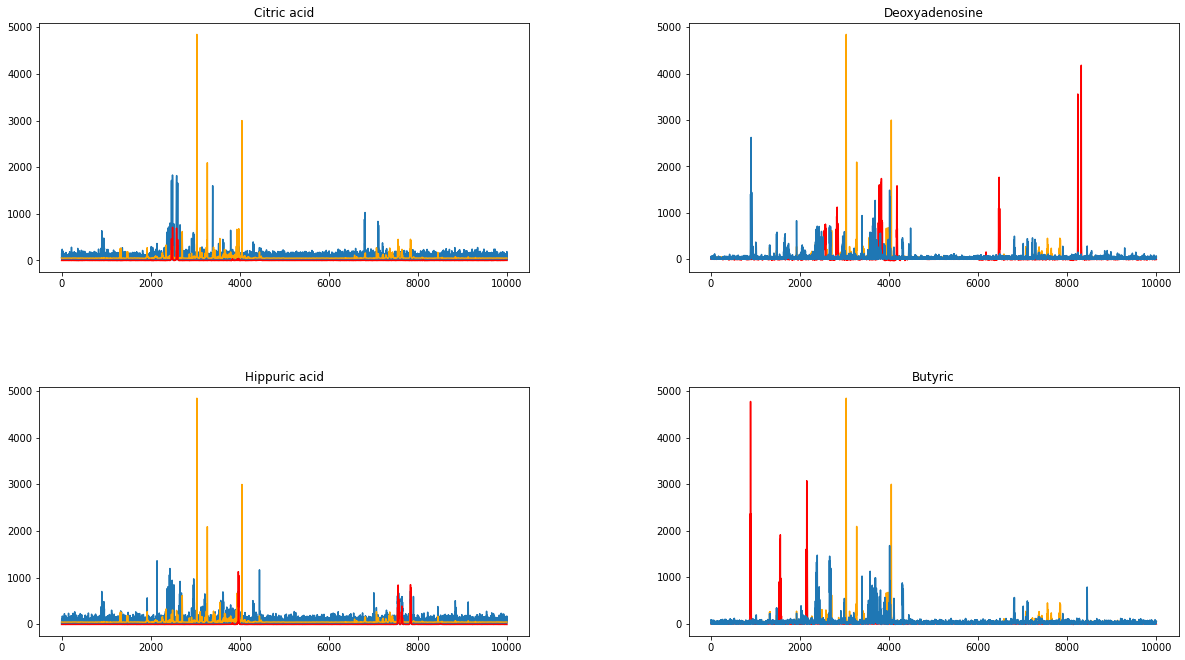

In [313]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_multi(large_multi_mlp, random_spectrum)


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 300)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 300)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20000, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 4000, color='red')
axs[0, 1].plot(sms[45] * 300)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20000, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 10000, color='red')
axs[1, 1].plot(sms[46] * 300)
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))

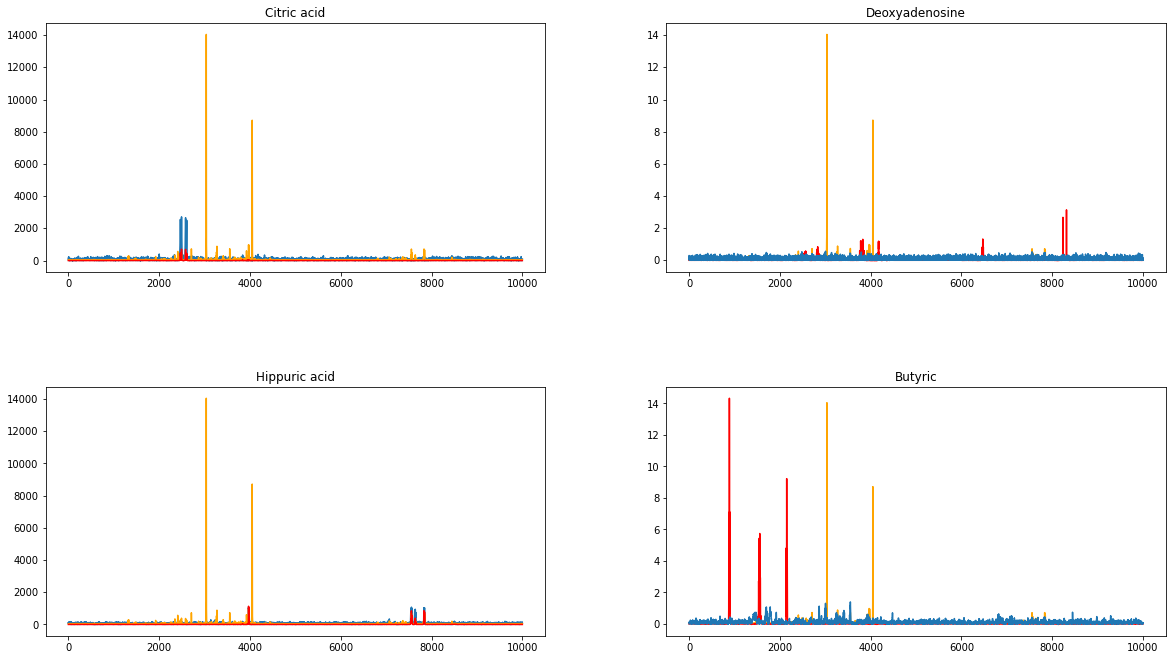

In [309]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_single(xsmall_inde_mlps, random_spectrum)



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 500)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 500)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 3, color='red')
axs[0, 1].plot(sms[45] * 10)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 30, color='red')
axs[1, 1].plot(sms[46])
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))